# Benchmark transcriptome representations on Tahoe for prediction of clinical success 

In [71]:
# Load autoreload extension
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import pandas as pd
import numpy as np
import scanpy as sc
from datasets import load_dataset

from classifier import *

## Load clinical approval annotation

In [73]:
# Load drug metadata from huggingface
ds = load_dataset("tahoebio/Tahoe-100M", "drug_metadata")
drug_metadata = ds["train"].to_pandas()
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid'].astype(str)
drug_metadata['pubchem_cid_str'] = drug_metadata['pubchem_cid_str'].str.split('\\.0').str[0]

cs = load_dataset("tahoebio/Tahoe-100M", "cell_line_metadata")
cell_line_metadata = cs["train"].to_pandas()
cell_line_metadata.head()

# Create a mapping from cell line ID to organ
cell_line_to_organ = dict(zip(cell_line_metadata['Cell_ID_Cellosaur'], cell_line_metadata['Organ']))

# Create a list of all drug names vs all cell line names (Cell_ID_Cellosaur)
# First, get unique drug names and cell line IDs
unique_drugs = drug_metadata['drug'].unique()
unique_cell_lines = cell_line_metadata['Cell_ID_Cellosaur'].unique()

# Create a DataFrame with all combinations of drugs and cell lines
drug_cellline_combinations = []
for drug in unique_drugs:
    for cell_line in unique_cell_lines:
        drug_cellline_combinations.append({
            'drug': drug,
            'cell_line': cell_line,
            'drug-cell_line': f"{drug}_{cell_line}"
        })

# Convert to DataFrame
drug_cellline_df = pd.DataFrame(drug_cellline_combinations)

# Display the first few rows
print(f"Total combinations: {len(drug_cellline_df)}")
drug_cellline_df.head()
# Add organ information to the drug_cellline_df
drug_cellline_df['organ'] = drug_cellline_df['cell_line'].map(cell_line_to_organ)

# Create a drug_organ column by combining drug name and organ
drug_cellline_df['drug_organ'] = drug_cellline_df['drug'] + '_' + drug_cellline_df['organ']

drug_cellline_df


Total combinations: 38658


drug  cell_line        drug-cell_line         organ  \
0            Talc  CVCL_0023        Talc_CVCL_0023          Lung   
1            Talc  CVCL_1286        Talc_CVCL_1286          Lung   
2            Talc  CVCL_1282        Talc_CVCL_1282  Vulva/Vagina   
3            Talc  CVCL_1034        Talc_CVCL_1034          Skin   
4            Talc  CVCL_2610        Talc_CVCL_2610          Skin   
...           ...        ...                   ...           ...   
38653  γ-Oryzanol  CVCL_1547  γ-Oryzanol_CVCL_1547          Lung   
38654  γ-Oryzanol  CVCL_1495  γ-Oryzanol_CVCL_1495          Lung   
38655  γ-Oryzanol  CVCL_1531  γ-Oryzanol_CVCL_1531          Lung   
38656  γ-Oryzanol  CVCL_1517  γ-Oryzanol_CVCL_1517          Lung   
38657  γ-Oryzanol  CVCL_1381  γ-Oryzanol_CVCL_1381          Skin   

              drug_organ  
0              Talc_Lung  
1              Talc_Lung  
2      Talc_Vulva/Vagina  
3              Talc_Skin  
4              Talc_Skin  
...                  ...  
38653    γ-Oryzanol_Lung  
38654    γ-Oryzanol_Lung  
38655    γ-Oryzanol_Lung  
38656    γ-Oryzanol_Lung  
38657    γ-Oryzanol_Skin  

[38658 rows x 5 columns]

In [74]:
# Read approval tables
approved_df = pd.read_csv('data/drugs_organs_approved.csv', index_col=0)
tested_df = pd.read_csv('data/drugs_organs_tested.csv', index_col=0)

# Map from pubchem_id to drug name
pubchem_to_drug = dict(zip(drug_metadata['pubchem_cid_str'].astype(str), drug_metadata['drug']))
tested_df.index = tested_df.index.map(lambda x: pubchem_to_drug.get(str(x), f"Unknown-{x}"))
approved_df.index = approved_df.index.map(lambda x: pubchem_to_drug.get(str(x), f"Unknown-{x}"))

# Melt the dataframes to have drug column and organ column
long_approved_df = approved_df.melt(var_name='organ', value_name='is_approved', ignore_index=False).reset_index().rename({'pubchem_id':'drug'}, axis=1)
long_approved_df['drug_organ'] = long_approved_df['drug'] + '_' + long_approved_df['organ']

long_tested_df = tested_df.melt(var_name='organ', value_name='is_tested', ignore_index=False).reset_index().rename({'pubchem_id':'drug'}, axis=1)
long_tested_df['drug_organ'] = long_tested_df['drug'] + '_' + long_tested_df['organ']

# Filter to only tested combos
long_approved_df = long_approved_df[long_tested_df['is_tested'] == 1]

## Load transcriptome representations from Tahoe

In [75]:
# E-distance
edist = pd.read_csv('./data_for_classifier/tahoe_largest_edist_per_drug_cell_line_combo.csv')
edist['cell_line'] = cell_line_metadata[['cell_name','Cell_ID_Cellosaur']].drop_duplicates().set_index('cell_name').loc[edist['cell_line']].Cell_ID_Cellosaur.values
edist['drug-cell_line'] = edist['drug_name'].astype(str) + '_' + edist['cell_line'].astype(str)
edist_df = edist.set_index('drug-cell_line')[['max_e_distance']]
edist_df = edist_df[edist_df.index.isin(drug_cellline_df['drug-cell_line'])]
edist_df['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[edist_df.index]['drug_organ']

edist_df.to_csv('./data_for_classifier/max_edist.csv')
edist_df.head()

max_e_distance               drug_organ
drug-cell_line                                                      
Homoharringtonine_CVCL_1097       77.017775   Homoharringtonine_Skin
Homoharringtonine_CVCL_0218       77.017775  Homoharringtonine_Bowel
Harringtonine_CVCL_1478           70.707085       Harringtonine_Lung
Homoharringtonine_CVCL_0366       77.017775  Homoharringtonine_Liver
Homoharringtonine_CVCL_1285       77.017775   Homoharringtonine_Lung

In [76]:
# LDVAE
ldvae_raw_emb = pd.read_table('./data_for_classifier/ldvae_raw_embeddings.tsv', index_col=0)
ldvae_raw_emb.head()
ldvae_raw_emb['drug_name'] = ldvae_raw_emb.index.str.split('_').str[0]
ldvae_raw_emb['cell_line'] = ldvae_raw_emb.index.str.split('_').str[1:].str.join('_')
ldvae_raw_emb['drug-cell_line'] = ldvae_raw_emb['drug_name'].astype(str) + '_' + ldvae_raw_emb['cell_line'].astype(str)
ldvae_raw_emb.index = ldvae_raw_emb['drug-cell_line']
ldvae_raw_emb = ldvae_raw_emb[ldvae_raw_emb.index.isin(drug_cellline_df['drug-cell_line'])]
ldvae_raw_emb = ldvae_raw_emb.drop(['drug-cell_line', 'drug_name', 'cell_line'], axis=1)
ldvae_raw_emb['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[ldvae_raw_emb.index]['drug_organ']
ldvae_raw_emb.head()

ldvae_0   ldvae_1   ldvae_2  \
drug-cell_line                                                          
(R)-Verapamil (hydrochloride)_CVCL_0023  0.014600  0.012926  0.011710   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.014513  0.013118  0.011858   
(S)-Crizotinib_CVCL_0023                 0.016476  0.012883  0.011638   
(S)-Crizotinib_CVCL_0023                 0.018304  0.013649  0.012170   
18β-Glycyrrhetinic acid_CVCL_0023        0.014723  0.013006  0.011624   

                                          ldvae_3   ldvae_4   ldvae_5  \
drug-cell_line                                                          
(R)-Verapamil (hydrochloride)_CVCL_0023  0.012142  0.015835  0.012668   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.012563  0.015460  0.013849   
(S)-Crizotinib_CVCL_0023                 0.011366  0.013653  0.012771   
(S)-Crizotinib_CVCL_0023                 0.011906  0.014439  0.012723   
18β-Glycyrrhetinic acid_CVCL_0023        0.012465  0.015860  0.013959   

                                          ldvae_6   ldvae_7   ldvae_8  \
drug-cell_line                                                          
(R)-Verapamil (hydrochloride)_CVCL_0023  0.321517  0.013512  0.013467   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.277566  0.013805  0.014732   
(S)-Crizotinib_CVCL_0023                 0.268295  0.014960  0.014189   
(S)-Crizotinib_CVCL_0023                 0.278399  0.015728  0.012894   
18β-Glycyrrhetinic acid_CVCL_0023        0.286499  0.013663  0.015108   

                                          ldvae_9  ...  ldvae_41  ldvae_42  \
drug-cell_line                                     ...                       
(R)-Verapamil (hydrochloride)_CVCL_0023  0.015075  ...  0.012238  0.016818   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.015866  ...  0.013585  0.018127   
(S)-Crizotinib_CVCL_0023                 0.015441  ...  0.014006  0.016438   
(S)-Crizotinib_CVCL_0023                 0.015095  ...  0.013581  0.016491   
18β-Glycyrrhetinic acid_CVCL_0023        0.015379  ...  0.013118  0.018286   

                                         ldvae_43  ldvae_44  ldvae_45  \
drug-cell_line                                                          
(R)-Verapamil (hydrochloride)_CVCL_0023  0.013118  0.014569  0.007875   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.012955  0.014728  0.009153   
(S)-Crizotinib_CVCL_0023                 0.012684  0.014392  0.009420   
(S)-Crizotinib_CVCL_0023                 0.013863  0.014496  0.009939   
18β-Glycyrrhetinic acid_CVCL_0023        0.012416  0.014518  0.008583   

                                         ldvae_46  ldvae_47  ldvae_48  \
drug-cell_line                                                          
(R)-Verapamil (hydrochloride)_CVCL_0023  0.011687  0.013895  0.014879   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.013128  0.015036  0.016103   
(S)-Crizotinib_CVCL_0023                 0.013180  0.014221  0.018036   
(S)-Crizotinib_CVCL_0023                 0.013252  0.013527  0.016531   
18β-Glycyrrhetinic acid_CVCL_0023        0.012813  0.014735  0.015741   

                                         ldvae_49  \
drug-cell_line                                      
(R)-Verapamil (hydrochloride)_CVCL_0023  0.013313   
(R)-Verapamil (hydrochloride)_CVCL_0023  0.014588   
(S)-Crizotinib_CVCL_0023                 0.015372   
(S)-Crizotinib_CVCL_0023                 0.015062   
18β-Glycyrrhetinic acid_CVCL_0023        0.014192   

                                                                 drug_organ  
drug-cell_line                                                               
(R)-Verapamil (hydrochloride)_CVCL_0023  (R)-Verapamil (hydrochloride)_Lung  
(R)-Verapamil (hydrochloride)_CVCL_0023  (R)-Verapamil (hydrochloride)_Lung  
(S)-Crizotinib_CVCL_0023                                (S)-Crizotinib_Lung  
(S)-Crizotinib_CVCL_0023                                (S)-Crizotinib_Lung  
18β-Glycyrrhetinic acid_CVCL_0023              18β-Glycyrrhetinic acid_Lung  

[5 rows x 51 col

In [77]:
# LDVAE (vs ctrls)
ldvae_emb = pd.read_table('./data_for_classifier/ldvae_embeddings.tsv', index_col=0)
ldvae_emb.head()
ldvae_emb['drug_name'] = ldvae_emb.index.str.split('_').str[0]
ldvae_emb['cell_line'] = ldvae_emb.index.str.split('_').str[1:].str.join('_')
ldvae_emb['drug-cell_line'] = ldvae_emb['drug_name'].astype(str) + '_' + ldvae_emb['cell_line'].astype(str)
ldvae_emb.index = ldvae_emb['drug-cell_line']
ldvae_emb = ldvae_emb[ldvae_emb.index.isin(drug_cellline_df['drug-cell_line'])]
ldvae_emb = ldvae_emb.drop(['drug-cell_line', 'drug_name', 'cell_line'], axis=1)
ldvae_emb['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[ldvae_emb.index]['drug_organ']
ldvae_emb.head()

ldvae_minusctrl_0  ldvae_minusctrl_1  \
drug-cell_line                                                                  
(R)-Verapamil (hydrochloride)_CVCL_0023          -0.001000          -0.000458   
(R)-Verapamil (hydrochloride)_CVCL_0023          -0.001088          -0.000266   
(S)-Crizotinib_CVCL_0023                          0.000876          -0.000501   
(S)-Crizotinib_CVCL_0023                          0.002703           0.000265   
18β-Glycyrrhetinic acid_CVCL_0023                -0.000877          -0.000378   

                                         ldvae_minusctrl_2  ldvae_minusctrl_3  \
drug-cell_line                                                                  
(R)-Verapamil (hydrochloride)_CVCL_0023           0.000062           0.000143   
(R)-Verapamil (hydrochloride)_CVCL_0023           0.000210           0.000563   
(S)-Crizotinib_CVCL_0023                         -0.000010          -0.000634   
(S)-Crizotinib_CVCL_0023                          0.000522          -0.000093   
18β-Glycyrrhetinic acid_CVCL_0023                -0.000024           0.000465   

                                         ldvae_minusctrl_4  ldvae_minusctrl_5  \
drug-cell_line                                                                  
(R)-Verapamil (hydrochloride)_CVCL_0023           0.000520           0.000020   
(R)-Verapamil (hydrochloride)_CVCL_0023           0.000144           0.001201   
(S)-Crizotinib_CVCL_0023                         -0.001663           0.000123   
(S)-Crizotinib_CVCL_0023                         -0.000876           0.000075   
18β-Glycyrrhetinic acid_CVCL_0023                 0.000544           0.001311   

                                         ldvae_minusctrl_6  ldvae_minusctrl_7  \
drug-cell_line                                                                  
(R)-Verapamil (hydrochloride)_CVCL_0023           0.024449          -0.001167   
(R)-Verapamil (hydrochloride)_CVCL_0023          -0.019502          -0.000874   
(S)-Crizotinib_CVCL_0023                         -0.028773           0.000282   
(S)-Crizotinib_CVCL_0023                         -0.018669           0.001050   
18β-Glycyrrhetinic acid_CVCL_0023                -0.010569          -0.001016   

                                         ldvae_minusctrl_8  ldvae_minusctrl_9  \
drug-cell_line                                                                  
(R)-Verapamil (hydrochloride)_CVCL_0023          -0.000530          -0.000126   
(R)-Verapamil (hydrochloride)_CVCL_0023           0.000735           0.000665   
(S)-Crizotinib_CVCL_0023                          0.000192           0.000240   
(S)-Crizotinib_CVCL_0023                         -0.001103          -0.000106   
18β-Glycyrrhetinic acid_CVCL_0023                 0.001111           0.000178   

                                         ...  ldvae_minusctrl_41  \
drug-cell_line                           ...                       
(R)-Verapamil (hydrochloride)_CVCL_0023  ...           -0.000989   
(R)-Verapamil (hydrochloride)_CVCL_0023  ...            0.000357   
(S)-Crizotinib_CVCL_0023                 ...            0.000779   
(S)-Crizotinib_CVCL_0023                 ...            0.000353   
18β-Glycyrrhetinic acid_CVCL_0023        ...           -0.000109   

                                         ldvae_minusctrl_42  \
drug-cell_line                                                
(R)-Verapamil (hydrochloride)_CVCL_0023            0.000180   
(R)-Verapamil (hydrochloride)_CVCL_0023            0.001489   
(S)-Crizotinib_CVCL_0023                          -0.000200   
(S)-Crizotinib_CVCL_0023                          -0.000147   
18β-Glycyrrhetinic acid_CVCL_0023                  0.001648   

                                         ldvae_minusctrl_43  \
drug-cell_line                                                
(R)-Verapamil (hydrochloride)_CVCL_0023            0.000247   
(R)-Verapamil (hydrochloride)_CVCL_0023            0.000085   
(S)-Crizotinib_CVCL_0023      

In [78]:
# mrVI (vs ctrls)
mrvi_emb = pd.read_csv('./data_for_classifier/tahoe_pseudobulk_z-space_by_sample.csv', index_col=0)
mrvi_emb['cell_line'] = mrvi_emb.index.str.split('_').str[0]
mrvi_emb['drug_name'] = mrvi_emb.index.str.split('_').str[1]

# Filter DMSO controls
ctrl_emb = mrvi_emb[mrvi_emb.index.str.contains('DMSO')]

# Create a dictionary mapping cell lines to their DMSO control embeddings
cell_to_ctrl = {}
for idx, row in ctrl_emb.iterrows():
    cell_line = row['cell_line']
    # Store the embedding values (excluding metadata columns)
    cell_to_ctrl[cell_line] = row.drop(['cell_line', 'drug_name']).values

# Create a new dataframe with the same columns as the original (excluding metadata)
feature_cols = [col for col in mrvi_emb.columns if col not in ['cell_line', 'drug_name']]
mrvi_minusctrl_emb = pd.DataFrame(index=mrvi_emb.index, columns=feature_cols)

# Subtract DMSO control effect for each cell line
for idx, row in mrvi_emb.iterrows():
    cell_line = row['cell_line']
    if cell_line in cell_to_ctrl and not idx.endswith('DMSO'):
        # Get the feature values (excluding metadata)
        treatment_values = row[feature_cols].values
        # Subtract control embedding from treatment embedding
        diff_values = treatment_values - cell_to_ctrl[cell_line]
        # Assign the difference to the new dataframe
        mrvi_minusctrl_emb.loc[idx, :] = diff_values

# Add back metadata columns
mrvi_minusctrl_emb['cell_line'] = mrvi_emb['cell_line']
mrvi_minusctrl_emb['drug_name'] = mrvi_emb['drug_name']

# Map cell line names to Cell_ID_Cellosaur
mrvi_minusctrl_emb['cell_line'] = cell_line_metadata[['cell_name','Cell_ID_Cellosaur']].drop_duplicates().set_index('cell_name').loc[mrvi_minusctrl_emb['cell_line']].Cell_ID_Cellosaur.values
mrvi_minusctrl_emb['drug-cell_line'] = mrvi_minusctrl_emb['drug_name'].astype(str) + '_' + mrvi_minusctrl_emb['cell_line'].astype(str)
mrvi_minusctrl_emb.index = mrvi_minusctrl_emb['drug-cell_line']
mrvi_minusctrl_emb = mrvi_minusctrl_emb[mrvi_minusctrl_emb.index.isin(drug_cellline_df['drug-cell_line'])]
mrvi_minusctrl_emb = mrvi_minusctrl_emb.drop(['drug-cell_line', 'drug_name', 'cell_line'], axis=1)
mrvi_minusctrl_emb['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[mrvi_minusctrl_emb.index]['drug_organ']
mrvi_minusctrl_emb.head()

X1        X2        X3        X4  \
drug-cell_line                                                         
8-Hydroxyquinoline_CVCL_0023 -0.050757  0.015316  -0.01855  0.002945   
8-Hydroxyquinoline_CVCL_0332 -0.047209 -0.028794 -0.049754  0.017076   
8-Hydroxyquinoline_CVCL_0292  0.004389   0.09699  0.085399  0.031639   
8-Hydroxyquinoline_CVCL_1285  0.034943 -0.106368  0.029829  0.099107   
8-Hydroxyquinoline_CVCL_0069  0.012348 -0.023597   0.02016  0.035875   

                                    X5        X6        X7        X8  \
drug-cell_line                                                         
8-Hydroxyquinoline_CVCL_0023  0.088726 -0.067733  0.081334 -0.011808   
8-Hydroxyquinoline_CVCL_0332 -0.025897 -0.041339  0.055992  0.088693   
8-Hydroxyquinoline_CVCL_0292 -0.053742 -0.014977 -0.094544 -0.101401   
8-Hydroxyquinoline_CVCL_1285 -0.029773 -0.021589  0.007419  0.020719   
8-Hydroxyquinoline_CVCL_0069  0.037085  0.038005  0.000862 -0.035735   

                                    X9       X10  ...       X22       X23  \
drug-cell_line                                    ...                       
8-Hydroxyquinoline_CVCL_0023 -0.009537  -0.01197  ... -0.017489  -0.03083   
8-Hydroxyquinoline_CVCL_0332 -0.036631 -0.048626  ...   0.04907  0.038005   
8-Hydroxyquinoline_CVCL_0292   0.06168 -0.007969  ...  0.072591 -0.017414   
8-Hydroxyquinoline_CVCL_1285 -0.003098  0.051637  ...  0.009811  0.031412   
8-Hydroxyquinoline_CVCL_0069 -0.028665  0.000463  ...  0.012052 -0.006632   

                                   X24       X25       X26       X27  \
drug-cell_line                                                         
8-Hydroxyquinoline_CVCL_0023  0.051016 -0.051938   0.01266 -0.048396   
8-Hydroxyquinoline_CVCL_0332  0.018891 -0.022753  0.013238 -0.016447   
8-Hydroxyquinoline_CVCL_0292  0.114219 -0.142417  -0.00345 -0.092104   
8-Hydroxyquinoline_CVCL_1285 -0.098515 -0.036816 -0.051145 -0.158384   
8-Hydroxyquinoline_CVCL_0069 -0.019792 -0.004489  0.020291 -0.042507   

                                   X28       X29       X30  \
drug-cell_line                                               
8-Hydroxyquinoline_CVCL_0023   0.07909   0.09708 -0.062447   
8-Hydroxyquinoline_CVCL_0332  0.022098  -0.00366 -0.040475   
8-Hydroxyquinoline_CVCL_0292  0.218873  0.064806 -0.073699   
8-Hydroxyquinoline_CVCL_1285  0.003922 -0.103696  0.037582   
8-Hydroxyquinoline_CVCL_0069 -0.017734  0.004422 -0.035816   

                                             drug_organ  
drug-cell_line                                           
8-Hydroxyquinoline_CVCL_0023    8-Hydroxyquinoline_Lung  
8-Hydroxyquinoline_CVCL_0332  8-Hydroxyquinoline_Breast  
8-Hydroxyquinoline_CVCL_0292   8-Hydroxyquinoline_Bowel  
8-Hydroxyquinoline_CVCL_1285    8-Hydroxyquinoline_Lung  
8-Hydroxyquinoline_CVCL_0069    8-Hydroxyquinoline_Skin  

[5 rows x 31 columns]

In [79]:
# mrVI
mrvi_emb = pd.read_csv('./data_for_classifier/tahoe_pseudobulk_z-space_by_sample.csv', index_col=0)
mrvi_emb['cell_line'] = mrvi_emb.index.str.split('_').str[0]
mrvi_emb['drug_name'] = mrvi_emb.index.str.split('_').str[1]
mrvi_emb['cell_line'] = cell_line_metadata[['cell_name','Cell_ID_Cellosaur']].drop_duplicates().set_index('cell_name').loc[mrvi_emb['cell_line']].Cell_ID_Cellosaur.values
mrvi_emb['drug-cell_line'] = mrvi_emb['drug_name'].astype(str) + '_' + mrvi_emb['cell_line'].astype(str)
mrvi_emb.index = mrvi_emb['drug-cell_line']
mrvi_emb = mrvi_emb[mrvi_emb.index.isin(drug_cellline_df['drug-cell_line'])]
mrvi_emb = mrvi_emb.drop(['drug-cell_line', 'drug_name', 'cell_line'], axis=1)
mrvi_emb['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[mrvi_emb.index]['drug_organ']
mrvi_emb.head()

X1        X2        X3        X4  \
drug-cell_line                                                         
8-Hydroxyquinoline_CVCL_0023 -0.213787  0.565904  0.039704  0.403183   
8-Hydroxyquinoline_CVCL_0332  0.779318  0.704898  0.272889 -0.981048   
8-Hydroxyquinoline_CVCL_0292 -0.771231  0.316762 -1.287454  0.419516   
8-Hydroxyquinoline_CVCL_1285 -0.544560 -0.235235 -0.499555 -0.189770   
8-Hydroxyquinoline_CVCL_0069 -0.292731  0.016341 -1.273121 -0.077609   

                                    X5        X6        X7        X8  \
drug-cell_line                                                         
8-Hydroxyquinoline_CVCL_0023  0.263457 -0.183731 -0.652466 -1.022551   
8-Hydroxyquinoline_CVCL_0332  0.449288  0.413061 -0.458381 -0.319680   
8-Hydroxyquinoline_CVCL_0292  0.707284  0.165528 -0.092563 -0.619698   
8-Hydroxyquinoline_CVCL_1285  0.674474  0.084030 -0.412386 -0.761185   
8-Hydroxyquinoline_CVCL_0069 -0.885130  0.880758  1.940214 -0.715786   

                                    X9       X10  ...       X22       X23  \
drug-cell_line                                    ...                       
8-Hydroxyquinoline_CVCL_0023  0.408729  0.048305  ... -0.116504  1.252591   
8-Hydroxyquinoline_CVCL_0332  0.684116  0.506082  ... -0.262083 -0.396212   
8-Hydroxyquinoline_CVCL_0292 -0.166979  0.780601  ... -0.035934  0.919477   
8-Hydroxyquinoline_CVCL_1285  0.634883  0.087151  ... -0.104640 -0.154316   
8-Hydroxyquinoline_CVCL_0069  1.861963  0.318029  ... -1.425164  0.225483   

                                   X24       X25       X26       X27  \
drug-cell_line                                                         
8-Hydroxyquinoline_CVCL_0023 -0.581706 -1.117497  0.883995 -0.040421   
8-Hydroxyquinoline_CVCL_0332  0.381725 -0.824410 -0.419530  1.691034   
8-Hydroxyquinoline_CVCL_0292 -0.265929  0.193840 -0.185440 -0.482807   
8-Hydroxyquinoline_CVCL_1285  0.988890 -0.315711 -0.284397  0.518847   
8-Hydroxyquinoline_CVCL_0069  1.789956 -0.335696 -1.148991  0.124015   

                                   X28       X29       X30  \
drug-cell_line                                               
8-Hydroxyquinoline_CVCL_0023  0.310658  0.060963  0.475998   
8-Hydroxyquinoline_CVCL_0332 -0.122392  1.816938 -0.661881   
8-Hydroxyquinoline_CVCL_0292  0.066068  0.537396  0.108773   
8-Hydroxyquinoline_CVCL_1285  0.070113  1.295002  0.184966   
8-Hydroxyquinoline_CVCL_0069  1.663318  0.200804 -0.067681   

                                             drug_organ  
drug-cell_line                                           
8-Hydroxyquinoline_CVCL_0023    8-Hydroxyquinoline_Lung  
8-Hydroxyquinoline_CVCL_0332  8-Hydroxyquinoline_Breast  
8-Hydroxyquinoline_CVCL_0292   8-Hydroxyquinoline_Bowel  
8-Hydroxyquinoline_CVCL_1285    8-Hydroxyquinoline_Lung  
8-Hydroxyquinoline_CVCL_0069    8-Hydroxyquinoline_Skin  

[5 rows x 31 columns]

## Test prediction of clinical approval

Control for overall approval rate for each organ

In [80]:
approval_rate = long_approved_df.groupby('organ')['is_approved'].sum()
tested_tot = long_approved_df.groupby('organ')['is_approved'].size()
approval_rate = approval_rate/tested_tot

organs_order = edist_df.drug_organ.str.split('_').str[-1].tolist()
approval_rate_df = approval_rate.loc[organs_order].reset_index()
approval_rate_df.index = edist_df.index
approval_rate_df = approval_rate_df.drop('organ', axis=1)
approval_rate_df['drug_organ'] = edist_df['drug_organ'].values
approval_rate_df.head()

is_approved               drug_organ
drug-cell_line                                                   
Homoharringtonine_CVCL_1097     0.255172   Homoharringtonine_Skin
Homoharringtonine_CVCL_0218     0.239264  Homoharringtonine_Bowel
Harringtonine_CVCL_1478         0.331683       Harringtonine_Lung
Homoharringtonine_CVCL_0366     0.287582  Homoharringtonine_Liver
Homoharringtonine_CVCL_1285     0.331683   Homoharringtonine_Lung

In [89]:
test_features = {
    'approval rate': approval_rate_df,
    'E-dist':edist_df,
    'LDVAE':ldvae_raw_emb,
    'LDVAE (vs ctrl)':ldvae_emb,
    'mrVI':mrvi_emb,
    'mrVI (vs ctrl)': mrvi_minusctrl_emb
}

for ldvae_key in ['LDVAE', 'LDVAE (vs ctrl)']:
    if ldvae_key in test_features:
        ldvae_data = test_features[ldvae_key].copy()
        numeric_columns = ldvae_data.columns.drop('drug_organ')
        for col in numeric_columns:
            lower_bound = np.percentile(ldvae_data[col], 1)
            upper_bound = np.percentile(ldvae_data[col], 99)
            ldvae_data[col] = ldvae_data[col].clip(lower=lower_bound, upper=upper_bound)
        test_features[ldvae_key] = ldvae_data

# Convert numerical columns to float type
mrvi_vs_ctrl = test_features.get('mrVI (vs ctrl)', pd.DataFrame()).copy()
if not mrvi_vs_ctrl.empty:
    numeric_columns = mrvi_vs_ctrl.columns.drop('drug_organ')
    mrvi_vs_ctrl[numeric_columns] = mrvi_vs_ctrl[numeric_columns].astype(float)
    test_features['mrVI (vs ctrl)'] = mrvi_vs_ctrl
    test_features['mrVI (vs ctrl)']

for k, data in test_features.items():
    if k != 'approval rate':
        data['approval_rate'] = approval_rate_df['is_approved']
        data = data.dropna()
        test_features[k] = data

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5803657028013552
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3221
Model training ROC AUC: 0.5672
Regularization: alpha=0.001

ROC AUC: 0.6168
Baseline ROC AUC: 0.5000
PR AUC: 0.3650
Baseline PR AUC: 0.2765

Top significant features (p < 0.05):
                 Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved     0.245871  0.000524    1.278735     0.106926   

             CI_Upper_95  
is_approved     0.384817  

Number of significant coefficients (p < 0.05): 1 out of 1


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_229542/1474789453.py:61: 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5264909245209776
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3116
Model training ROC AUC: 0.6063
Regularization: alpha=0.001

ROC AUC: 0.6074
Baseline ROC AUC: 0.5000
PR AUC: 0.3677
Baseline PR AUC: 0.2872

Top significant features (p < 0.05):
                 Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved     0.384822  2.088364e-08    1.469353     0.250245   

             CI_Upper_95  
is_approved     0.519399  

Number of significant coefficients (p < 0.05): 1 out of 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5716765051177529
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3940
Model training ROC AUC: 0.6447
Regulariz

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5755183385609489
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3629
Model training ROC AUC: 0.6039
Regularization: alpha=0.001

ROC AUC: 0.6086
Baseline ROC AUC: 0.5000
PR AUC: 0.3552
Baseline PR AUC: 0.2739


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                 Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved     0.495505  1.298938e-15    1.641327     0.374028   

             CI_Upper_95  
is_approved     0.616982  

Number of significant coefficients (p < 0.05): 1 out of 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5971863213699424
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3662
Model training ROC AUC: 0.6091
Regularization: alpha=0.001

ROC AUC: 0.6085
Baseline ROC AUC: 0.5000
PR AUC: 0.3547
Baseline PR AUC: 0.2653

Top significant features (p < 0.05):
                 Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved      0.50288  2.116032e-18    1.653477     0.390249   

             CI_Upper_95  
is_approved     0.615512  

Number of significant coefficients (p < 

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top 1 features for approval rate (by absolute z-score):
is_approved: 7.1747
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5803657028013552
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3221
Model training ROC AUC: 0.5672
Regularization: alpha=0.001

ROC AUC: 0.6168
Baseline ROC AUC: 0.5000
PR AUC: 0.3650
Baseline PR AUC: 0.2765

Top significant features (p < 0.05):
                 Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved     0.245871  0.000524    1.278735     0.106926   

             CI_Upper_95  
is_approved     0.384817  

Number of significant coefficients (p < 0.05): 1 out of 1


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_229542/1474789453.py:111:

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5264909245209776
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3116
Model training ROC AUC: 0.6063
Regularization: alpha=0.001

ROC AUC: 0.6074
Baseline ROC AUC: 0.5000
PR AUC: 0.3677
Baseline PR AUC: 0.2872

Top significant features (p < 0.05):
                 Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved     0.384822  2.088364e-08    1.469353     0.250245   

             CI_Upper_95  
is_approved     0.519399  

Number of significant coefficients (p < 0.05): 1 out of 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5716765051177529
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3940
Model training ROC AUC: 0.6447
Regulariz

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5755183385609489
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3629
Model training ROC AUC: 0.6039
Regularization: alpha=0.001

ROC AUC: 0.6086
Baseline ROC AUC: 0.5000
PR AUC: 0.3552
Baseline PR AUC: 0.2739

Top significant features (p < 0.05):
                 Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved     0.495505  1.298938e-15    1.641327     0.374028   

             CI_Upper_95  
is_approved     0.616982  

Number of significant coefficients (p < 0.05): 1 out of 1


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5971863213699424
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.3662
Model training ROC AUC: 0.6091
Regularization: alpha=0.001

ROC AUC: 0.6085
Baseline ROC AUC: 0.5000
PR AUC: 0.3547
Baseline PR AUC: 0.2653

Top significant features (p < 0.05):
                 Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  \
is_approved  is_approved      0.50288  2.116032e-18    1.653477     0.390249   

             CI_Upper_95  
is_approved     0.615512  

Number of significant coefficients (p < 0.05): 1 out of 1


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Results with all features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.364995  0.723502         0.276498      6076
1         43  0.367703  0.712753         0.287247      5967
2       5235  0.346909  0.726496         0.270427      5850
3        332  0.355199  0.726102         0.273898      5900
4       2132  0.354659  0.732492         0.265260      5783

Results with top 1 features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.364995  0.723502         0.276498      6076
1         43  0.367703  0.712753         0.287247      5967
2       5235  0.346909  0.726496         0.270427      5850
3        332  0.355199  0.726102         0.273898      5900
4       2132  0.354659  0.732492         0.265260      5783
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5802853946022539
            Iterations: 16
            Function evaluations: 17
 

/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:159: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))



Top significant features (p < 0.05):
No statistically significant features found.

Number of significant coefficients (p < 0.05): 0 out of 2


/tmp/ipykernel_229542/1474789453.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, Conv

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5063796786831694
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Model training Precision-Recall AUC: 0.3029
Model training ROC AUC: 0.6479
Regularization: alpha=0.001

ROC AUC: 0.6162
Baseline ROC AUC: 0.5000
PR AUC: 0.3517
Baseline PR AUC: 0.2872

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance    -0.835401  6.237310e-12    0.433701   
approval_rate    approval_rate     0.377115  5.291321e-08    1.458071   

                CI_Lower_95  CI_Upper_95  
max_e_distance    -1.073592    -0.597210  
approval_rate      0.241276     0.512953  

Number of significant coefficients (p < 0.05): 2 out of 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5712066697724514
            Iterations: 21
            Function eva

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5623889866631802
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Model training Precision-Recall AUC: 0.3686
Model training ROC AUC: 0.6398
Regularization: alpha=0.001

ROC AUC: 0.6287
Baseline ROC AUC: 0.5000
PR AUC: 0.3462
Baseline PR AUC: 0.2739

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance    -0.657251  2.336778e-09    0.518274   
approval_rate    approval_rate     0.500035  4.843645e-15    1.648780   

                CI_Lower_95  CI_Upper_95  
max_e_distance    -0.872939    -0.441564  
approval_rate      0.374884     0.625187  

Number of significant coefficients (p < 0.05): 2 out of 2


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5953291390656616
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Model training Precision-Recall AUC: 0.3713
Model training ROC AUC: 0.6199
Regularization: alpha=0.001

ROC AUC: 0.6311
Baseline ROC AUC: 0.5000
PR AUC: 0.3504
Baseline PR AUC: 0.2653

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate    approval_rate     0.502845  4.135113e-18    1.653418   
max_e_distance  max_e_distance    -0.194073  1.077838e-02    0.823598   

                CI_Lower_95  CI_Upper_95  
approval_rate      0.389236     0.616454  
max_e_distance    -0.343252    -0.044894  

Number of significant coefficients (p < 0.05): 2 out of 2


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top 2 features for E-dist (by absolute z-score):
approval_rate: 6.3842
max_e_distance: 3.3325
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5802853946022539
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16
Model training Precision-Recall AUC: 0.6360
Model training ROC AUC: 0.5000
Regularization: alpha=0.001

ROC AUC: 0.5000
Baseline ROC AUC: 0.5000
PR AUC: 0.6382
Baseline PR AUC: 0.2765

Top significant features (p < 0.05):
No statistically significant features found.

Number of significant coefficients (p < 0.05): 0 out of 2


/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_229542/1474789453.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  topk_results_df = pd.concat([topk_results_df, new_row], ignore_index=True)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 3 parameters
Try increasing solver accuracy or number of iterations, d

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5063796786831694
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Model training Precision-Recall AUC: 0.3029
Model training ROC AUC: 0.6479
Regularization: alpha=0.001

ROC AUC: 0.6162
Baseline ROC AUC: 0.5000
PR AUC: 0.3517
Baseline PR AUC: 0.2872

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance    -0.835401  6.237310e-12    0.433701   
approval_rate    approval_rate     0.377115  5.291321e-08    1.458071   

                CI_Lower_95  CI_Upper_95  
max_e_distance    -1.073592    -0.597210  
approval_rate      0.241276     0.512953  

Number of significant coefficients (p < 0.05): 2 out of 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5712066697724515
            Iterations: 21
            Function eva

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5623889866631803
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Model training Precision-Recall AUC: 0.3686
Model training ROC AUC: 0.6398
Regularization: alpha=0.001

ROC AUC: 0.6287
Baseline ROC AUC: 0.5000
PR AUC: 0.3462
Baseline PR AUC: 0.2739

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance    -0.657251  2.336778e-09    0.518274   
approval_rate    approval_rate     0.500035  4.843645e-15    1.648780   

                CI_Lower_95  CI_Upper_95  
max_e_distance    -0.872939    -0.441564  
approval_rate      0.374884     0.625187  

Number of significant coefficients (p < 0.05): 2 out of 2


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5953291390656616
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Model training Precision-Recall AUC: 0.3713
Model training ROC AUC: 0.6199
Regularization: alpha=0.001

ROC AUC: 0.6311
Baseline ROC AUC: 0.5000
PR AUC: 0.3504
Baseline PR AUC: 0.2653

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate    approval_rate     0.502845  4.135113e-18    1.653418   
max_e_distance  max_e_distance    -0.194073  1.077838e-02    0.823598   

                CI_Lower_95  CI_Upper_95  
approval_rate      0.389236     0.616454  
max_e_distance    -0.343252    -0.044894  

Number of significant coefficients (p < 0.05): 2 out of 2


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Results with all features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.638249  0.723502         0.276498      6076
1         43  0.351666  0.712753         0.287247      5967
2       5235  0.342796  0.727009         0.270427      5850
3        332  0.346168  0.725593         0.273898      5900
4       2132  0.350437  0.733702         0.265260      5783

Results with top 2 features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.638249  0.723502         0.276498      6076
1         43  0.351666  0.712753         0.287247      5967
2       5235  0.342796  0.727009         0.270427      5850
3        332  0.346168  0.725593         0.273898      5900
4       2132  0.350437  0.733702         0.265260      5783
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5355967107179165
            Iterations: 343
            Function evaluations: 343

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 32 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
           Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  \
ldvae_49  ldvae_49     1.029466  7.571722e-04    2.799569     0.430380   
ldvae_37  ldvae_37     0.991341  5.510659e-04    2.694845     0.428908   
ldvae_14  ldvae_14     0.985951  3.013588e-04    2.680360     0.451264   
ldvae_1    ldvae_1     0.938920  8.385039e-05    2.557218     0.471035   
ldvae_47  ldvae_47     0.865668  8.604439e-06    2.376594     0.484355   
ldvae_5    ldvae_5     0.847426  1.466332e-05    2.333633     0.464167   
ldvae_41  ldvae_41     0.843677  5.199140e-05    2.324900     0.435032   
ldvae_22  ldvae_22     0.826853  9.645239e-07    2.286114     0.496033   
ldvae_10  ldvae_10     0.822081  3.968891e-05    2.275230     0.429981   
ldvae_9    ldvae_9     0.811435  1.138012e-04    2.251137     0.399324   

          CI_Upper_95  
ldvae_49     1.628551  
ldvae_37     1.553773  
ldvae_14     1.520638  
ldvae_1      1.406805  
ldvae_47     1.246982  
ldv

/tmp/ipykernel_229542/1474789453.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.549171427416745
            Iterations: 228
            Function evaluations: 229
            Gradient evaluations: 228
Model training Precision-Recall AUC: 0.4090
Model training ROC AUC: 0.6699
Regularization: alpha=0.001

ROC AUC: 0.5845
Baseline ROC AUC: 0.5000
PR AUC: 0.3259
Baseline PR AUC: 0.2791


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 34 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  \
approval_rate  approval_rate     0.589503  0.000004    1.803093     0.340158   
ldvae_9              ldvae_9    -0.492350  0.024116    0.611189    -0.920231   
ldvae_47            ldvae_47    -0.491913  0.013892    0.611456    -0.883831   
ldvae_27            ldvae_27    -0.484915  0.025581    0.615750    -0.910631   
ldvae_32            ldvae_32    -0.416808  0.042155    0.659147    -0.818842   
ldvae_5              ldvae_5    -0.408546  0.043995    0.664616    -0.806102   
ldvae_28            ldvae_28    -0.402246  0.041848    0.668816    -0.789655   
ldvae_2              ldvae_2    -0.377655  0.019505    0.685467    -0.694553   
ldvae_18            ldvae_18    -0.377488  0.014422    0.685582    -0.679895   
ldvae_0              ldvae_0    -0.343442  0.000804    0.709325    -0.544302   

               CI_Upper_95  
approval_rate     0.838849  
ldvae_9          -0.064

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 30 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
ldvae_49            ldvae_49    -0.595745  2.856323e-02    0.551152   
ldvae_14            ldvae_14    -0.587242  1.751779e-02    0.555858   
approval_rate  approval_rate     0.519253  4.912487e-06    1.680771   
ldvae_10            ldvae_10    -0.474930  1.098059e-02    0.621929   
ldvae_31            ldvae_31    -0.472280  5.635568e-10    0.623579   
ldvae_43            ldvae_43    -0.465818  2.054294e-02    0.627622   
ldvae_35            ldvae_35    -0.455964  8.318534e-03    0.633837   
ldvae_28            ldvae_28    -0.434142  1.202896e-02    0.647820   
ldvae_13            ldvae_13    -0.433046  7.257886e-03    0.648531   
ldvae_27            ldvae_27    -0.425351  2.313473e-02    0.653540   

               CI_Lower_95  CI_Upper_95  
ldvae_49         -1.129044    -0.062446  
ldvae_14         -1.071729    -0.102756  
approval_rate     0.296484     0.742021  
ldvae_10    

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 27 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
ldvae_49            ldvae_49     1.521685  4.953831e-05    4.579935   
ldvae_37            ldvae_37     1.430729  5.145399e-05    4.181748   
ldvae_14            ldvae_14     1.365292  5.884220e-05    3.916868   
ldvae_24            ldvae_24    -1.331166  4.923399e-02    0.264169   
ldvae_1              ldvae_1     1.265859  2.379137e-05    3.546138   
ldvae_43            ldvae_43     1.233599  8.906940e-06    3.433565   
ldvae_10            ldvae_10     1.189745  4.742390e-06    3.286244   
approval_rate  approval_rate     1.183932  1.811101e-08    3.267196   
ldvae_35            ldvae_35     1.101363  3.207825e-06    3.008264   
ldvae_42            ldvae_42     1.073521  7.310990e-05    2.925662   

               CI_Lower_95  CI_Upper_95  
ldvae_49          0.786693     2.256677  
ldvae_37          0.738155     2.123303  
ldvae_14          0.699210     2.031375  
ldvae_24    

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 32 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.776178  8.571388e-11    2.173150   
ldvae_31            ldvae_31    -0.447473  1.647958e-10    0.639242   
ldvae_40            ldvae_40    -0.433142  2.457025e-09    0.648468   
ldvae_11            ldvae_11     0.392521  1.646512e-09    1.480709   
ldvae_0              ldvae_0     0.199265  6.835591e-03    1.220505   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.541782     1.010574  
ldvae_31         -0.584702    -0.310244  
ldvae_40         -0.575480    -0.290805  
ldvae_11          0.264923     0.520119  
ldvae_0           0.054870     0.343660  

Number of significant coefficients (p < 0.05): 5 out of 51

Top 3 features for LDVAE (by absolute z-score):
approval_rate: 5.3688
ldvae_11: 4.5881
ldvae_40: 4.0050
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5539009458459272
         

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.538030  9.042267e-41    1.712630   
ldvae_11            ldvae_11    -0.211594  1.343490e-07    0.809294   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.459158     0.616901  
ldvae_11         -0.290245    -0.132942  

Number of significant coefficients (p < 0.05): 2 out of 3


/tmp/ipykernel_229542/1474789453.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  topk_results_df = pd.concat([topk_results_df, new_row], ignore_index=True)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.war

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5634022686249051
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Model training Precision-Recall AUC: 0.3760
Model training ROC AUC: 0.6417
Regularization: alpha=0.001

ROC AUC: 0.6235
Baseline ROC AUC: 0.5000
PR AUC: 0.3688
Baseline PR AUC: 0.2791

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.466777  1.877220e-32    1.594846   
ldvae_11            ldvae_11     0.198756  1.122520e-06    1.219884   
ldvae_40            ldvae_40    -0.175241  1.193008e-02    0.839255   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.389648     0.543906  
ldvae_11          0.118746     0.278765  
ldvae_40         -0.311852    -0.038631  

Number of significant coefficients (p < 0.05): 3 out of 3
Optimization terminated successfully    (Exit mode 0)
  

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.53466253183318
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Model training Precision-Recall AUC: 0.3717
Model training ROC AUC: 0.6649
Regularization: alpha=0.001

ROC AUC: 0.6189
Baseline ROC AUC: 0.5000
PR AUC: 0.3691
Baseline PR AUC: 0.2824

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.644984  3.836720e-53    1.905956   
ldvae_40            ldvae_40    -0.384325  2.599848e-11    0.680910   
ldvae_11            ldvae_11     0.279491  6.963964e-11    1.322456   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.562601     0.727366  
ldvae_40         -0.497299    -0.271352  
ldvae_11          0.195492     0.363489  

Number of significant coefficients (p < 0.05): 3 out of 3


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5729775400495294
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19
Model training Precision-Recall AUC: 0.4879
Model training ROC AUC: 0.7046
Regularization: alpha=0.001

ROC AUC: 0.6037
Baseline ROC AUC: 0.5000
PR AUC: 0.3374
Baseline PR AUC: 0.2667

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.683157  1.769377e-60    1.980120   
ldvae_40            ldvae_40    -0.449088  5.645447e-16    0.638210   
ldvae_11            ldvae_11     0.291164  4.319397e-12    1.337984   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.601537     0.764778  
ldvae_40         -0.557798    -0.340378  
ldvae_11          0.208772     0.373556  

Number of significant coefficients (p < 0.05): 3 out of 3


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Results with all features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.309853  0.705540         0.281934     14929
1         43  0.325856  0.714295         0.279099     15138
2       5235  0.324956  0.716593         0.274159     14922
3        332  0.331854  0.708621         0.282379     15334
4       2132  0.340335  0.697101         0.266724     15038

Results with top 3 features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.325319  0.716257         0.281934     14929
1         43  0.368786  0.721165         0.279099     15138
2       5235  0.370464  0.725841         0.274159     14922
3        332  0.369138  0.715078         0.282379     15334
4       2132  0.337424  0.701423         0.266724     15038
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5354823622570526
            Iterations: 44
            Function evaluations: 44
 

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 37 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                               Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate            approval_rate     0.511213  3.548886e-26    1.667312   
ldvae_minusctrl_45  ldvae_minusctrl_45    -0.256871  3.399490e-07    0.773468   
ldvae_minusctrl_8    ldvae_minusctrl_8     0.160154  2.327431e-03    1.173691   
ldvae_minusctrl_31  ldvae_minusctrl_31    -0.147419  5.745894e-03    0.862932   
ldvae_minusctrl_40  ldvae_minusctrl_40    -0.146696  1.059496e-02    0.863557   
ldvae_minusctrl_11  ldvae_minusctrl_11    -0.143939  9.053831e-03    0.865940   
ldvae_minusctrl_4    ldvae_minusctrl_4     0.139594  1.008885e-02    1.149807   
ldvae_minusctrl_47  ldvae_minusctrl_47    -0.106673  7.424482e-03    0.898820   
ldvae_minusctrl_44  ldvae_minusctrl_44    -0.101569  4.196055e-03    0.903419   
ldvae_minusctrl_33  ldvae_minusctrl_33    -0.096139  1.096036e-02    0.908338   

                    CI_Lower_95  CI_Upper_95  
approval_rate          

/tmp/ipykernel_229542/1474789453.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 38 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, Co

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5489623383292898
            Iterations: 41
            Function evaluations: 42
            Gradient evaluations: 41
Model training Precision-Recall AUC: 0.4196
Model training ROC AUC: 0.6759
Regularization: alpha=0.001

ROC AUC: 0.6082
Baseline ROC AUC: 0.5000
PR AUC: 0.3451
Baseline PR AUC: 0.2791


/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                               Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate            approval_rate     0.477306  8.115248e-25    1.611726   
ldvae_minusctrl_0    ldvae_minusctrl_0    -0.344210  1.414160e-08    0.708780   
ldvae_minusctrl_11  ldvae_minusctrl_11     0.313676  8.003488e-07    1.368446   
ldvae_minusctrl_40  ldvae_minusctrl_40    -0.285678  1.531178e-05    0.751504   
ldvae_minusctrl_8    ldvae_minusctrl_8     0.138024  8.299207e-03    1.148003   
ldvae_minusctrl_16  ldvae_minusctrl_16    -0.115072  1.797238e-03    0.891302   
ldvae_minusctrl_14  ldvae_minusctrl_14    -0.095275  1.876023e-02    0.909123   
ldvae_minusctrl_46  ldvae_minusctrl_46    -0.089531  3.296982e-02    0.914360   
ldvae_minusctrl_39  ldvae_minusctrl_39    -0.086674  4.597694e-02    0.916976   

                    CI_Lower_95  CI_Upper_95  
approval_rate          0.386360     0.568251  
ldvae_minusctrl_0     -0.463159    -0.225261  
ldvae_minu

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 38 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                               Feature  Coefficient       p_value  Odds_Ratio  \
ldvae_minusctrl_31  ldvae_minusctrl_31    -0.312162  2.629734e-10    0.731863   
approval_rate            approval_rate     0.215572  1.504192e-06    1.240572   
ldvae_minusctrl_47  ldvae_minusctrl_47    -0.167748  3.338002e-05    0.845567   
ldvae_minusctrl_40  ldvae_minusctrl_40    -0.151018  7.234148e-03    0.859833   
ldvae_minusctrl_9    ldvae_minusctrl_9    -0.146346  2.228047e-04    0.863859   
ldvae_minusctrl_0    ldvae_minusctrl_0    -0.117700  2.760801e-02    0.888963   
ldvae_minusctrl_18  ldvae_minusctrl_18    -0.095597  4.276536e-03    0.908830   
ldvae_minusctrl_10  ldvae_minusctrl_10     0.087377  2.446761e-02    1.091308   
ldvae_minusctrl_34  ldvae_minusctrl_34    -0.078759  4.252788e-02    0.924263   

                    CI_Lower_95  CI_Upper_95  
ldvae_minusctrl_31    -0.408983    -0.215341  
approval_rate          0.127744     0.303401  
ldvae_minu

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 35 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                               Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate            approval_rate     0.649300  2.920022e-36    1.914200   
ldvae_minusctrl_11  ldvae_minusctrl_11     0.375267  1.462430e-10    1.455380   
ldvae_minusctrl_4    ldvae_minusctrl_4    -0.188106  1.997349e-03    0.828527   
ldvae_minusctrl_0    ldvae_minusctrl_0    -0.176562  2.278340e-03    0.838147   
ldvae_minusctrl_26  ldvae_minusctrl_26    -0.170816  9.581079e-04    0.842977   
ldvae_minusctrl_40  ldvae_minusctrl_40    -0.164300  7.907485e-03    0.848488   
ldvae_minusctrl_45  ldvae_minusctrl_45     0.159081  2.864740e-03    1.172433   
ldvae_minusctrl_25  ldvae_minusctrl_25     0.113206  2.814664e-02    1.119863   
ldvae_minusctrl_15  ldvae_minusctrl_15    -0.113031  1.326576e-02    0.893123   
ldvae_minusctrl_16  ldvae_minusctrl_16    -0.098037  2.018519e-02    0.906615   

                    CI_Lower_95  CI_Upper_95  
approval_rate          

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 37 out of 52 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                               Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate            approval_rate     0.687007  4.750317e-44    1.987756   
ldvae_minusctrl_11  ldvae_minusctrl_11     0.285018  6.886050e-08    1.329785   
ldvae_minusctrl_40  ldvae_minusctrl_40    -0.273130  1.631725e-08    0.760994   
ldvae_minusctrl_41  ldvae_minusctrl_41    -0.145266  4.603857e-03    0.864792   
ldvae_minusctrl_31  ldvae_minusctrl_31    -0.140594  5.144331e-03    0.868842   
ldvae_minusctrl_4    ldvae_minusctrl_4    -0.128558  1.182936e-02    0.879363   
ldvae_minusctrl_2    ldvae_minusctrl_2    -0.116933  3.686300e-03    0.889644   
ldvae_minusctrl_17  ldvae_minusctrl_17    -0.116051  1.876836e-02    0.890429   
ldvae_minusctrl_39  ldvae_minusctrl_39    -0.107377  1.640004e-02    0.898187   
ldvae_minusctrl_28  ldvae_minusctrl_28    -0.101338  1.575171e-02    0.903628   

                    CI_Lower_95  CI_Upper_95  
approval_rate          

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                               Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate            approval_rate     0.506575  2.188078e-38    1.659598   
ldvae_minusctrl_11  ldvae_minusctrl_11    -0.234203  1.051051e-09    0.791201   

                    CI_Lower_95  CI_Upper_95  
approval_rate          0.429938     0.583212  
ldvae_minusctrl_11    -0.309436    -0.158970  

Number of significant coefficients (p < 0.05): 2 out of 3


/tmp/ipykernel_229542/1474789453.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  topk_results_df = pd.concat([topk_results_df, new_row], ignore_index=True)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.war

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5613670407618991
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Model training Precision-Recall AUC: 0.3792
Model training ROC AUC: 0.6476
Regularization: alpha=0.001

ROC AUC: 0.6242
Baseline ROC AUC: 0.5000
PR AUC: 0.3731
Baseline PR AUC: 0.2791

Top significant features (p < 0.05):
                               Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate            approval_rate     0.489036  1.755076e-35    1.630744   
ldvae_minusctrl_11  ldvae_minusctrl_11     0.226291  4.491236e-09    1.253940   
ldvae_minusctrl_40  ldvae_minusctrl_40    -0.192675  5.319927e-05    0.824750   

                    CI_Lower_95  CI_Upper_95  
approval_rate          0.411937     0.566136  
ldvae_minusctrl_11     0.150669     0.301912  
ldvae_minusctrl_40    -0.286124    -0.099227  

Number of significant coefficients (p < 0.05): 3 out o

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5327720365094721
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Model training Precision-Recall AUC: 0.3829
Model training ROC AUC: 0.6735
Regularization: alpha=0.001

ROC AUC: 0.6183
Baseline ROC AUC: 0.5000
PR AUC: 0.3731
Baseline PR AUC: 0.2824

Top significant features (p < 0.05):
                               Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate            approval_rate     0.643292  2.617285e-54    1.902735   
ldvae_minusctrl_11  ldvae_minusctrl_11     0.342291  1.428853e-15    1.408169   
ldvae_minusctrl_40  ldvae_minusctrl_40    -0.262490  1.484308e-09    0.769134   

                    CI_Lower_95  CI_Upper_95  
approval_rate          0.562043     0.724541  
ldvae_minusctrl_11     0.258252     0.426329  
ldvae_minusctrl_40    -0.347582    -0.177398  

Number of significant coefficients (p < 0.05): 3 out o

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 4 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.56764891851546
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Model training Precision-Recall AUC: 0.4963
Model training ROC AUC: 0.7108
Regularization: alpha=0.001

ROC AUC: 0.6025
Baseline ROC AUC: 0.5000
PR AUC: 0.3405
Baseline PR AUC: 0.2667

Top significant features (p < 0.05):
                               Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate            approval_rate     0.690593  1.197712e-63    1.994898   
ldvae_minusctrl_40  ldvae_minusctrl_40    -0.391676  2.255779e-27    0.675923   
ldvae_minusctrl_11  ldvae_minusctrl_11     0.353248  4.567048e-19    1.423685   

                    CI_Lower_95  CI_Upper_95  
approval_rate          0.610227     0.770959  
ldvae_minusctrl_40    -0.462503    -0.320849  
ldvae_minusctrl_11     0.275650     0.430846  

Number of significant coefficients (p < 0.05): 3 out of 

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Results with all features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.319099  0.702793         0.281934     14929
1         43  0.345053  0.710067         0.279099     15138
2       5235  0.351008  0.719207         0.274159     14922
3        332  0.346534  0.705426         0.282379     15334
4       2132  0.342360  0.690916         0.266724     15038

Results with top 3 features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.318811  0.715453         0.281934     14929
1         43  0.373079  0.720505         0.279099     15138
2       5235  0.369095  0.725774         0.274159     14922
3        332  0.373085  0.715338         0.282379     15334
4       2132  0.340540  0.694507         0.266724     15038
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5726122065681062
            Iterations: 101
            Function evaluations: 102

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 26 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_229542/1474789453.py:61

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6060670052426808
            Iterations: 105
            Function evaluations: 106
            Gradient evaluations: 105
Model training Precision-Recall AUC: 0.4624
Model training ROC AUC: 0.6583
Regularization: alpha=0.001

ROC AUC: 0.5870
Baseline ROC AUC: 0.5000
PR AUC: 0.3100
Baseline PR AUC: 0.2629

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.626063  8.264424e-18    1.870233   
X14                      X14    -0.236793  4.986377e-02    0.789155   
X17                      X17     0.187597  4.429325e-02    1.206347   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.483313     0.768814  
X14              -0.473444    -0.000141  
X17               0.004789     0.370405  

Number of significant coefficients (p < 0.05): 3 out of 31
Optimization terminated successfully    (Exit mode 0

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 25 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5597368924537228
            Iterations: 109
            Function evaluations: 109
            Gradient evaluations: 109
Model training Precision-Recall AUC: 0.3578
Model training ROC AUC: 0.6177
Regularization: alpha=0.001

ROC AUC: 0.5984
Baseline ROC AUC: 0.5000
PR AUC: 0.3426
Baseline PR AUC: 0.2840

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
X8                        X8    -0.547561  1.336266e-02    0.578359   
approval_rate  approval_rate     0.498085  2.488135e-11    1.645567   
X27                      X27     0.380135  8.133380e-03    1.462482   
X10                      X10     0.315010  7.329004e-03    1.370273   

               CI_Lower_95  CI_Upper_95  
X8               -0.981360    -0.113762  
approval_rate     0.351813     0.644357  
X27               0.098610     0.661660  
X10               0.084764     0.545256  

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 28 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Number of significant coefficients (p < 0.05): 4 out of 31
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6056896141876331
            Iterations: 111
            Function evaluations: 111
            Gradient evaluations: 111
Model training Precision-Recall AUC: 0.3860
Model training ROC AUC: 0.6093
Regularization: alpha=0.001

ROC AUC: 0.6036
Baseline ROC AUC: 0.5000
PR AUC: 0.3287
Baseline PR AUC: 0.2722


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 23 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.427410  5.201344e-09    1.533282   
X17                      X17     0.237779  1.088054e-02    1.268429   
X11                      X11     0.200545  1.660588e-02    1.222068   
X30                      X30     0.162327  3.002246e-02    1.176245   
X2                        X2     0.134593  4.759933e-02    1.144071   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.283982     0.570839  
X17               0.054769     0.420789  
X11               0.036450     0.364640  
X30               0.015698     0.308957  
X2                0.001424     0.267761  

Number of significant coefficients (p < 0.05): 5 out of 31

Top 3 features for mrVI (by absolute z-score):
approval_rate: 6.0010
X17: 1.6601
X8: 1.3729
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.575084240091085
            Iterations

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                     Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  \
approval_rate  approval_rate     0.166675  0.000072     1.18137     0.084393   

               CI_Upper_95  
approval_rate     0.248957  

Number of significant coefficients (p < 0.05): 1 out of 3


/tmp/ipykernel_229542/1474789453.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  topk_results_df = pd.concat([topk_results_df, new_row], ignore_index=True)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 4 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.war

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6141341259963898
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Model training Precision-Recall AUC: 0.4403
Model training ROC AUC: 0.6396
Regularization: alpha=0.001

ROC AUC: 0.5959
Baseline ROC AUC: 0.5000
PR AUC: 0.3249
Baseline PR AUC: 0.2629

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.574034  6.941654e-44    1.775414   
X17                      X17     0.136457  1.557141e-04    1.146206   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.493054     0.655013  
X17               0.065736     0.207179  

Number of significant coefficients (p < 0.05): 2 out of 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.628627514550783
            Iterations: 17
            Function evaluations: 

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5626915564744558
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Model training Precision-Recall AUC: 0.3483
Model training ROC AUC: 0.6118
Regularization: alpha=0.001

ROC AUC: 0.6038
Baseline ROC AUC: 0.5000
PR AUC: 0.3487
Baseline PR AUC: 0.2840

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.503408  8.604110e-31     1.65435   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.417885     0.588931  

Number of significant coefficients (p < 0.05): 1 out of 3


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6104373700814302
            Iterations: 17
            Function evaluations: 18
            Gradient evaluations: 17
Model training Precision-Recall AUC: 0.3884
Model training ROC AUC: 0.5989
Regularization: alpha=0.001

ROC AUC: 0.6095
Baseline ROC AUC: 0.5000
PR AUC: 0.3426
Baseline PR AUC: 0.2722

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.388962  5.675022e-20    1.475449   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.305648     0.472276  

Number of significant coefficients (p < 0.05): 1 out of 3


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Results with all features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.339634  0.715067         0.284933     14084
1         43  0.309979  0.705232         0.262897     13743
2       5235  0.302244  0.680504         0.260133     14285
3        332  0.342601  0.715945         0.283983     13860
4       2132  0.328671  0.727584         0.272203     14041

Results with top 3 features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.360153  0.715067         0.284933     14084
1         43  0.324876  0.735356         0.262897     13743
2       5235  0.314720  0.704865         0.260133     14285
3        332  0.348681  0.716017         0.283983     13860
4       2132  0.342599  0.727797         0.272203     14041
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5597114855159009
            Iterations: 113
            Function evaluations: 114

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 27 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_229542/1474789453.py:61

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6009158039685893
            Iterations: 128
            Function evaluations: 128
            Gradient evaluations: 128
Model training Precision-Recall AUC: 0.4757
Model training ROC AUC: 0.6733
Regularization: alpha=0.001

ROC AUC: 0.6084
Baseline ROC AUC: 0.5000
PR AUC: 0.3240
Baseline PR AUC: 0.2629

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.565769  7.547468e-45    1.760802   
X26                      X26     0.406177  1.678996e-02    1.501068   
X3                        X3    -0.374999  1.510817e-02    0.687290   
X30                      X30     0.204160  4.537376e-02    1.226495   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.486853     0.644686  
X26               0.073262     0.739092  
X3               -0.677490    -0.072508  
X30               0.004204     0.404117  

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 25 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5504986951617327
            Iterations: 131
            Function evaluations: 131
            Gradient evaluations: 131
Model training Precision-Recall AUC: 0.3791
Model training ROC AUC: 0.6508
Regularization: alpha=0.001

ROC AUC: 0.6101
Baseline ROC AUC: 0.5000
PR AUC: 0.3434
Baseline PR AUC: 0.2840

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
X6                        X6     0.613998  2.119654e-03    1.847805   
approval_rate  approval_rate     0.496376  5.443468e-30    1.642757   
X18                      X18     0.436764  6.498055e-03    1.547691   
X30                      X30     0.372330  4.551382e-03    1.451111   
X26                      X26     0.367699  3.945212e-02    1.444407   
X15                      X15     0.355366  5.898729e-03    1.426702   
X2                        X2    -0.281778  1.944664e-02    0.754441 

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 26 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5817140090230328
            Iterations: 123
            Function evaluations: 123
            Gradient evaluations: 123
Model training Precision-Recall AUC: 0.4602
Model training ROC AUC: 0.6736
Regularization: alpha=0.001

ROC AUC: 0.5835
Baseline ROC AUC: 0.5000
PR AUC: 0.3100
Baseline PR AUC: 0.2722

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
X8                        X8    -0.693489  9.387121e-04    0.499829   
X22                      X22     0.624476  5.390697e-07    1.867267   
X4                        X4     0.483720  8.213697e-04    1.622097   
X20                      X20    -0.439089  1.099167e-02    0.644624   
approval_rate  approval_rate     0.416401  3.450179e-21    1.516493   
X25                      X25    -0.404159  3.643106e-03    0.667538   
X21                      X21    -0.391413  1.398334e-03    0.676101 

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 23 out of 32 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top 3 features for mrVI (vs ctrl) (by absolute z-score):
approval_rate: 10.0893
X4: 2.2936
X30: 2.0460
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5735703880120746
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Model training Precision-Recall AUC: 0.2978
Model training ROC AUC: 0.5518
Regularization: alpha=0.001

ROC AUC: 0.6145
Baseline ROC AUC: 0.5000
PR AUC: 0.3436
Baseline PR AUC: 0.2849

Top significant features (p < 0.05):
                     Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  \
approval_rate  approval_rate     0.154677  0.000113    1.167281     0.076146   
X30                      X30     0.143830  0.000179    1.154687     0.068588   

               CI_Upper_95  
approval_rate     0.233208  
X30               0.219071  

Number of significant coefficients (p < 0.05): 2 out of 3


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 4 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_229542/1474789453.py:111:

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6156678062413675
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Model training Precision-Recall AUC: 0.4284
Model training ROC AUC: 0.6359
Regularization: alpha=0.001

ROC AUC: 0.6027
Baseline ROC AUC: 0.5000
PR AUC: 0.3312
Baseline PR AUC: 0.2629

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.549787  3.266057e-45    1.732884   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.473422     0.626152  

Number of significant coefficients (p < 0.05): 1 out of 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6283203090282049
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Model training Precision-Recall AUC: 0.4811
Model training ROC AUC: 0.64

/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 4 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5596426340747048
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Model training Precision-Recall AUC: 0.3474
Model training ROC AUC: 0.6221
Regularization: alpha=0.001

ROC AUC: 0.6035
Baseline ROC AUC: 0.5000
PR AUC: 0.3365
Baseline PR AUC: 0.2840

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.498692  1.798803e-33    1.646565   
X30                      X30     0.206757  1.363036e-06    1.229684   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.417620     0.579763  
X30               0.122863     0.290651  

Number of significant coefficients (p < 0.05): 2 out of 3


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.610048095411687
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Model training Precision-Recall AUC: 0.3713
Model training ROC AUC: 0.5932
Regularization: alpha=0.001

ROC AUC: 0.6018
Baseline ROC AUC: 0.5000
PR AUC: 0.3278
Baseline PR AUC: 0.2722

Top significant features (p < 0.05):
                     Feature  Coefficient       p_value  Odds_Ratio  \
approval_rate  approval_rate     0.374764  3.739190e-20    1.454648   

               CI_Lower_95  CI_Upper_95  
approval_rate     0.294884     0.454644  

Number of significant coefficients (p < 0.05): 1 out of 3


/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 3 out of 4 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/ubuntu/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/tahoe/clin-oracle-tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Results with all features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.321872  0.709316         0.284933     14084
1         43  0.324010  0.682602         0.262897     13743
2       5235  0.293353  0.663143         0.260133     14285
3        332  0.343394  0.706638         0.283983     13860
4       2132  0.310022  0.698668         0.272203     14041

Results with top 3 features across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.343577  0.714925         0.284933     14084
1         43  0.331169  0.734774         0.262897     13743
2       5235  0.308763  0.701015         0.260133     14285
3        332  0.336507  0.710750         0.283983     13860
4       2132  0.327844  0.726658         0.272203     14041


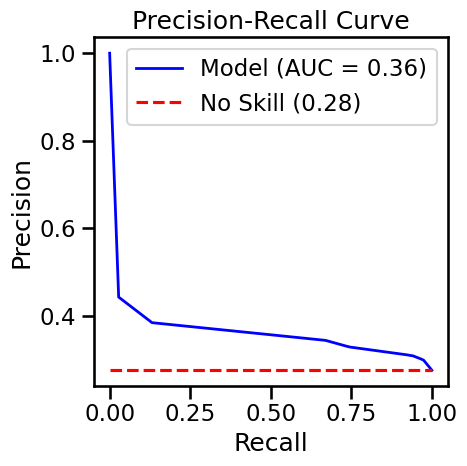

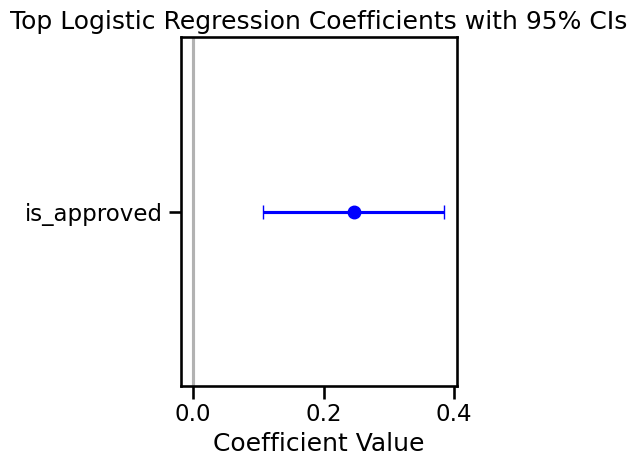

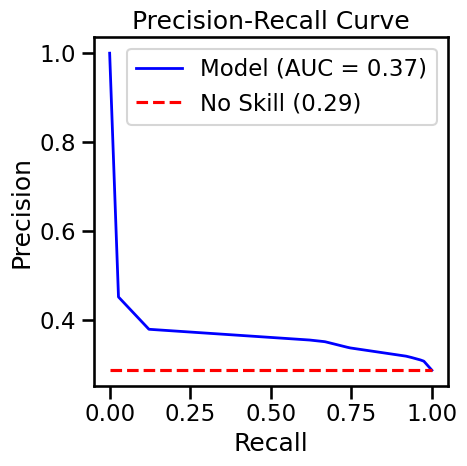

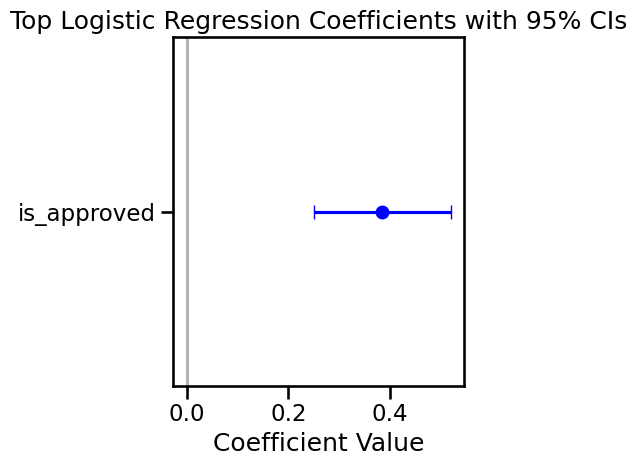

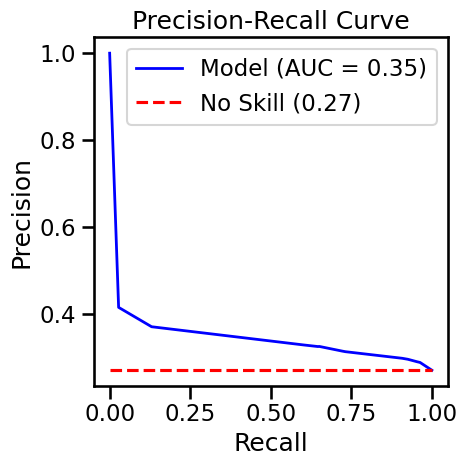

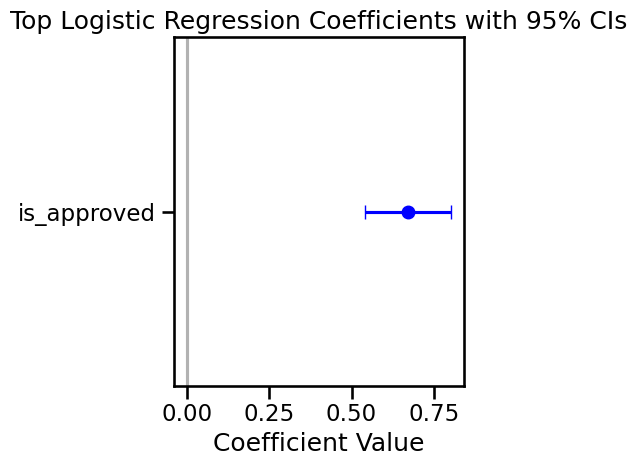

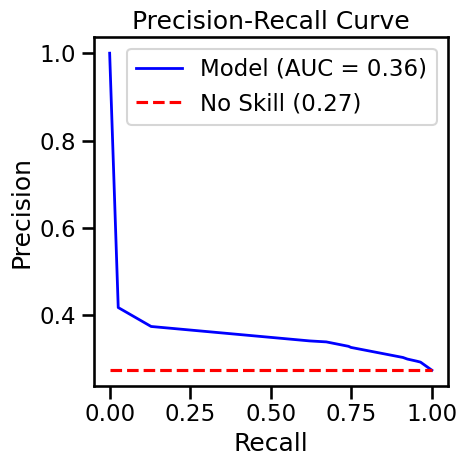

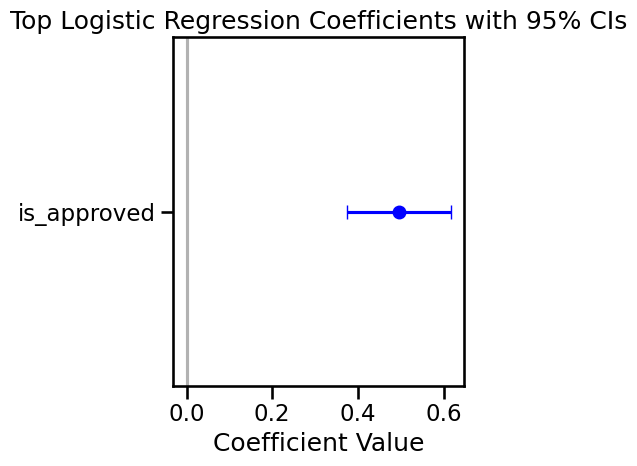

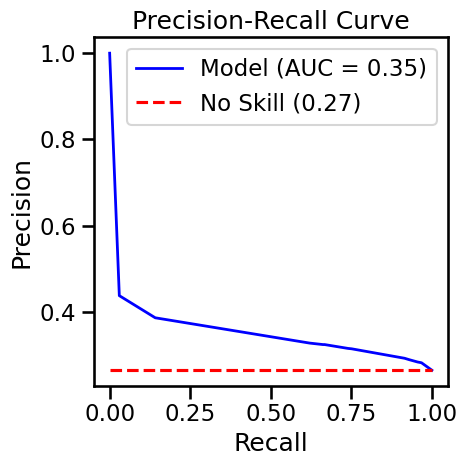

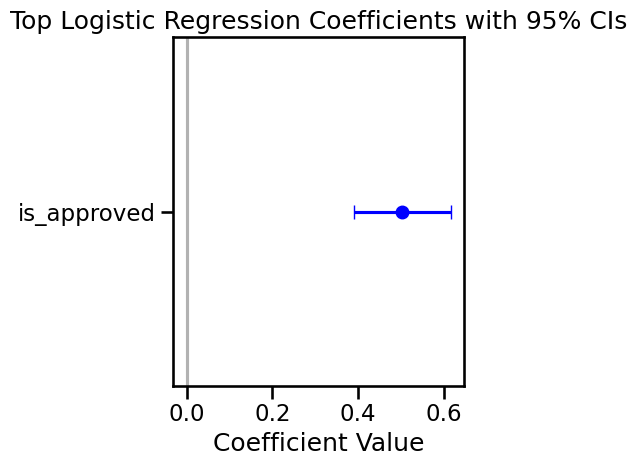

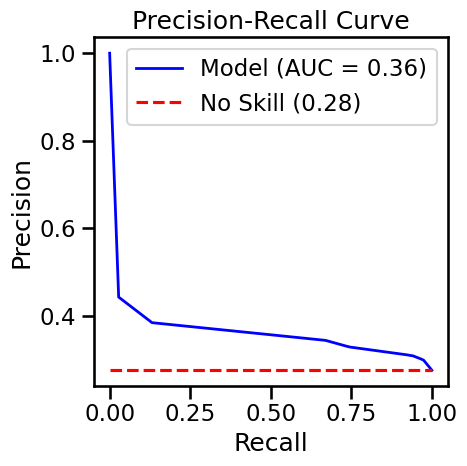

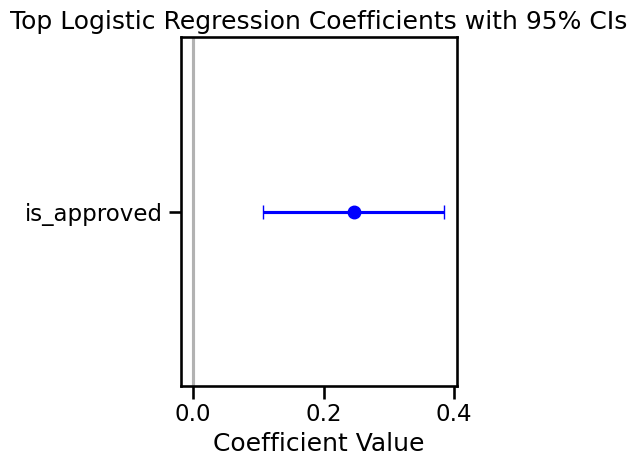

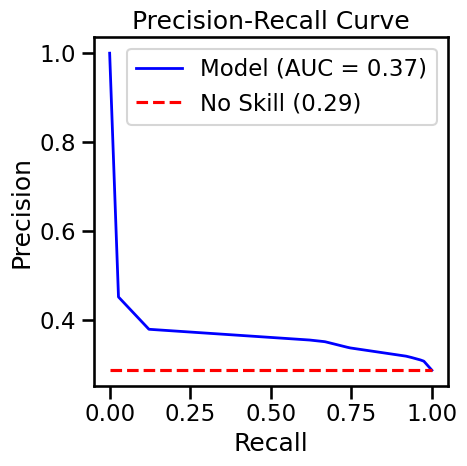

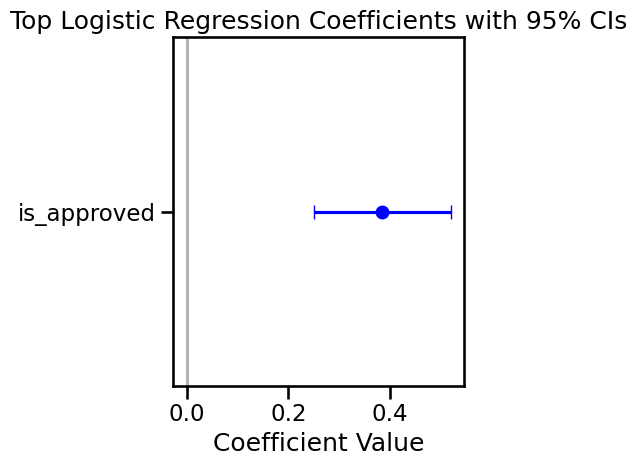

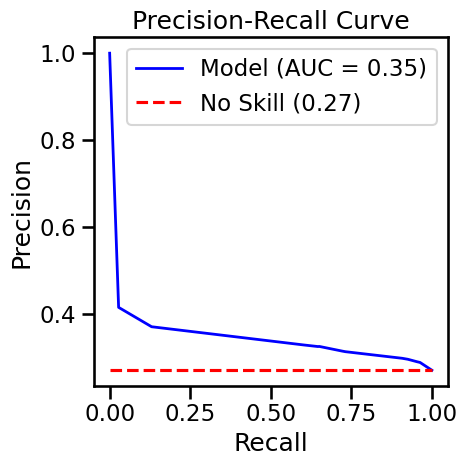

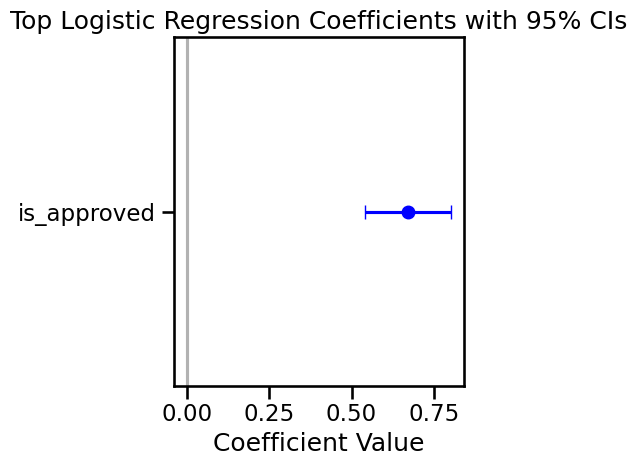

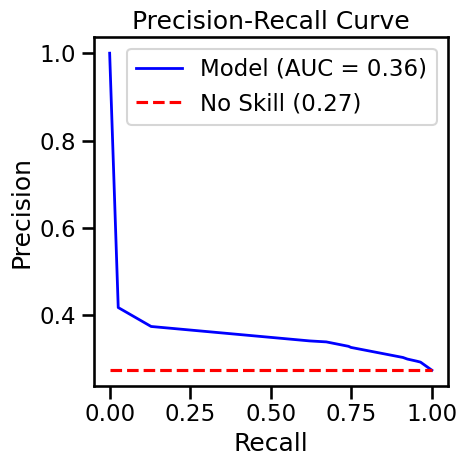

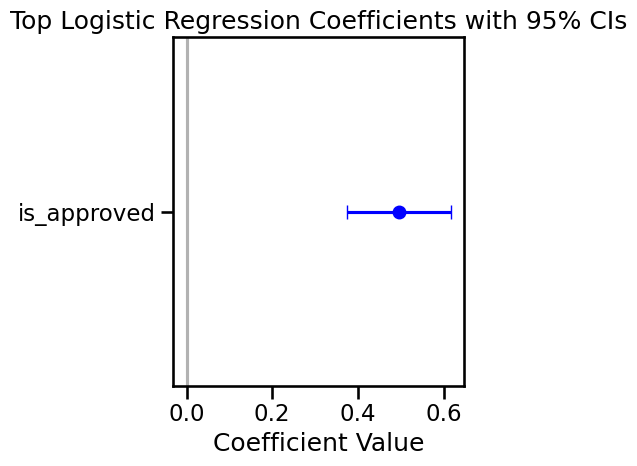

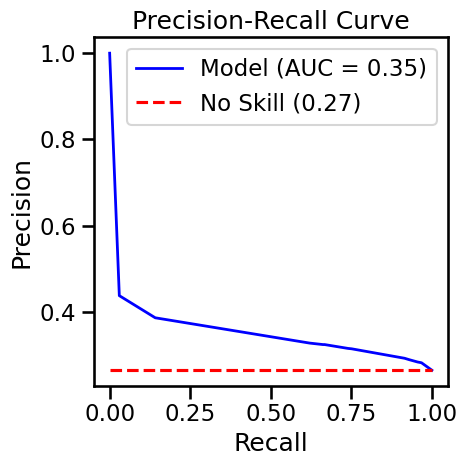

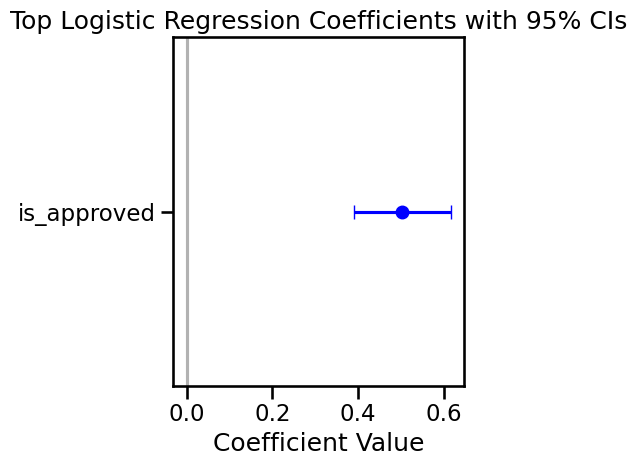

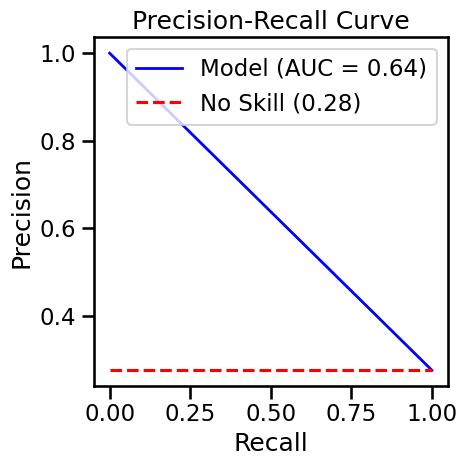

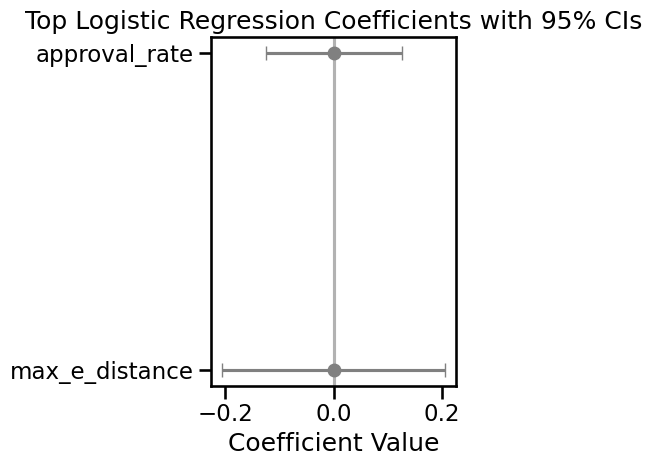

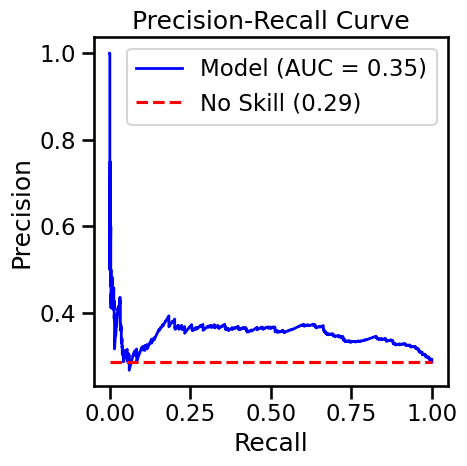

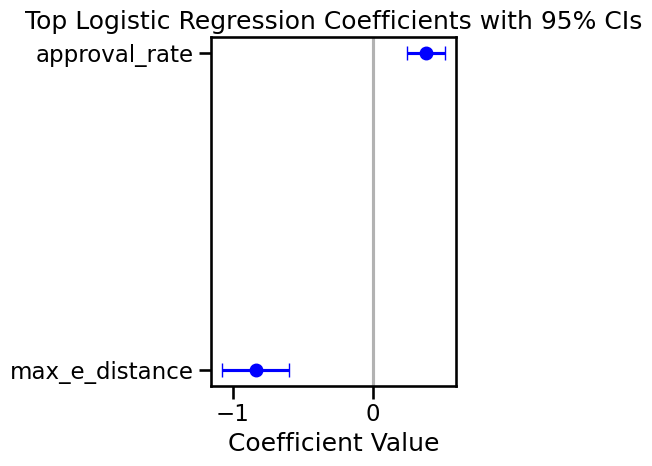

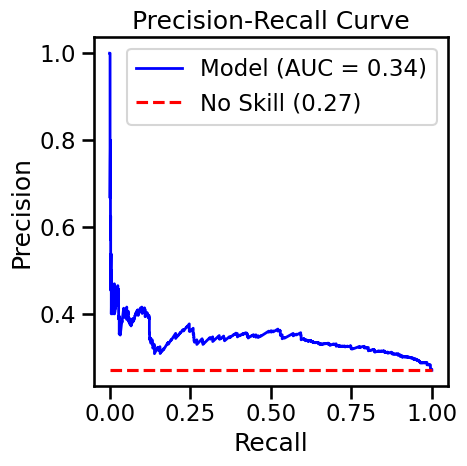

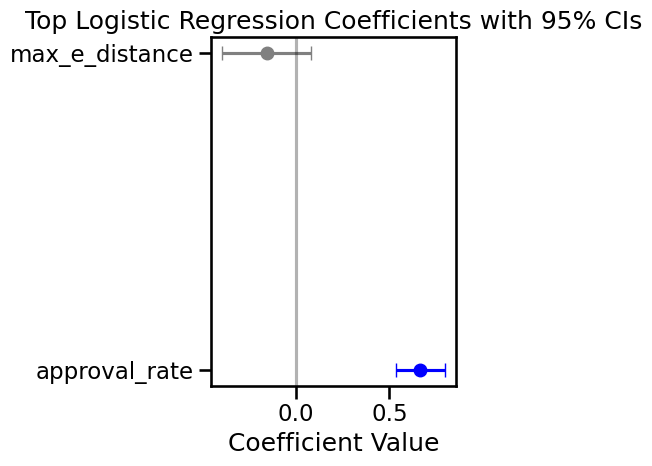

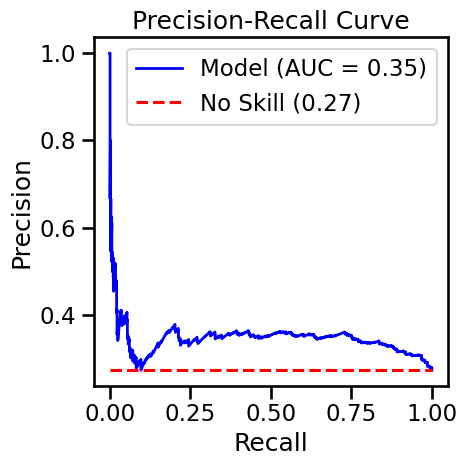

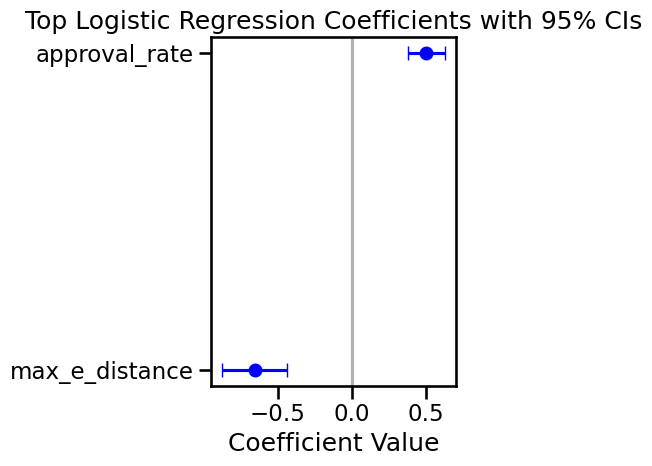

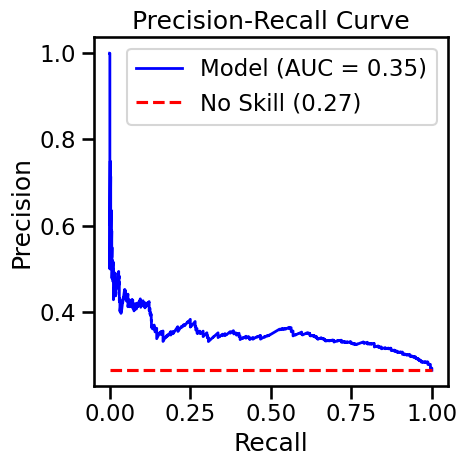

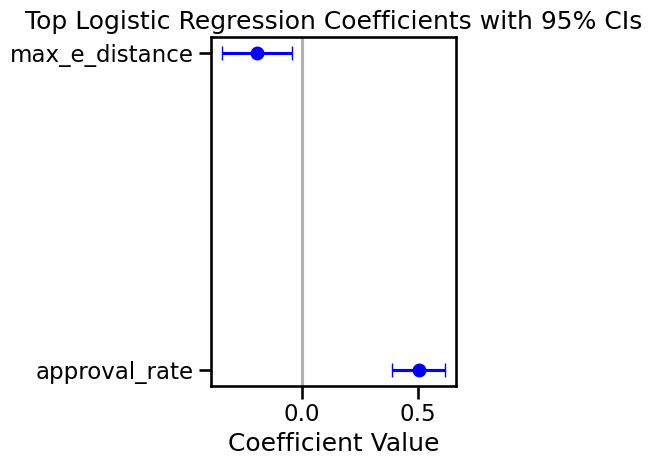

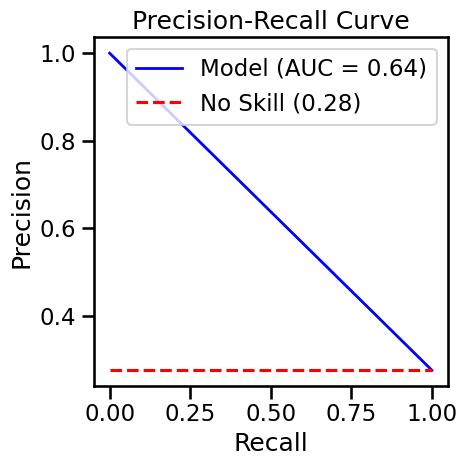

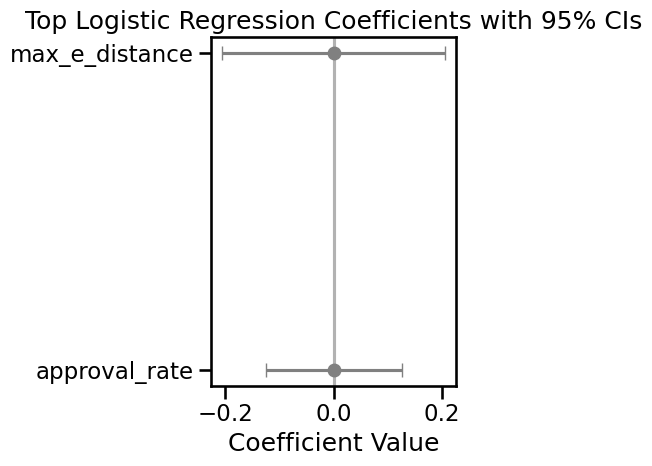

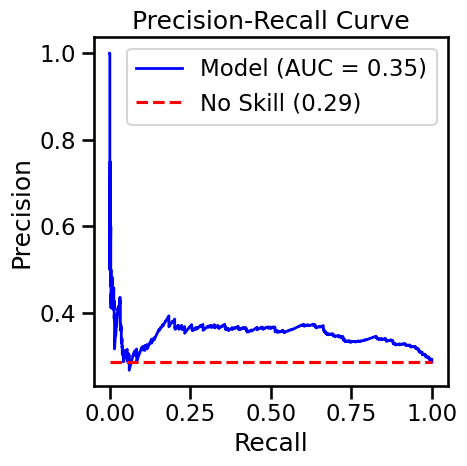

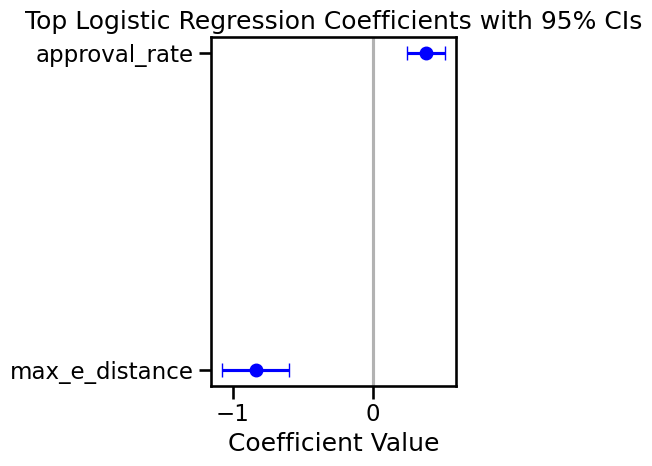

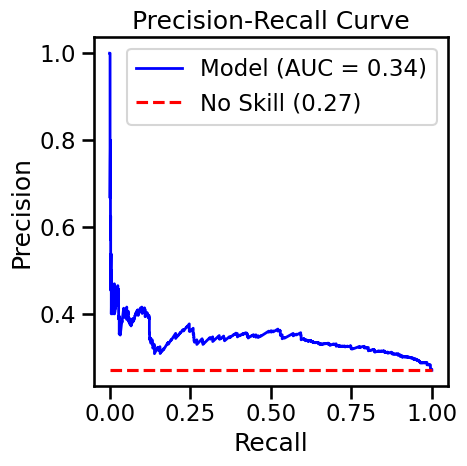

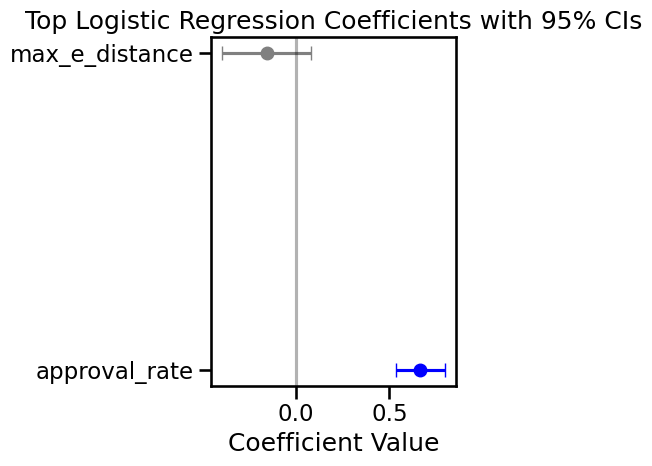

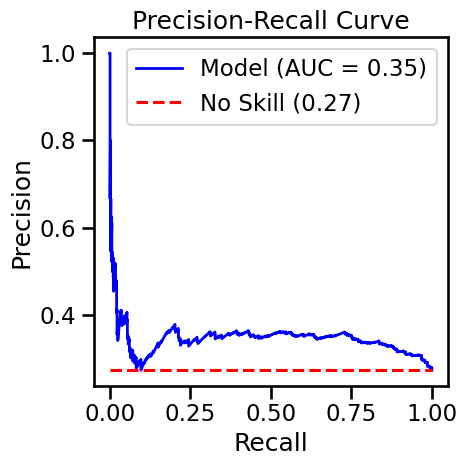

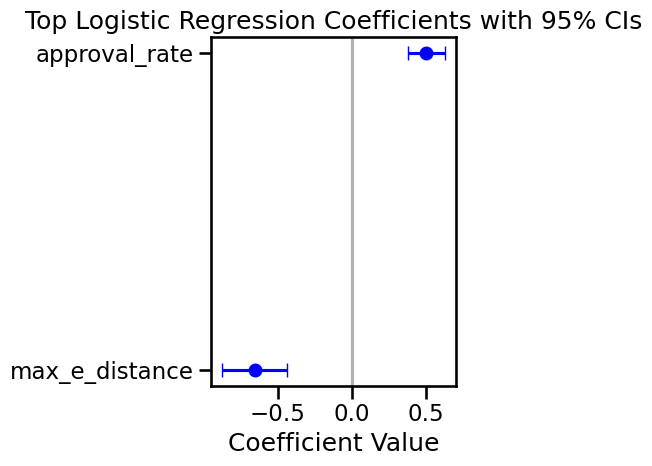

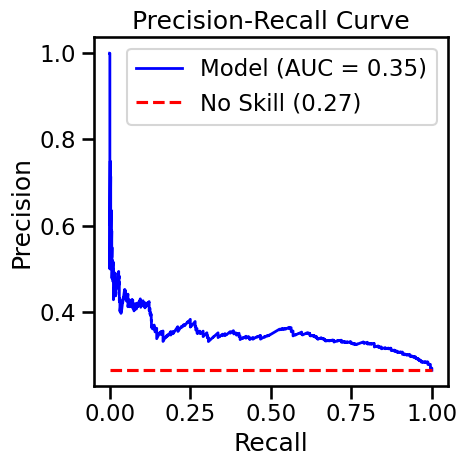

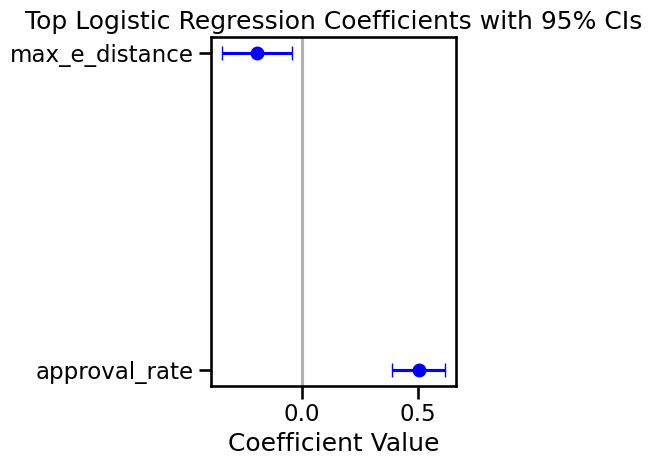

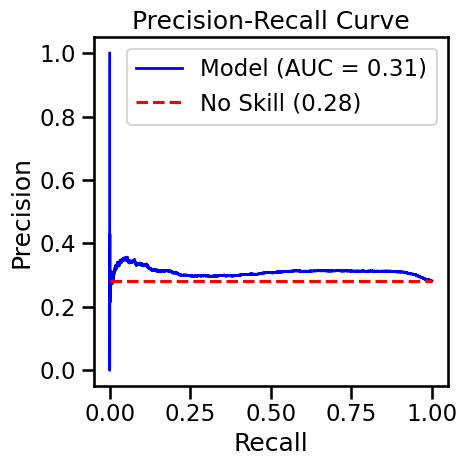

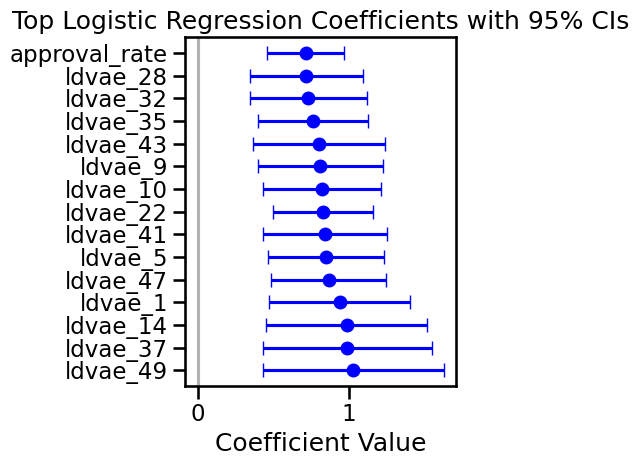

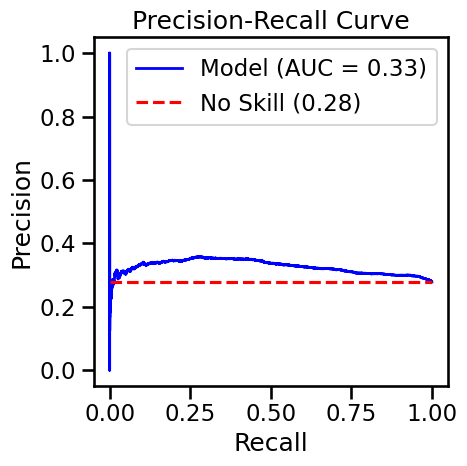

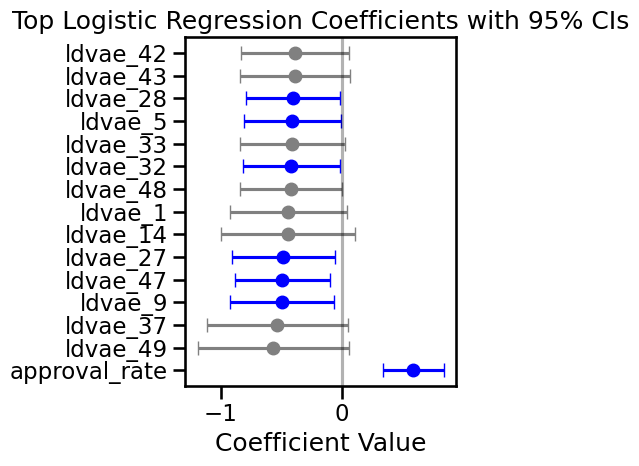

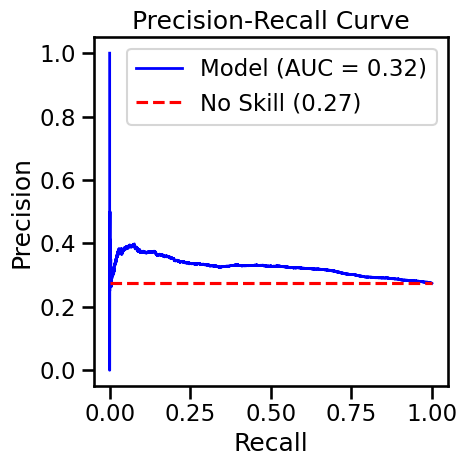

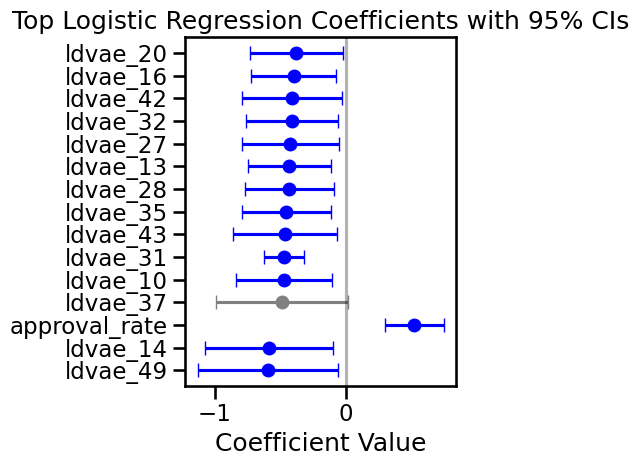

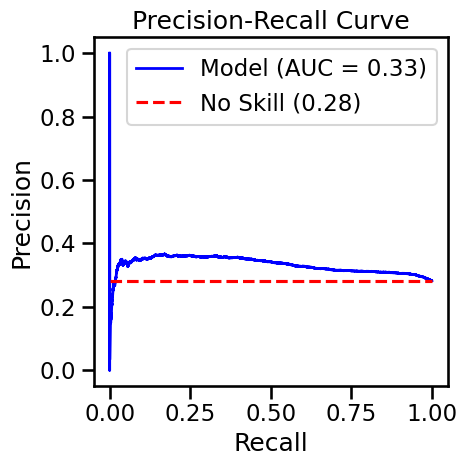

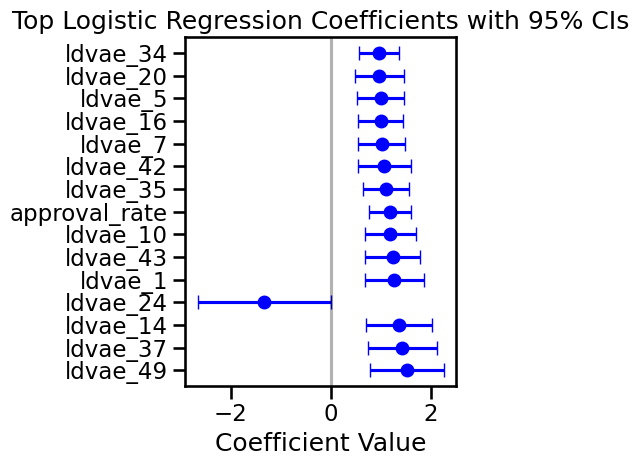

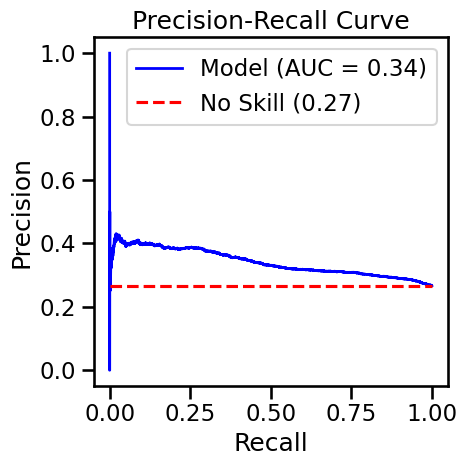

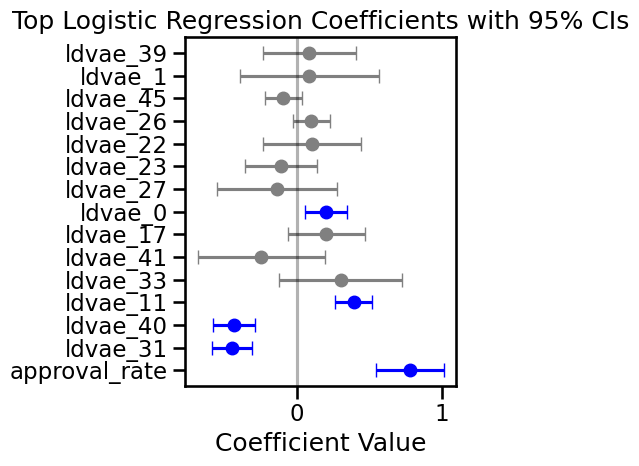

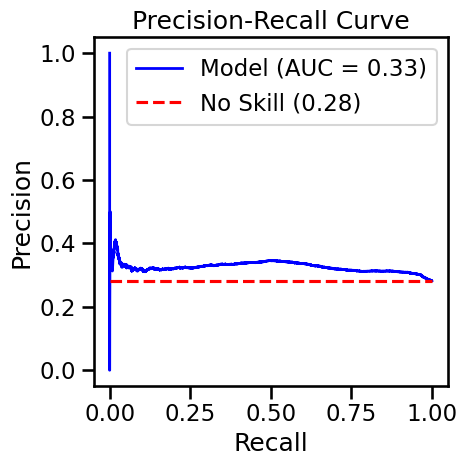

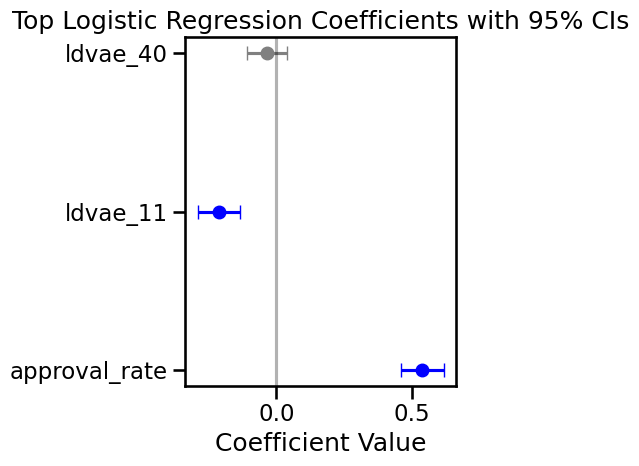

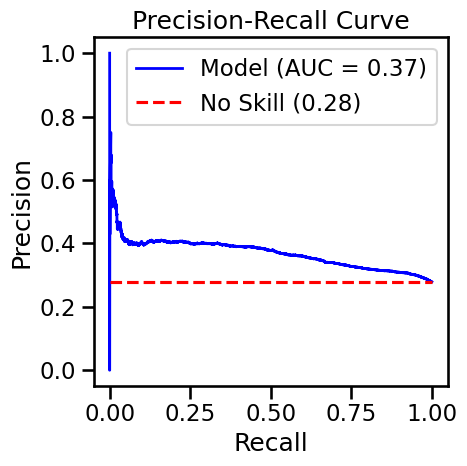

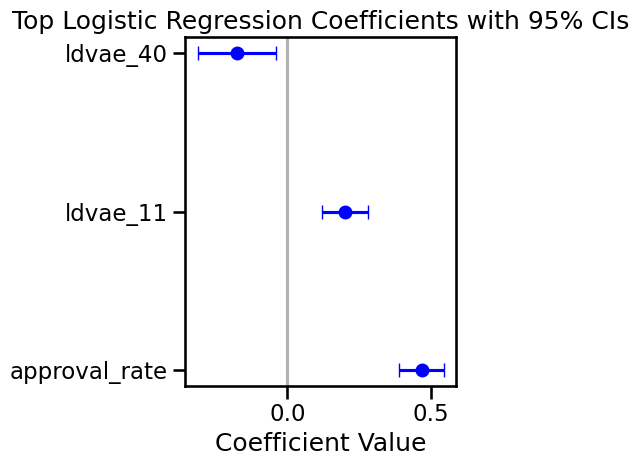

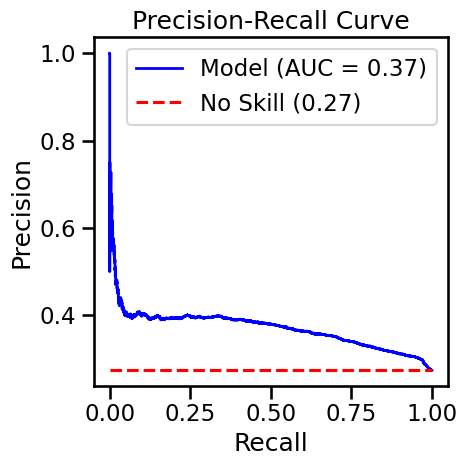

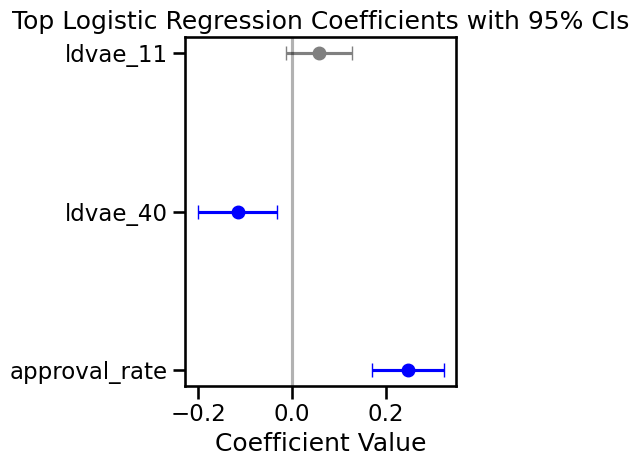

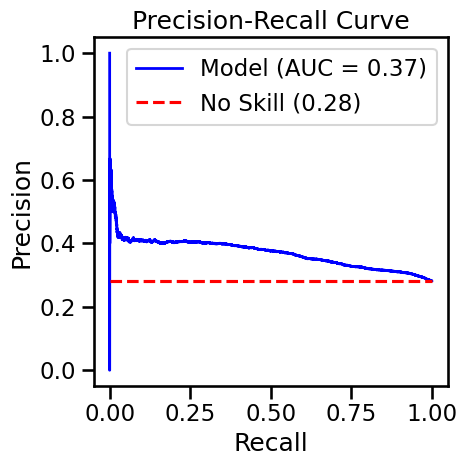

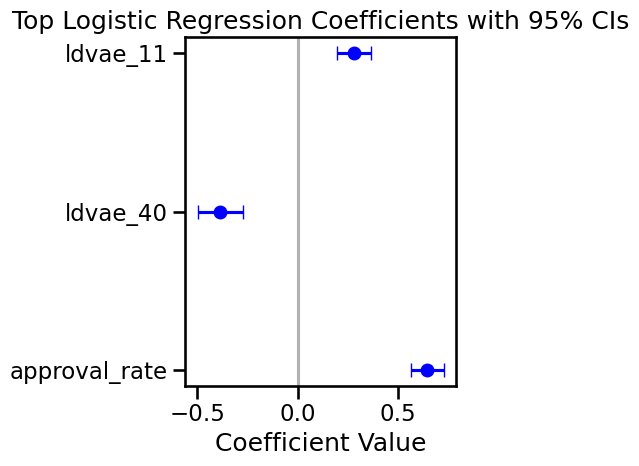

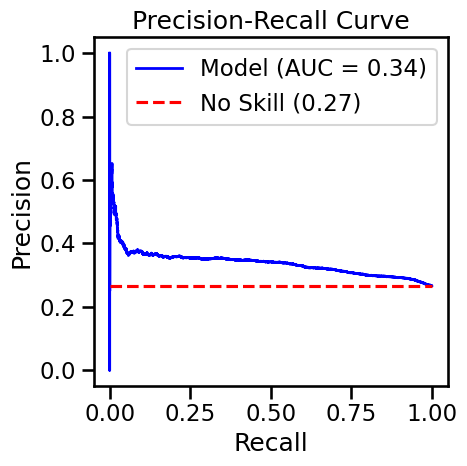

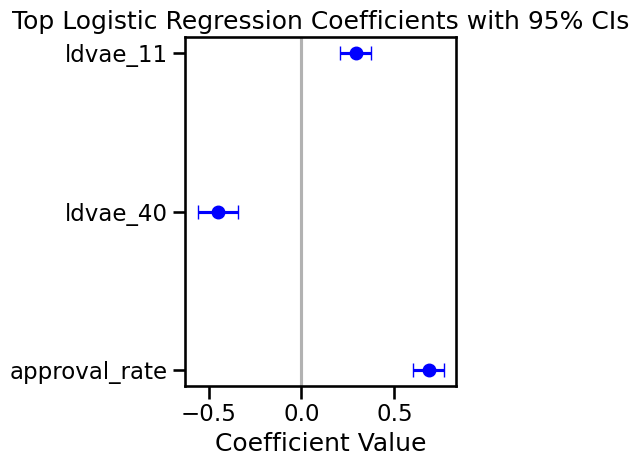

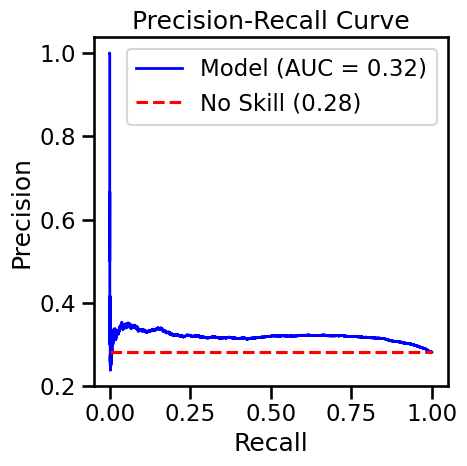

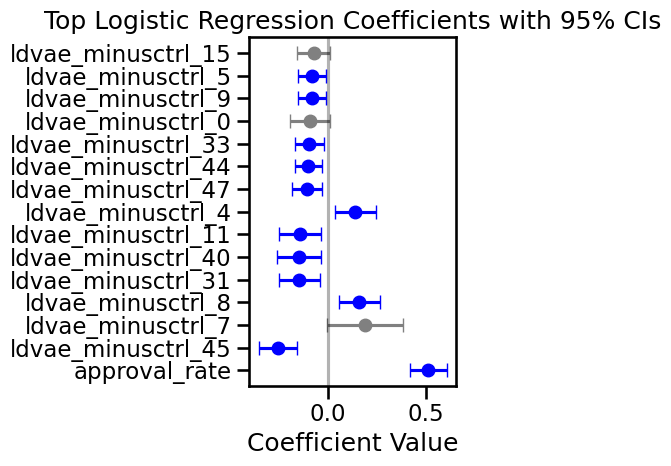

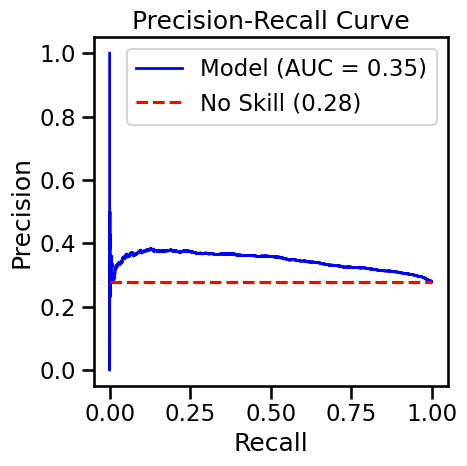

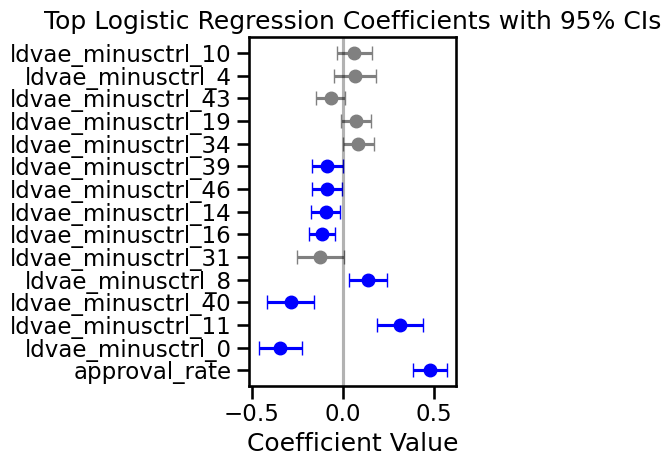

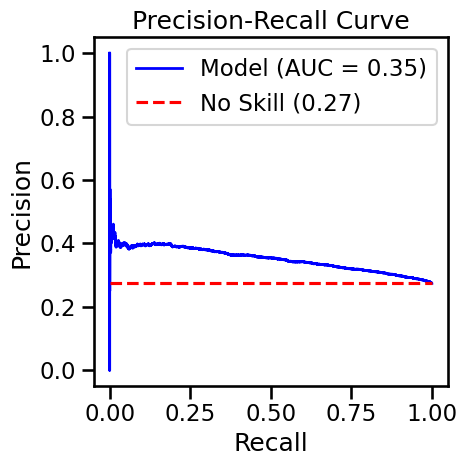

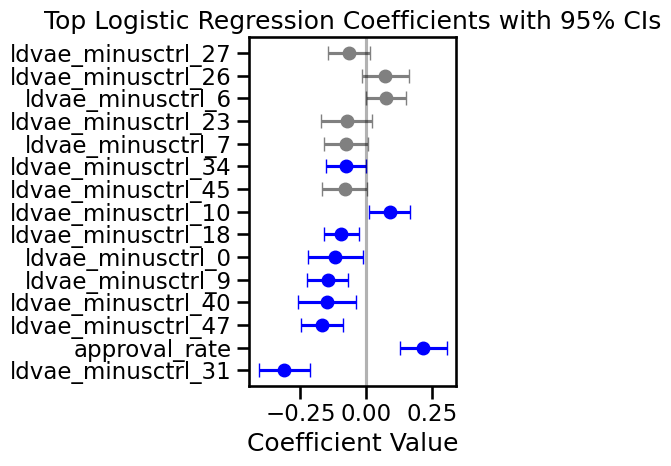

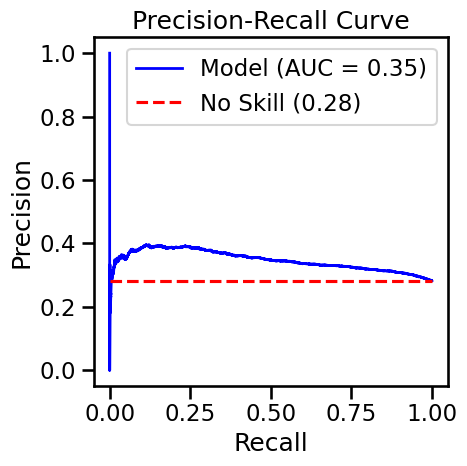

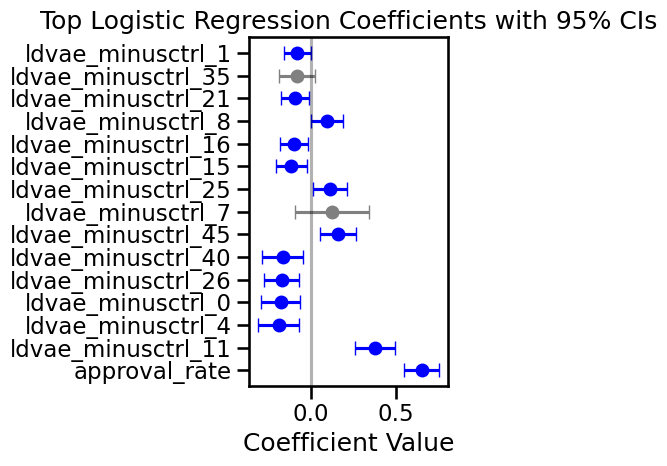

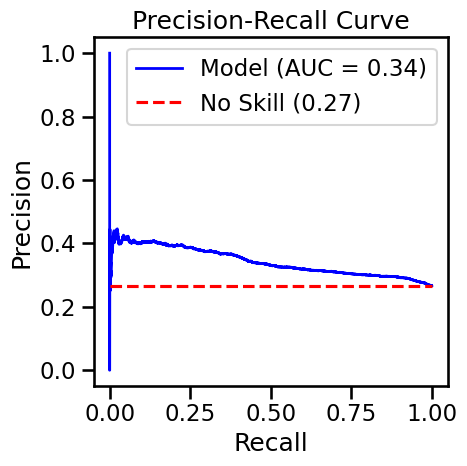

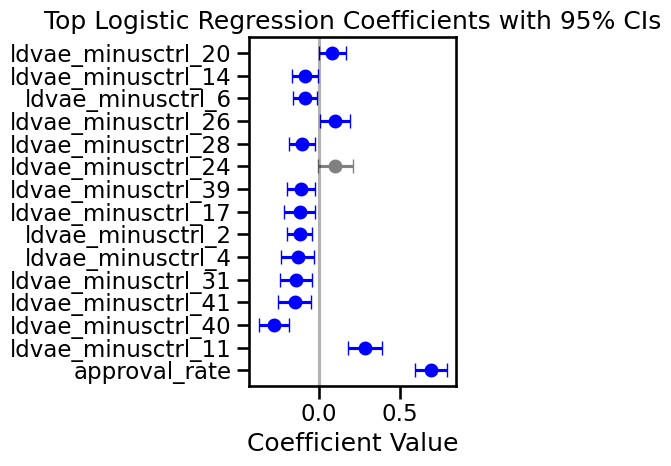

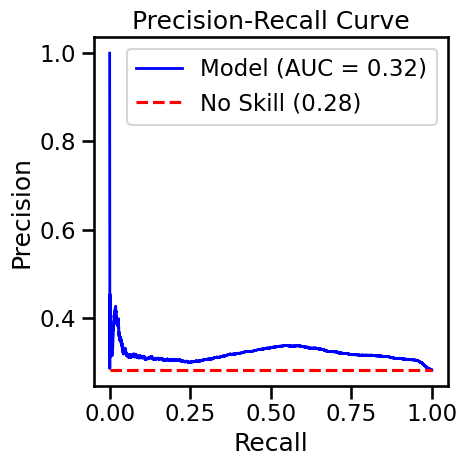

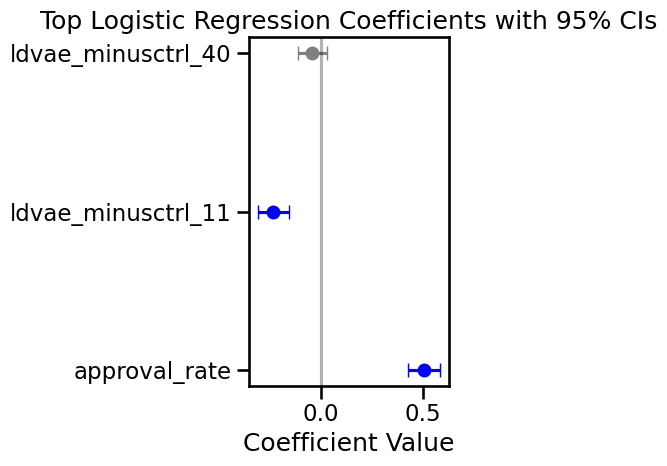

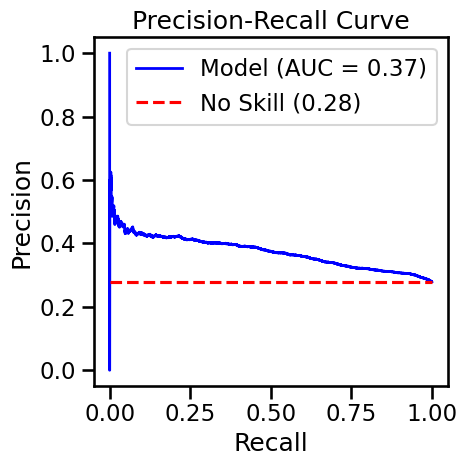

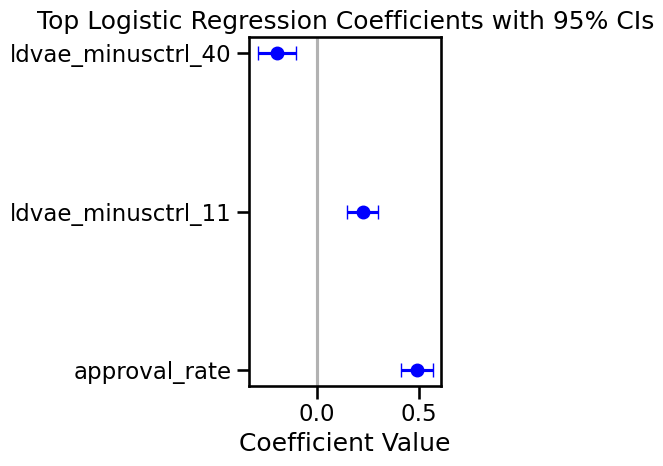

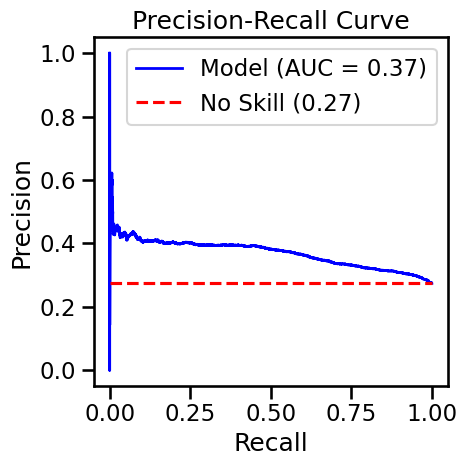

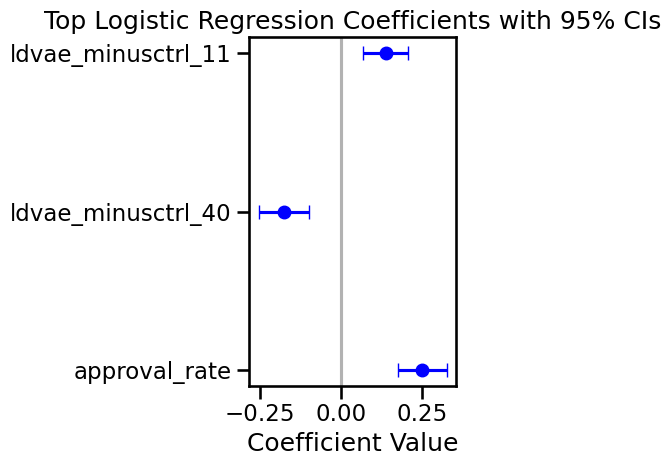

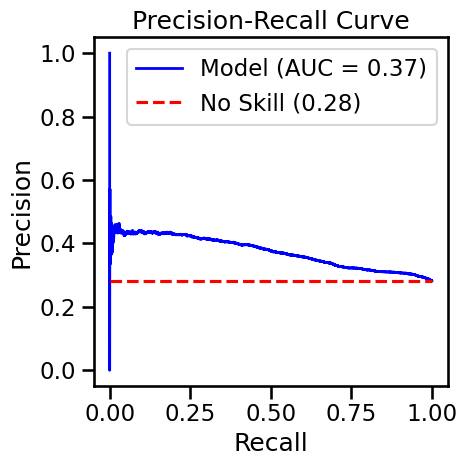

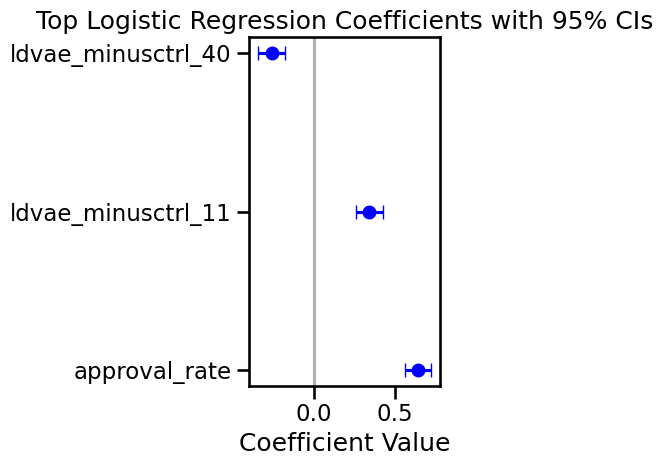

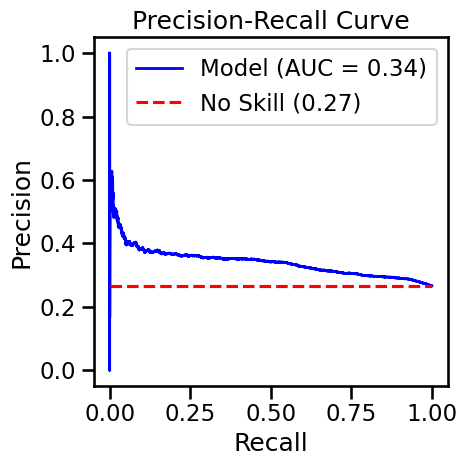

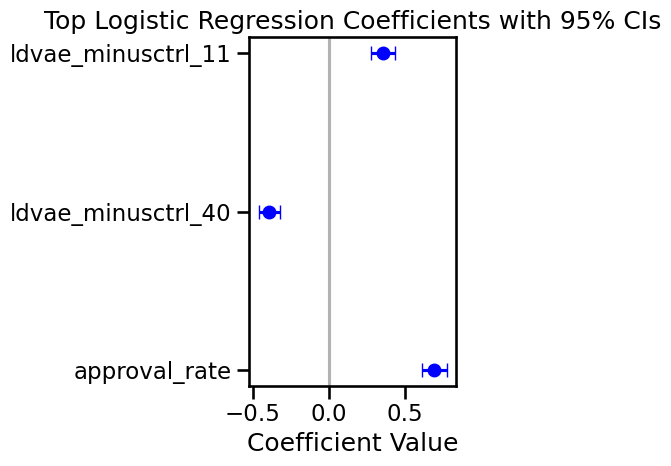

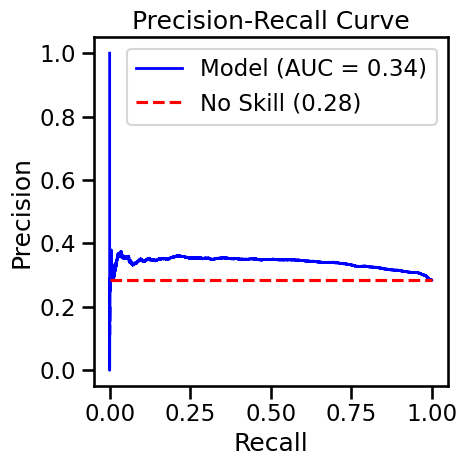

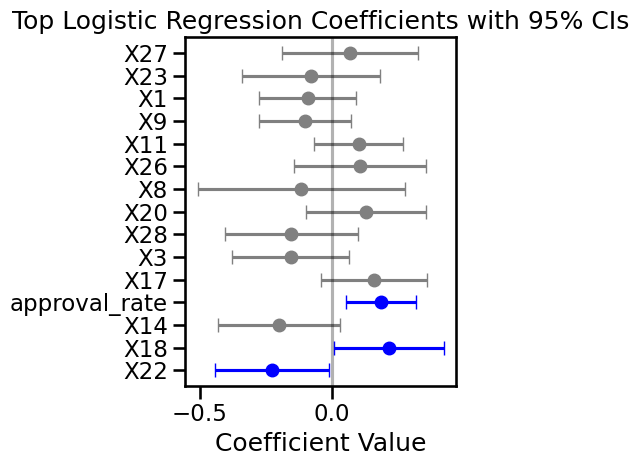

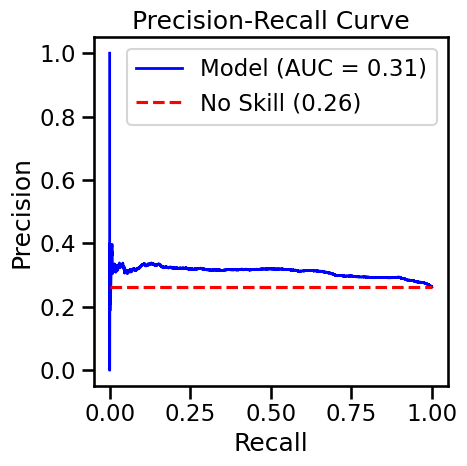

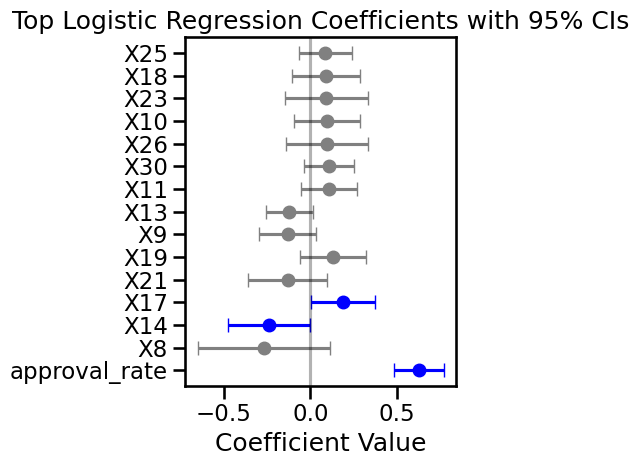

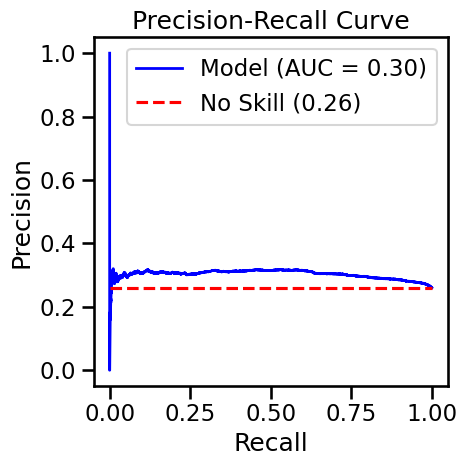

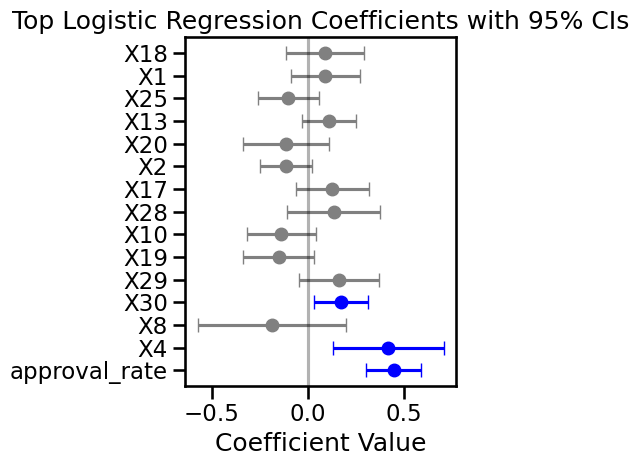

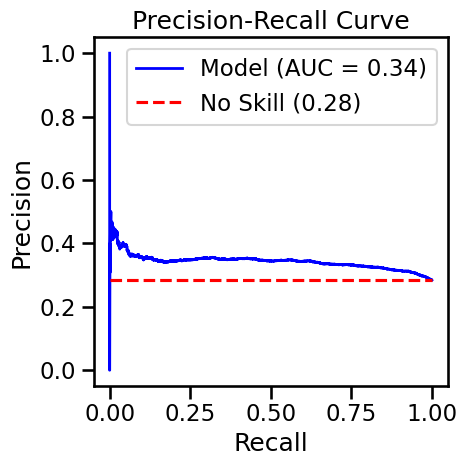

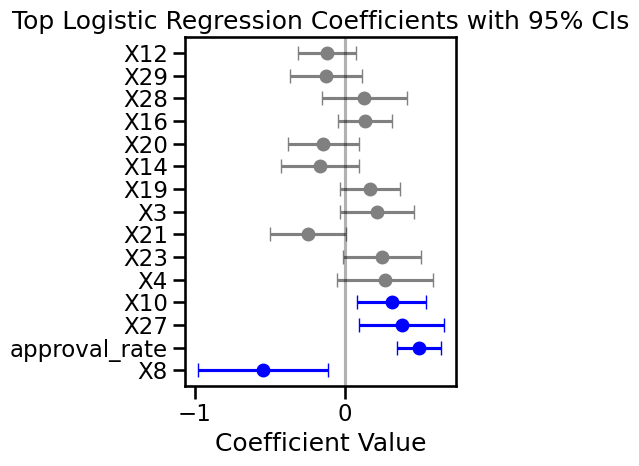

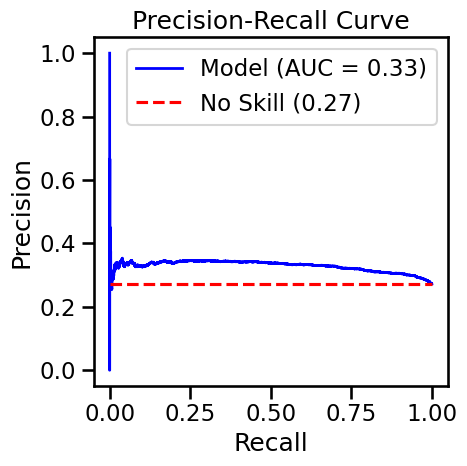

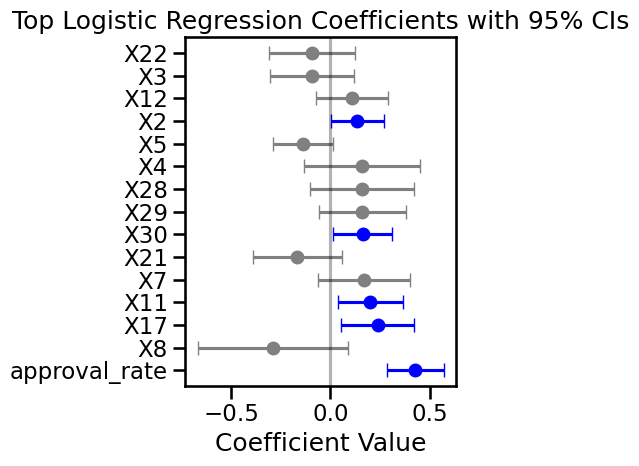

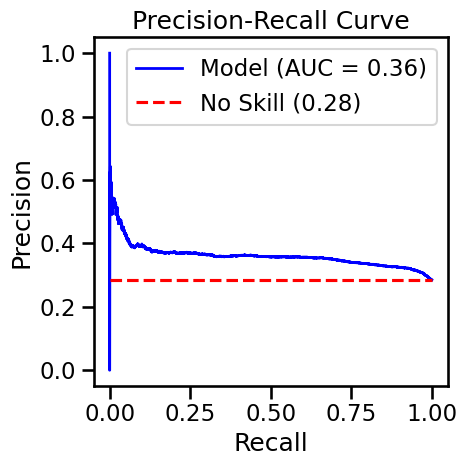

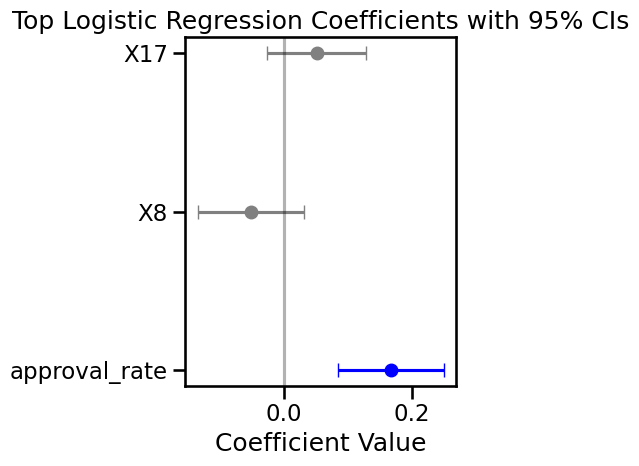

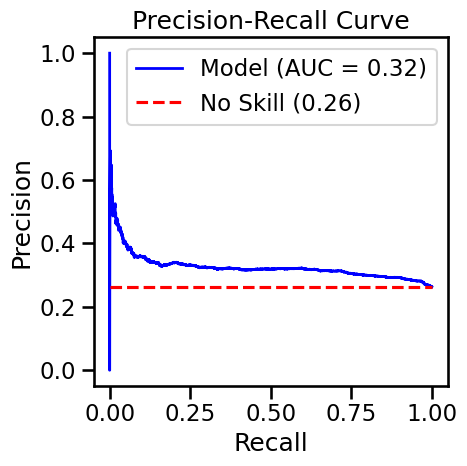

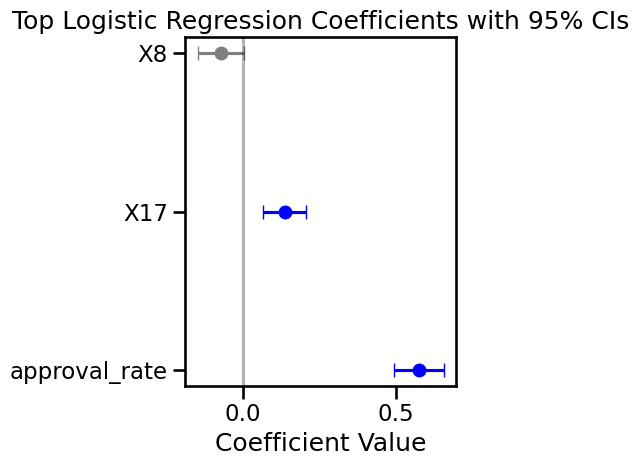

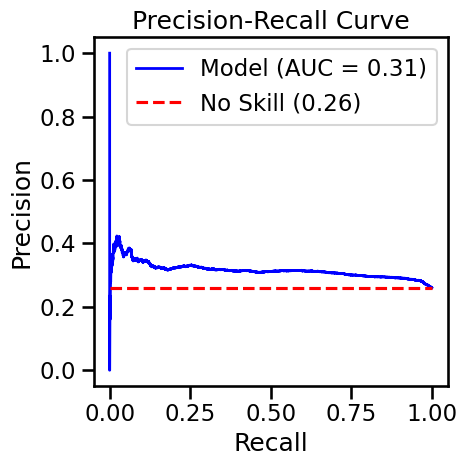

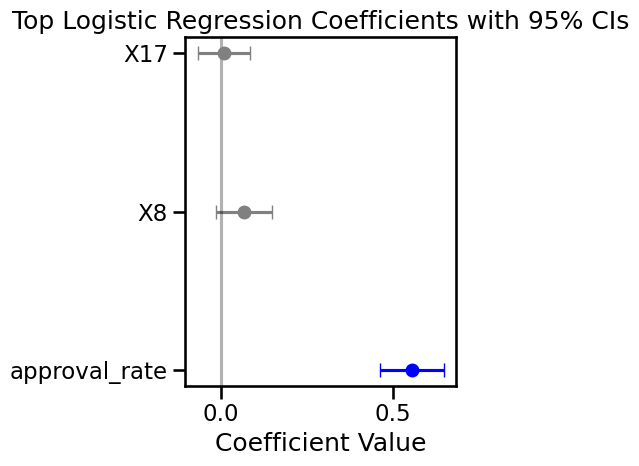

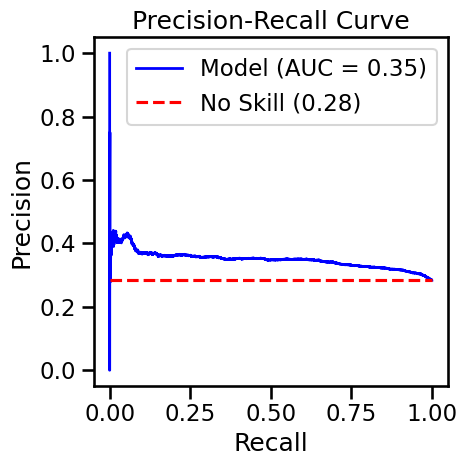

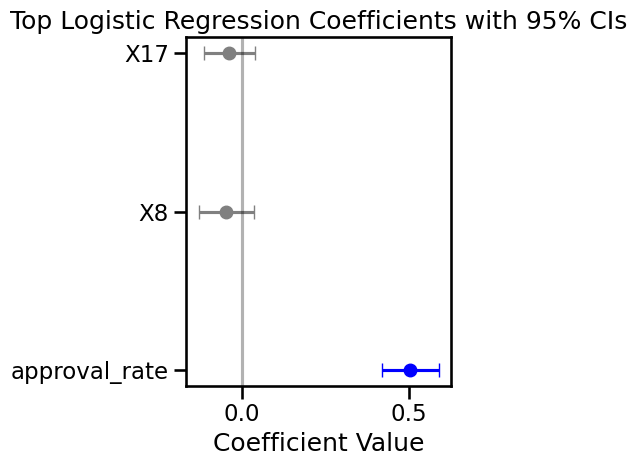

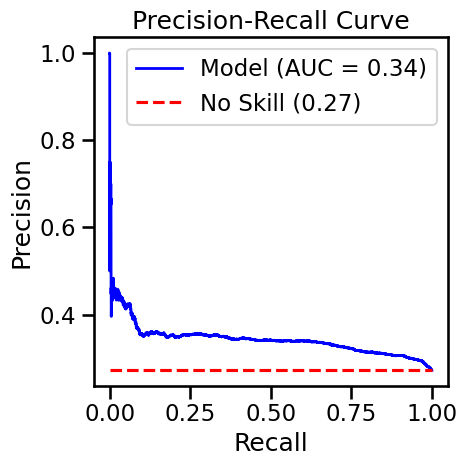

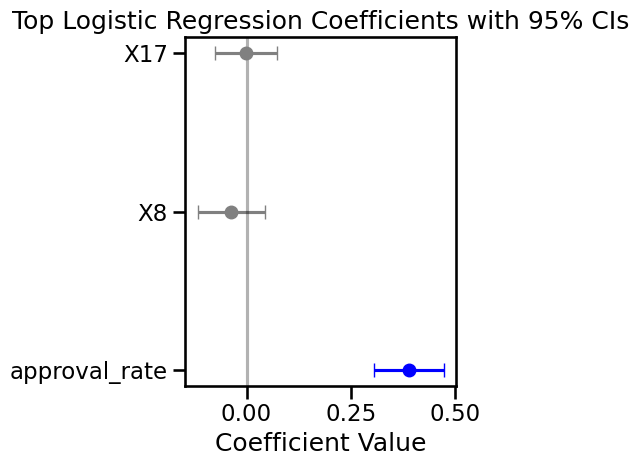

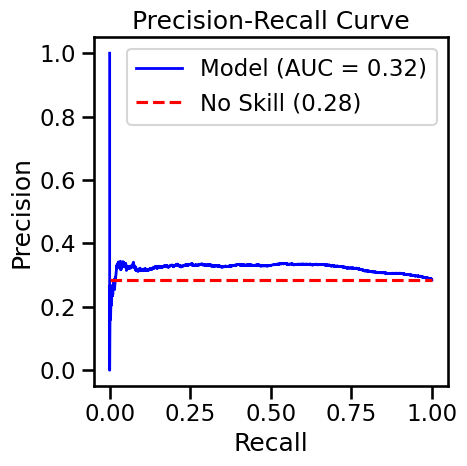

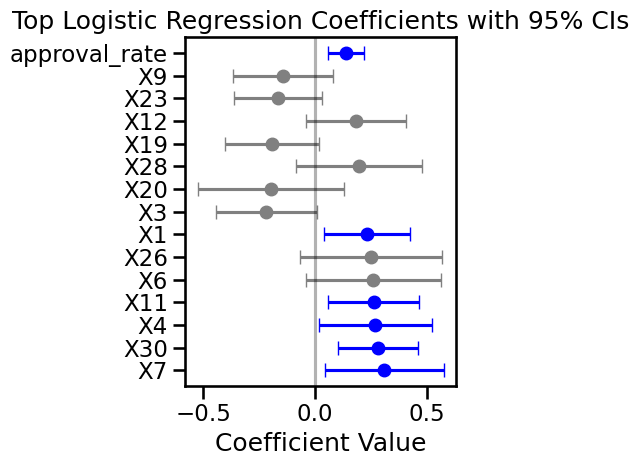

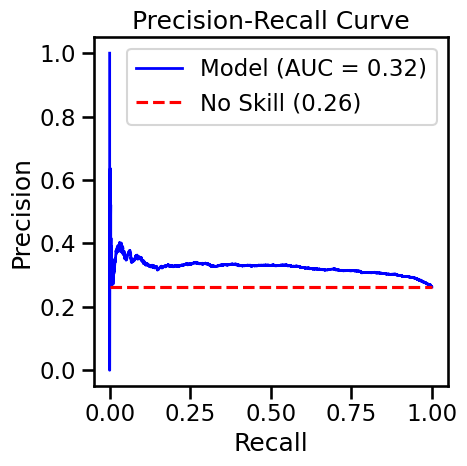

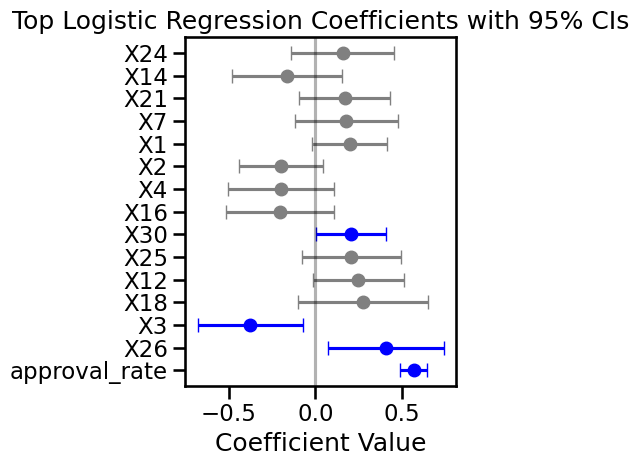

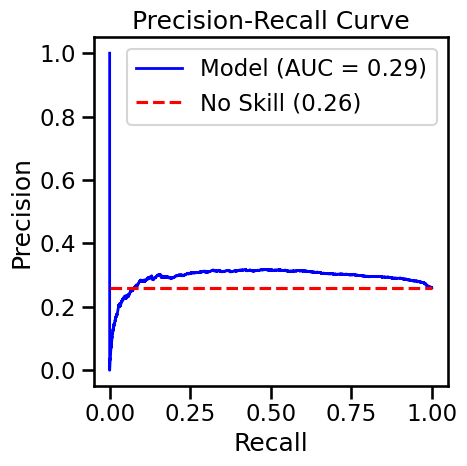

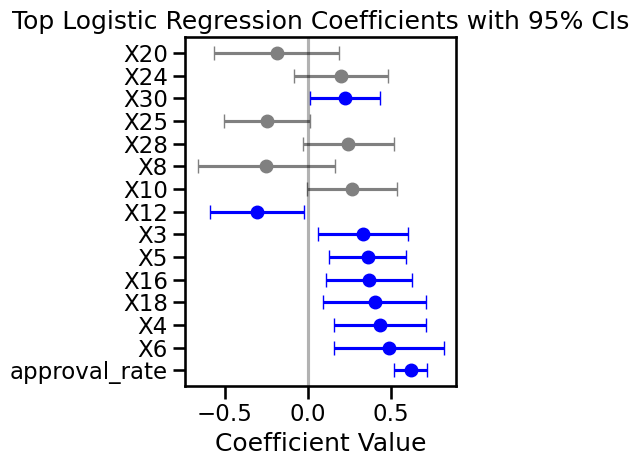

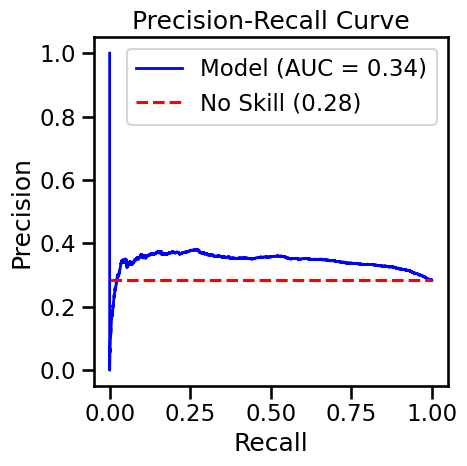

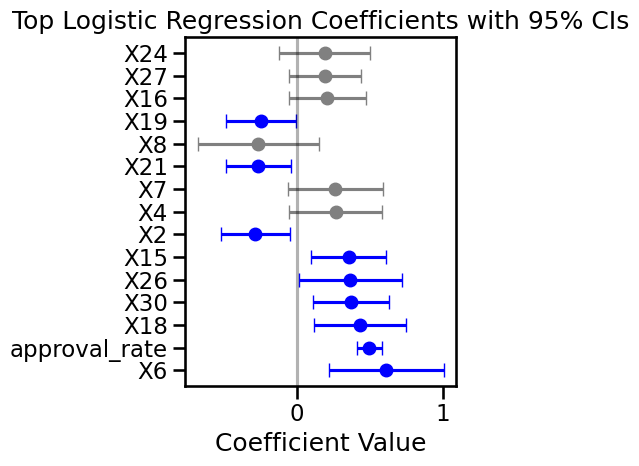

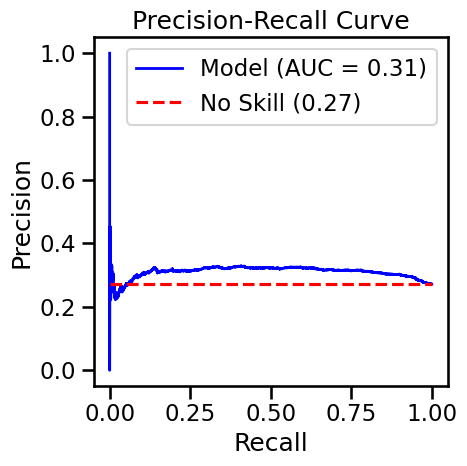

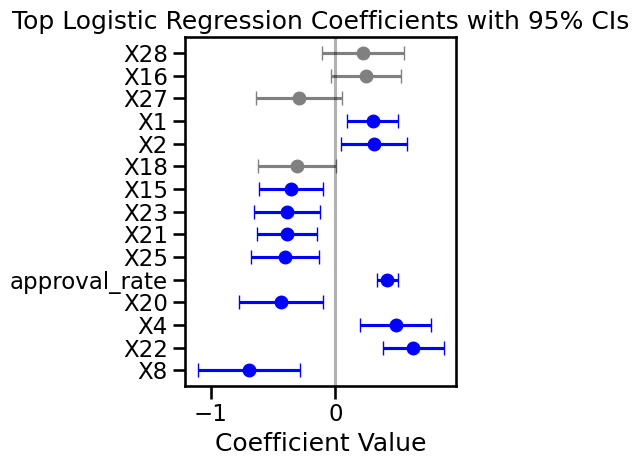

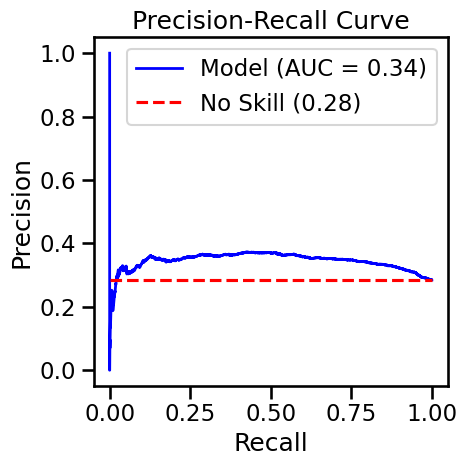

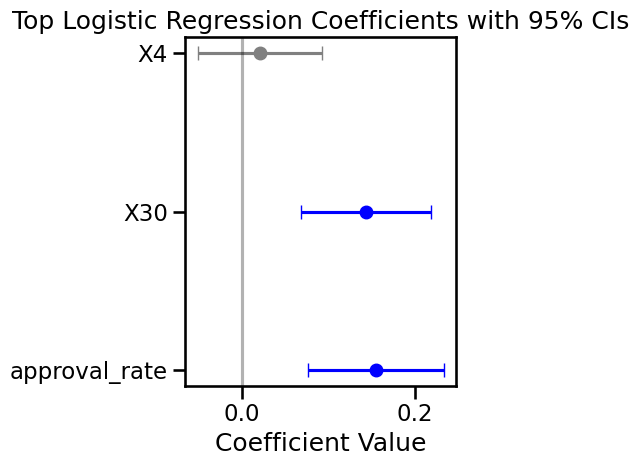

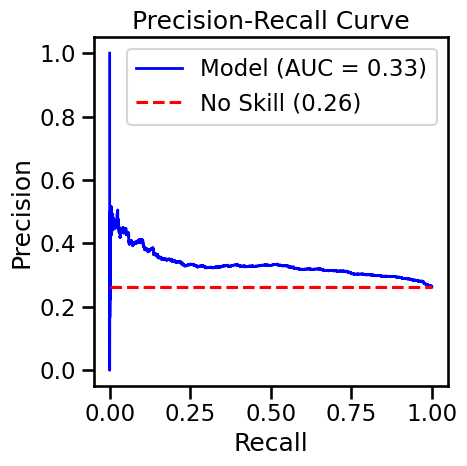

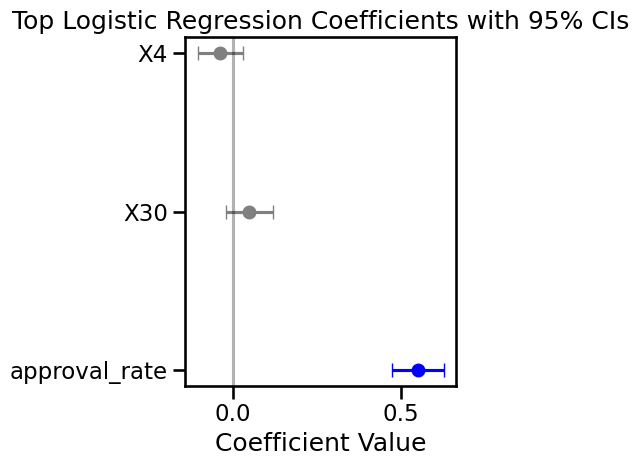

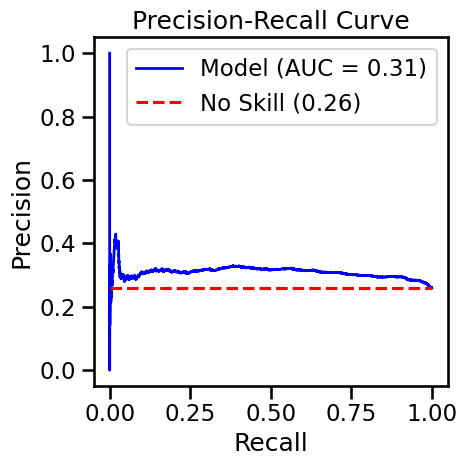

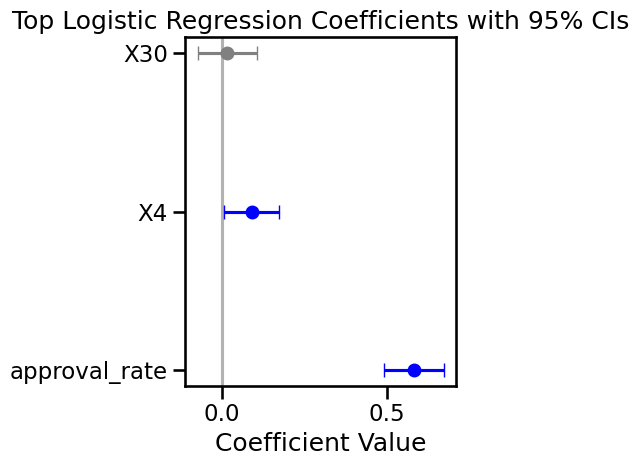

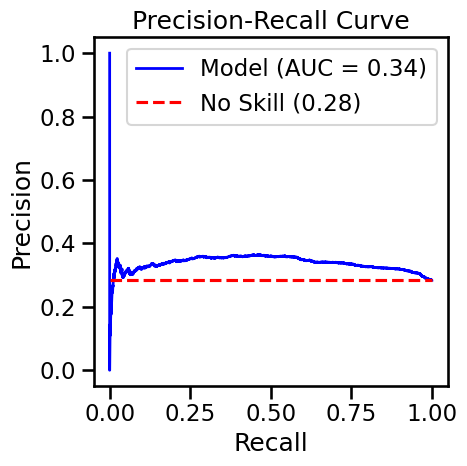

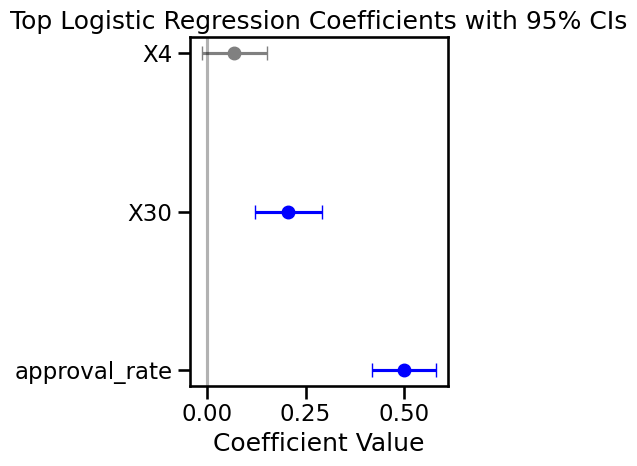

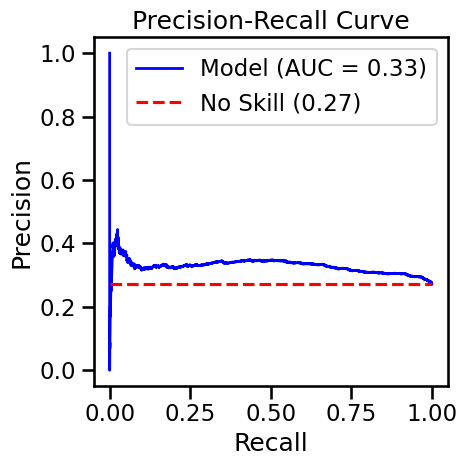

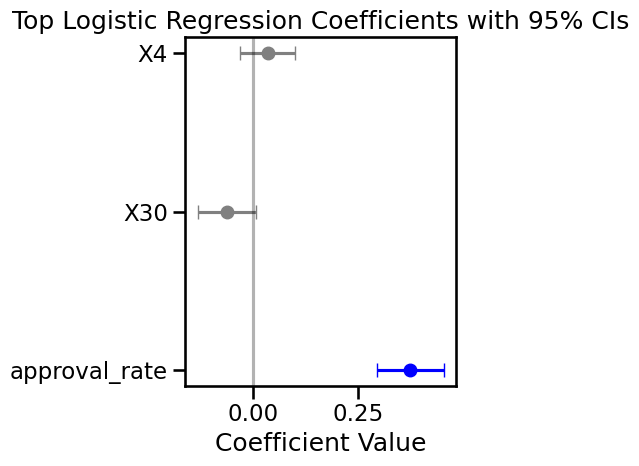

In [90]:
all_results_df = pd.DataFrame()
for k,input_features in test_features.items():
    outcomes = long_approved_df[['is_approved', 'drug_organ']]

    common_drug_organ = np.intersect1d(input_features['drug_organ'].unique(), outcomes['drug_organ'].unique())

    input_features = input_features[input_features['drug_organ'].isin(common_drug_organ)]

    drug_organ_vec = input_features['drug_organ']
    outcomes = outcomes.set_index('drug_organ').loc[drug_organ_vec]
    outcomes.index = input_features.index

    # Convert indices to drug-cell_line
    assert outcomes.shape[0] == input_features.shape[0]
    X = input_features.drop('drug_organ', axis=1)
    y = outcomes.copy()

    # Initialize a results dataframe to store metrics for each split
    results_df = pd.DataFrame(columns=['split_seed', 'pr_auc', 'accuracy', 'pr_auc_baseline', 'n_samples'])
    
    # Initialize a dataframe to store coefficients across splits
    all_coefficients_df = pd.DataFrame()
    
    # Dictionary to track feature z-scores across splits
    feature_zscore_dict = {}
    
    for s in [432, 43, 5235, 332, 2132]:
        X_train, X_test, y_train, y_test = prepare_data(X, y, split_seed=s)    
        lr_model = train_linear_model(X_train, y_train, alpha=0.001)    

        lr_pred, lr_prob, pr_auc, pr_auc_baseline = evaluate_model(lr_model, X_test, y_test)    
        coef_df = analyze_coefficients(lr_model, X_train.columns)
        
        # Add split seed to coefficient dataframe
        coef_df['split_seed'] = s
        
        # Track feature importance based on absolute z-scores
        for _, row in coef_df.iterrows():
            feature = row['Feature']
            # Skip the constant term
            if feature == 'const':
                continue
            if feature not in feature_zscore_dict:
                feature_zscore_dict[feature] = []
            feature_zscore_dict[feature].append(abs(row['z_value']))
        
        # Save coefficients for this split
        all_coefficients_df = pd.concat([all_coefficients_df, coef_df], ignore_index=True)
        
        # Calculate accuracy for this split
        accuracy = sum(lr_pred == y_test['is_approved']) / len(y_test)
        
        # Store results in the dataframe
        new_row = pd.DataFrame({
            'split_seed': [s],
            'pr_auc': [pr_auc],
            'accuracy': [accuracy],
            'pr_auc_baseline':[pr_auc_baseline],
            'n_samples': [len(y_test)]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Calculate average absolute z-score for each feature
    avg_zscore = {feature: np.mean(scores) for feature, scores in feature_zscore_dict.items()}
    
    # Get top k features based on absolute z-score (excluding 'const')
    top_k = 3  # Define k value here
    top_features = sorted(avg_zscore.items(), key=lambda x: x[1], reverse=True)
    
    # Handle case where there might be fewer than k features
    actual_k = min(top_k, len(top_features))
    top_features = top_features[:actual_k]
    top_feature_names = [f[0] for f in top_features]
    
    print(f"\nTop {actual_k} features for {k} (by absolute z-score):")
    for feature, zscore in top_features:
        print(f"{feature}: {zscore:.4f}")
    
    # Retrain final model using only top k features
    X_topk = X[top_feature_names]
    
    # Initialize a results dataframe for the top k features model
    topk_results_df = pd.DataFrame(columns=['split_seed', 'pr_auc', 'accuracy', 'pr_auc_baseline', 'n_samples'])
    
    # Initialize a dataframe to store coefficients for top k features model
    topk_coefficients_df = pd.DataFrame()
    
    for s in [432, 43, 5235, 332, 2132]:
        X_train, X_test, y_train, y_test = prepare_data(X_topk, y, split_seed=s)    
        lr_model = train_linear_model(X_train, y_train, alpha=0.001)    

        lr_pred, lr_prob, pr_auc, pr_auc_baseline = evaluate_model(lr_model, X_test, y_test)    
        
        # Get coefficients for this split
        coef_df = analyze_coefficients(lr_model, X_train.columns)
        coef_df['split_seed'] = s
        coef_df['model_type'] = f'top{actual_k}'
        topk_coefficients_df = pd.concat([topk_coefficients_df, coef_df], ignore_index=True)
        
        # Calculate accuracy for this split
        accuracy = sum(lr_pred == y_test['is_approved']) / len(y_test)
        
        # Store results in the dataframe
        new_row = pd.DataFrame({
            'split_seed': [s],
            'pr_auc': [pr_auc],
            'accuracy': [accuracy],
            'pr_auc_baseline':[pr_auc_baseline],
            'n_samples': [len(y_test)]
        })
        topk_results_df = pd.concat([topk_results_df, new_row], ignore_index=True)
    
    # Display the results
    print("\nResults with all features across different splits:")
    print(results_df)
    
    print(f"\nResults with top {actual_k} features across different splits:")
    print(topk_results_df)
    
    # Add feature type to both dataframes
    results_df['X_features'] = k
    results_df['model_type'] = 'all_features'
    topk_results_df['X_features'] = k
    topk_results_df['model_type'] = f'top{actual_k}_features'
    all_coefficients_df['X_features'] = k
    all_coefficients_df['model_type'] = 'all_features'
    
    # Save to the overall results
    all_results_df = pd.concat([all_results_df, results_df])
    all_results_df = pd.concat([all_results_df, topk_results_df])
    
    # Save coefficients to CSV files
    all_coefficients_df.to_csv(f'coefficients_{k}_all_features.csv', index=False)
    topk_coefficients_df.to_csv(f'coefficients_{k}_top{actual_k}_features.csv', index=False)
    
    # Save top k features list
    topk_features_df = pd.DataFrame({
        'Feature': [f[0] for f in top_features],
        'Importance': [f[1] for f in top_features],
        'Importance_Metric': ['abs_z_score'] * actual_k
    })
    topk_features_df.to_csv(f'top{actual_k}_features_{k}.csv', index=False)

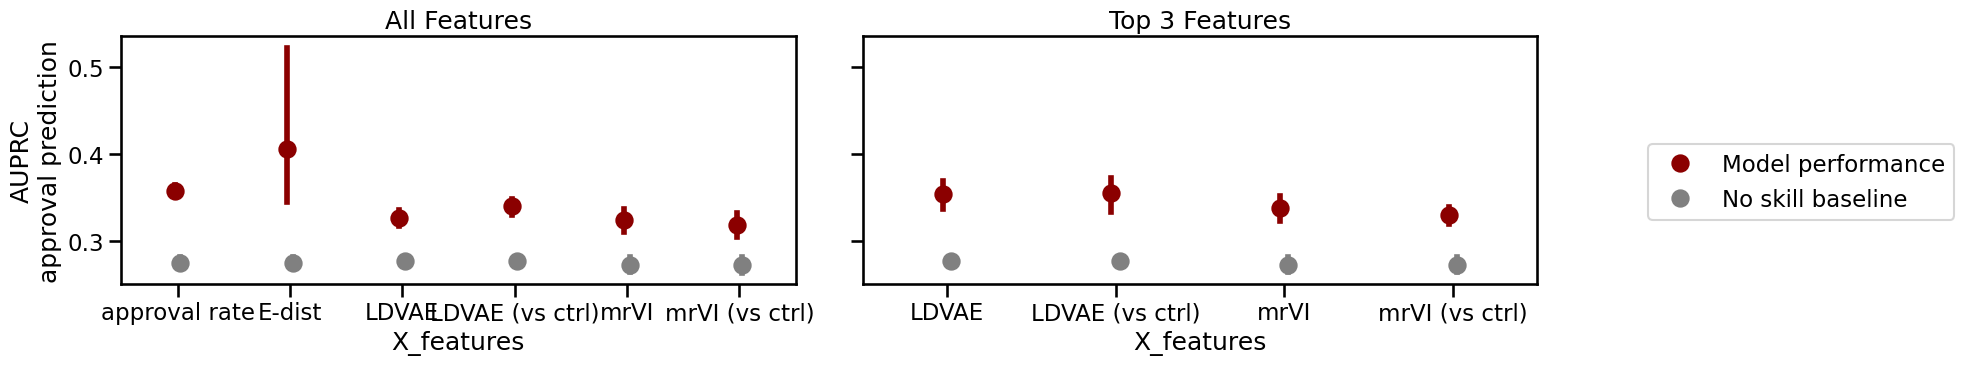

In [91]:
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

# Filter for all_features
all_features_df = all_results_df[all_results_df['model_type'] == 'all_features']
pl_df_all = all_features_df.drop(['accuracy', 'model_type'], axis=1).melt(id_vars=['split_seed', 'n_samples', 'X_features'], var_name='baseline', value_name='AUPRC')
sns.pointplot(
    data=pl_df_all,
    x='X_features', y='AUPRC',
    hue='baseline',
    linestyles='none',
    errorbar=('ci', 95),
    dodge=True,
    palette={'pr_auc_baseline': 'grey', 'pr_auc': 'darkred'},
    ax=ax1
)
ax1.set_title('All Features')
ax1.set_ylabel('AUPRC\napproval prediction')

# Filter for top k features
topk_features_df = all_results_df[all_results_df['model_type'] == f'top{top_k}_features']
pl_df_topk = topk_features_df.drop(['accuracy', 'model_type'], axis=1).melt(id_vars=['split_seed', 'n_samples', 'X_features'], var_name='baseline', value_name='AUPRC')
sns.pointplot(
    data=pl_df_topk,
    x='X_features', y='AUPRC',
    hue='baseline',
    linestyles='none',
    errorbar=('ci', 95),
    dodge=True,
    palette={'pr_auc_baseline': 'grey', 'pr_auc': 'darkred'},
    ax=ax2
)
ax2.set_title(f'Top {top_k} Features')
ax2.set_ylabel('')

# Get the current handles and labels from the first axis
handles, labels = ax1.get_legend_handles_labels()
# Keep only the grey point (pr_auc_baseline) and rename it
grey_handle = handles[labels.index('pr_auc_baseline')]
# Remove legends from both axes
ax1.get_legend().remove()
ax2.get_legend().remove()
# Add a single legend for the figure
fig.legend([handles[labels.index('pr_auc')], grey_handle], 
           ['Model performance', 'No skill baseline'], 
           bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

plt.tight_layout()


In [59]:
all_results_df

split_seed    pr_auc  accuracy  pr_auc_baseline n_samples       X_features  \
0        432  0.362373  0.717932         0.281934     14929            LDVAE   
1         43  0.369139  0.720505         0.279099     15138            LDVAE   
2       5235  0.353900  0.725908         0.274159     14922            LDVAE   
3        332  0.369951  0.716251         0.282379     15334            LDVAE   
4       2132  0.337199  0.701423         0.266724     15038            LDVAE   
0        432  0.363688  0.717932         0.281934     14929            LDVAE   
1         43  0.366831  0.720042         0.279099     15138            LDVAE   
2       5235  0.354305  0.725841         0.274159     14922            LDVAE   
3        332  0.373557  0.717295         0.282379     15334            LDVAE   
4       2132  0.338780  0.701822         0.266724     15038            LDVAE   
0        432  0.346509  0.718132         0.281934     14929  LDVAE (vs ctrl)   
1         43  0.375967  0.720637         0.279099     15138  LDVAE (vs ctrl)   
2       5235  0.359430  0.725707         0.274159     14922  LDVAE (vs ctrl)   
3        332  0.375372  0.717295         0.282379     15334  LDVAE (vs ctrl)   
4       2132  0.336321  0.693443         0.266724     15038  LDVAE (vs ctrl)   
0        432  0.344602  0.718132         0.281934     14929  LDVAE (vs ctrl)   
1         43  0.376834  0.721099         0.279099     15138  LDVAE (vs ctrl)   
2       5235  0.356203  0.725774         0.274159     14922  LDVAE (vs ctrl)   
3        332  0.376250  0.717230         0.282379     15334  LDVAE (vs ctrl)   
4       2132  0.341626  0.700160         0.266724     15038  LDVAE (vs ctrl)   

      model_type  
0   all_features  
1   all_features  
2   all_features  
3   all_features  
4   all_features  
0  top5_features  
1  top5_features  
2  top5_features  
3  top5_features  
4  top5_features  
0   all_features  
1   all_features  
2   all_features  
3   all_features  
4   all_features  
0  top5_features  
1  top5_features  
2  top5_features  
3  top5_features  
4  top5_features

/tmp/ipykernel_99921/3700477978.py:16: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(data=pl_df, x='organ', y='max_e_distance', hue='is_approved',


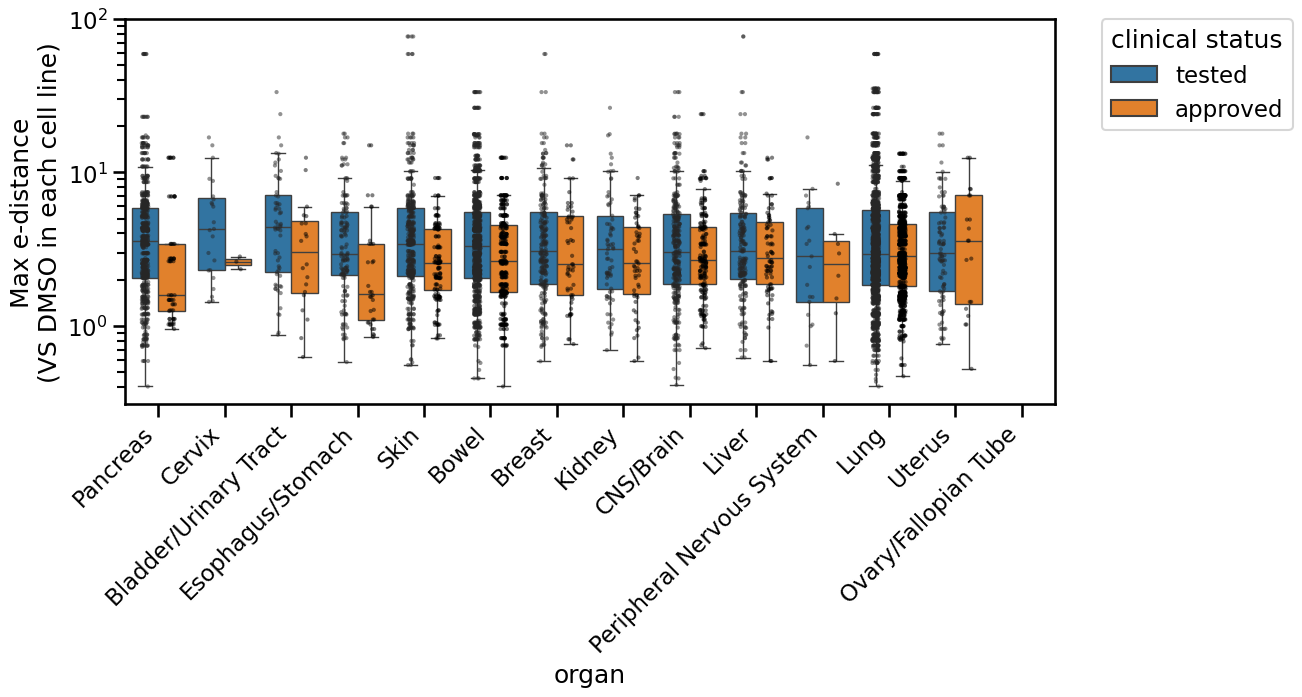

In [212]:
plt.figure(figsize=(12,5))
pl_df = pd.merge(edist_df, long_approved_df, how='right')
pl_df['organ'] = pl_df['organ'].astype(str)

# Calculate the difference in max_e_distance between approved and not approved for each organ
organ_diff = pl_df.groupby(['organ', 'is_approved'])['max_e_distance'].median().unstack()
organ_diff['difference'] = organ_diff[1] - organ_diff[0]  # approved (1) - not approved (0)

# Sort the organs by this difference
organ_order = organ_diff.sort_values('difference').index.tolist()

# Create boxplot without fliers (outliers) with sorted organs
sns.boxplot(data=pl_df, x='organ', y='max_e_distance', hue='is_approved', fliersize=0, 
            order=organ_order);
# Add stripplot with black dots, dodged by hue
sns.stripplot(data=pl_df, x='organ', y='max_e_distance', hue='is_approved', 
              dodge=True, color='black', size=3, alpha=0.5, order=organ_order);
# Set log scale for y-axis
plt.yscale('log')
plt.ylabel('Max e-distance\n(VS DMSO in each cell line)');
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
# Remove duplicate legend from stripplot
handles, labels = plt.gca().get_legend_handles_labels()
# Change legend labels: 0=tested, 1=approved
plt.legend(handles[:2], ['tested', 'approved'], title='clinical status', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Adverse effects

Top cell lines by correlation strength:
   cell_line  correlation   p_value  sample_size
10     _0546    -0.037810  0.516283          297
30     _1693    -0.041145  0.479943          297
16     _1056    -0.041856  0.472383          297
21     _1724    -0.042676  0.463748          297
44     _1731    -0.044184  0.448084          297
31     _0131    -0.044848  0.441281          297
24     _0399    -0.045162  0.438093          297
42     _0397    -0.046183  0.427795          297
36     _0293    -0.046857  0.421079          297
47     _1055    -0.047293  0.416762          297

Overall correlation: -0.0542, p-value: 3.7095e-11


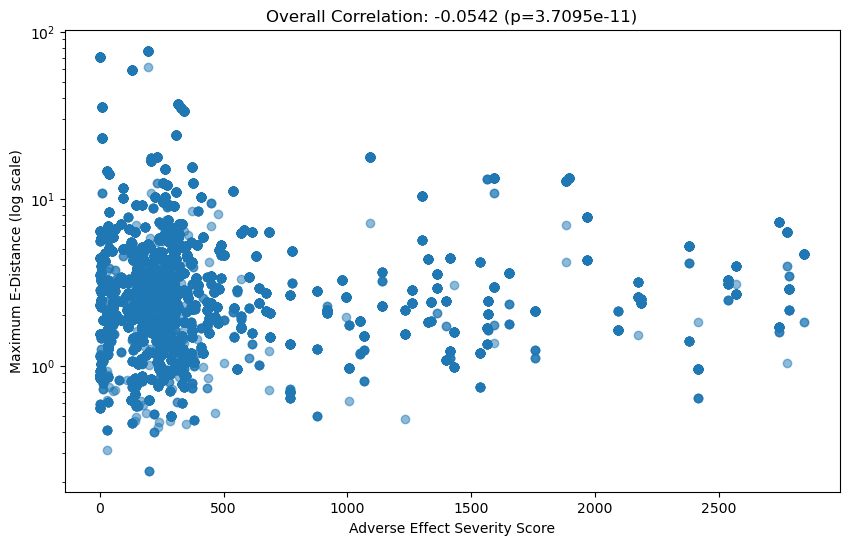

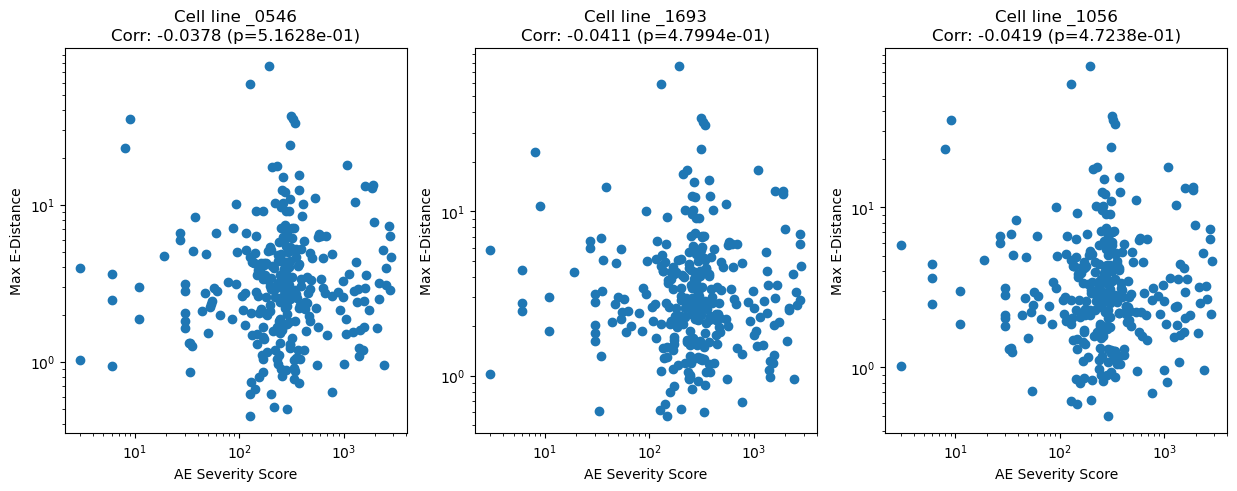

In [84]:
edist_df['drug'] = edist_df['drug_organ'].str.split("_").str[0]
edist_df['cell_line'] = edist_df.reset_index()['drug-cell_line'].str.split("_CVCL").str[1].values
# drug_edist = edist_df.groupby('drug')['max_e_distance'].mean()
# drug_edist = drug_edist.reset_index()

ae_severity = pd.read_csv('./data_for_classifier/tahoe_drug_ae_severity_score.csv', index_col=0)
ae_severity = ae_severity.reset_index().rename({'drug_name':'drug'}, axis=1)

pl_df = pd.merge(ae_severity, edist_df)
pl_df
from scipy.stats import pearsonr

# Analyze correlation for each cell line
cell_line_correlations = []
for cell_line in pl_df['cell_line'].unique():
    cell_data = pl_df[pl_df['cell_line'] == cell_line]
    
    # Only calculate if we have enough data points
    if len(cell_data) > 5:  # Minimum sample size for meaningful correlation
        correlation, p_value = pearsonr(cell_data['ae_severity_score'], cell_data['max_e_distance'])
        cell_line_correlations.append({
            'cell_line': cell_line,
            'correlation': correlation,
            'p_value': p_value,
            'sample_size': len(cell_data)
        })

# Convert to DataFrame for easier analysis
cell_corr_df = pd.DataFrame(cell_line_correlations)
cell_corr_df = cell_corr_df.sort_values('correlation', ascending=False)

# Display top correlations
print("Top cell lines by correlation strength:")
print(cell_corr_df.head(10))

# Calculate overall correlation for comparison
overall_correlation, overall_p_value = pearsonr(pl_df['ae_severity_score'], pl_df['max_e_distance'])
print(f"\nOverall correlation: {overall_correlation:.4f}, p-value: {overall_p_value:.4e}")

# Create scatter plot for overall correlation
plt.figure(figsize=(10, 6))
plt.scatter(pl_df['ae_severity_score'], pl_df['max_e_distance'], alpha=0.5)
plt.yscale('log')
# plt.xscale('log')
plt.title(f'Overall Correlation: {overall_correlation:.4f} (p={overall_p_value:.4e})')
plt.xlabel('Adverse Effect Severity Score')
plt.ylabel('Maximum E-Distance (log scale)')

# Create scatter plots for top 3 cell lines with strongest correlations
if len(cell_corr_df) >= 3:
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(cell_corr_df.head(3).iterrows()):
        cell_data = pl_df[pl_df['cell_line'] == row['cell_line']]
        plt.subplot(1, 3, i+1)
        plt.scatter(cell_data['ae_severity_score'], cell_data['max_e_distance'])
        plt.yscale('log')
        plt.xscale('log')
        plt.title(f"Cell line {row['cell_line']}\nCorr: {row['correlation']:.4f} (p={row['p_value']:.4e})")
        plt.xlabel('AE Severity Score')
        plt.ylabel('Max E-Distance')


In [ ]:
cell_corr_df

cell_line  correlation   p_value  sample_size
10     _0546    -0.037810  0.516283          297
30     _1693    -0.041145  0.479943          297
16     _1056    -0.041856  0.472383          297
21     _1724    -0.042676  0.463748          297
44     _1731    -0.044184  0.448084          297
31     _0131    -0.044848  0.441281          297
24     _0399    -0.045162  0.438093          297
42     _0397    -0.046183  0.427795          297
36     _0293    -0.046857  0.421079          297
47     _1055    -0.047293  0.416762          297
49     _0480    -0.047410  0.415610          297
12     _0332    -0.048412  0.405809          297
40     _0218    -0.048579  0.404190          297
3      _0371    -0.049654  0.393863          297
4      _0459    -0.050413  0.386662          297
18     _1550    -0.050592  0.384979          297
37     _0504    -0.051077  0.380430          297
23     _1635    -0.051303  0.378327          297
20     _1285    -0.051444  0.377013          297
5      _1125    -0.051512  0.376381          297
26     _1717    -0.051837  0.373370          297
8      _1666    -0.051945  0.372375          297
29     _1119    -0.052416  0.368054          297
25     _1097    -0.052782  0.364714          297
27     _0152    -0.053340  0.359659          297
7      _1517    -0.054592  0.348471          297
43     _0366    -0.054759  0.346996          297
38     _0292    -0.054875  0.345975          297
15     _1478    -0.054961  0.345225          297
19     _1239    -0.055025  0.344662          297
39     _0359    -0.055381  0.341541          297
34     _1547    -0.055698  0.338782          297
33     _0179    -0.057175  0.326106          297
11     _1577    -0.057372  0.324439          297
14     _0428    -0.058225  0.317290          297
41     _0320    -0.059585  0.306097          297
46     _1098    -0.060221  0.300956          297
45     _1716    -0.060345  0.299959          297
32     _0023    -0.060755  0.296682          297
22     _0334    -0.060941  0.295203          297
28     _0069    -0.062065  0.286364          297
6      _C466    -0.062336  0.284260          297
17     _1495    -0.062373  0.283975          297
35     _1094    -0.064065  0.271093          297
1      _1571    -0.064371  0.268802          297
13     _1531    -0.065030  0.263926          297
2      _0099    -0.066200  0.255407          297
0      _1381    -0.066742  0.251528          297
48     _0028    -0.067185  0.248392          297
9      _1715    -0.071727  0.217766          297

## Depmap scores

In [20]:
depmap_dependency = pd.read_table('./data_for_classifier/depmap_dependency_scores.tsv', index_col=0)
depmap_dependency['drug_organ'] = drug_cellline_df.set_index('drug-cell_line').loc[depmap_dependency.index]['drug_organ']
depmap_dependency = depmap_dependency.groupby('drug_organ').mean().reset_index()
depmap_dependency['depmap_dependency_score'] = depmap_dependency['depmap_dependency_score'] > 0.5

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5034295201971858
            Iterations: 11
            Function evaluations: 11
            Gradient evaluations: 11
Model training Precision-Recall AUC: 0.5232
Model training ROC AUC: 0.7113
Regularization: alpha=0.001

ROC AUC: 0.4760
Baseline ROC AUC: 0.5000
PR AUC: 0.1092
Baseline PR AUC: 0.1146


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]



Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance     0.630986  2.638828e-58    1.879463   

                CI_Lower_95  CI_Upper_95  
max_e_distance     0.554162      0.70781  

Number of significant coefficients (p < 0.05): 1 out of 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.18311748739153805
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Model training Precision-Recall AUC: 0.2634
Model training ROC AUC: 0.9039
Regularization: alpha=0.001

ROC AUC: 0.4944
Baseline ROC AUC: 0.5000
PR AUC: 0.2315
Baseline PR AUC: 0.1613


/tmp/ipykernel_99921/1471829481.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, C


Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance     6.218775  1.333616e-33   502.08794   

                CI_Lower_95  CI_Upper_95  
max_e_distance     5.209857     7.227694  

Number of significant coefficients (p < 0.05): 1 out of 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3514100522497421
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Model training Precision-Recall AUC: 0.1930
Model training ROC AUC: 0.6937
Regularization: alpha=0.001

ROC AUC: 0.3926
Baseline ROC AUC: 0.5000
PR AUC: 0.1235
Baseline PR AUC: 0.1471

Top significant features (p < 0.05):
                       Feature  Coefficient       p_value  Odds_Ratio  \
max_e_distance  max_e_distance    -2.718562  3.247961e-12     0.06597   

                CI_Lower_95  CI_Upper_95  
max_e_distance    -3.483399    -1.953724  

Numb

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 1 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4292917750430502
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Model training Precision-Recall AUC: 0.1095
Model training ROC AUC: 0.3324
Regularization: alpha=0.001

ROC AUC: 0.4798
Baseline ROC AUC: 0.5000
PR AUC: 0.1466
Baseline PR AUC: 0.1412

Top significant features (p < 0.05):
No statistically significant features found.

Number of significant coefficients (p < 0.05): 0 out of 1


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 2 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5431856642927236
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Model training Precision-Recall AUC: 0.6173
Model training ROC AUC: 0.5000
Regularization: alpha=0.001

ROC AUC: 0.5000
Baseline ROC AUC: 0.5000
PR AUC: 0.5607
Baseline PR AUC: 0.1213

Top significant features (p < 0.05):
No statistically significant features found.

Number of significant coefficients (p < 0.05): 0 out of 1


/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Results across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.109217  0.847638         0.114621      3577
1         43  0.231497  0.703942         0.161308      3577
2       5235  0.123545  0.852949         0.147051      3577
3        332  0.146585  0.858820         0.141180      3577
4       2132  0.560665  0.878669         0.121331      3577
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04931434199491006
            Iterations: 522
            Function evaluations: 523
            Gradient evaluations: 522
Model training Precision-Recall AUC: 0.3068
Model training ROC AUC: 0.9587
Regularization: alpha=0.001

ROC AUC: 0.5241
Baseline ROC AUC: 0.5000
PR AUC: 0.2348
Baseline PR AUC: 0.1932

Top significant features (p < 0.05):
    Feature  Coefficient       p_value    Odds_Ratio  CI_Lower_95  CI_Upper_95
X12     X12   -13.601275  4.409545e-07      0.000001   -18.879702    -8.322848
X9       X9  

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 7 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]
/tmp/ipykernel_99921/1471829481.py:39: Fut

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5282214995970997
            Iterations: 326
            Function evaluations: 327
            Gradient evaluations: 326
Model training Precision-Recall AUC: 0.2791
Model training ROC AUC: 0.5691
Regularization: alpha=0.001

ROC AUC: 0.5270
Baseline ROC AUC: 0.5000
PR AUC: 0.1600
Baseline PR AUC: 0.1447

Top significant features (p < 0.05):
    Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X23     X23    -0.444281  0.036587    0.641285    -0.860850    -0.027711
X13     X13    -0.274033  0.019779    0.760307    -0.504496    -0.043570

Number of significant coefficients (p < 0.05): 2 out of 30


/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 9 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4433498620996165
            Iterations: 123
            Function evaluations: 124
            Gradient evaluations: 123
Model training Precision-Recall AUC: 0.3877
Model training ROC AUC: 0.6764
Regularization: alpha=0.001

ROC AUC: 0.5444
Baseline ROC AUC: 0.5000
PR AUC: 0.1729
Baseline PR AUC: 0.1524

Top significant features (p < 0.05):
    Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X8       X8     1.573508  6.786786e-06    4.823542     0.888211     2.258805
X4       X4    -1.154150  2.742094e-05    0.315325    -1.693529    -0.614772
X23     X23    -1.061472  1.615642e-07    0.345946    -1.458590    -0.664354
X21     X21     0.928933  4.377495e-07    2.531806     0.568529     1.289337
X11     X11    -0.792025  2.524843e-06    0.452927    -1.121881    -0.462169
X25     X25     0.726480  1.901815e-06    2.067788     0.427572     1.025387
X28     X28    -0.692877  

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 19 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3848490555692486
            Iterations: 137
            Function evaluations: 138
            Gradient evaluations: 137
Model training Precision-Recall AUC: 0.2230
Model training ROC AUC: 0.6237
Regularization: alpha=0.001

ROC AUC: 0.4447
Baseline ROC AUC: 0.5000
PR AUC: 0.1453
Baseline PR AUC: 0.1648

Top significant features (p < 0.05):
    Feature  Coefficient   p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X3       X3    -0.617600  0.002454    0.539237    -1.017238    -0.217962
X26     X26     0.551068  0.012172    1.735106     0.120264     0.981873
X18     X18     0.539424  0.006178    1.715019     0.153307     0.925541
X20     X20     0.505612  0.009532    1.658000     0.123343     0.887881
X22     X22    -0.406837  0.025867    0.665753    -0.764698    -0.048975
X6       X6     0.371611  0.013160    1.450069     0.077855     0.665368
X12     X12     0.358030  0.028009    1.430508     0.0

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 19 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.05368975896178495
            Iterations: 351
            Function evaluations: 351
            Gradient evaluations: 351
Model training Precision-Recall AUC: 0.2919
Model training ROC AUC: 0.9440
Regularization: alpha=0.001

ROC AUC: 0.5320
Baseline ROC AUC: 0.5000
PR AUC: 0.2380
Baseline PR AUC: 0.1920

Top significant features (p < 0.05):
    Feature  Coefficient       p_value  Odds_Ratio  CI_Lower_95  CI_Upper_95
X12     X12   -10.314658  1.583716e-07    0.000033   -14.170865    -6.458452
X9       X9    -7.449219  1.250061e-07    0.000582   -10.211260    -4.687179
X23     X23     6.482829  2.602516e-04  653.818227     3.003566     9.962093
X10     X10     6.228429  1.131335e-05  506.958562     3.447942     9.008916
X22     X22     5.897590  5.624900e-08  364.158932     3.768980     8.026201
X2       X2    -5.403972  1.915620e-06    0.004499    -7.628101    -3.179842
X28     X28     4.280468 

/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 13 out of 31 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/home/emmadann/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)
/mnt/oak/users/emma/bin/tahoe-hack-2025/classifier.py:138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_skill = (y_test.sum()/y_test.shape[0])[0]


Results across different splits:
  split_seed    pr_auc  accuracy  pr_auc_baseline n_samples
0        432  0.234797  0.806959         0.193164      8133
1         43  0.160033  0.855325         0.144675      8329
2       5235  0.172874  0.840915         0.152447      8134
3        332  0.145283  0.835221         0.164779      8035
4       2132  0.238031  0.807504         0.192007      8182


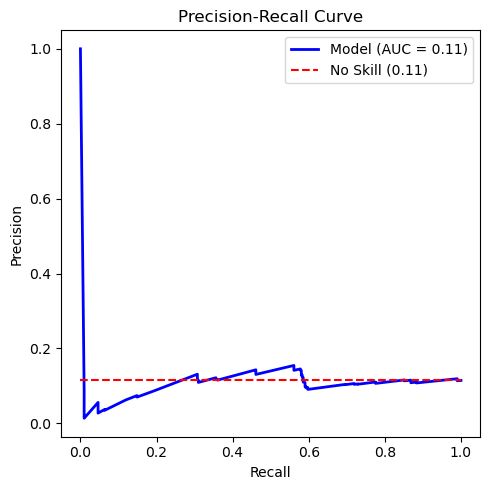

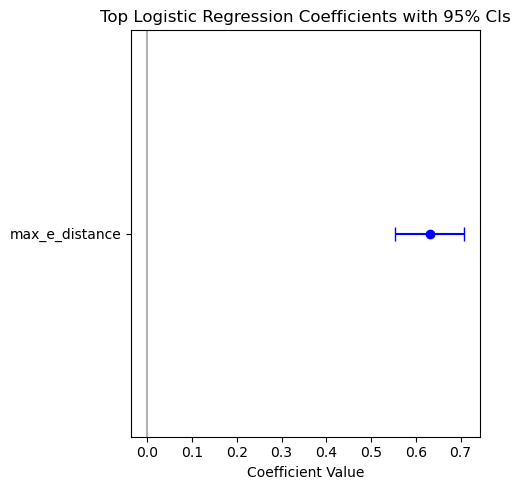

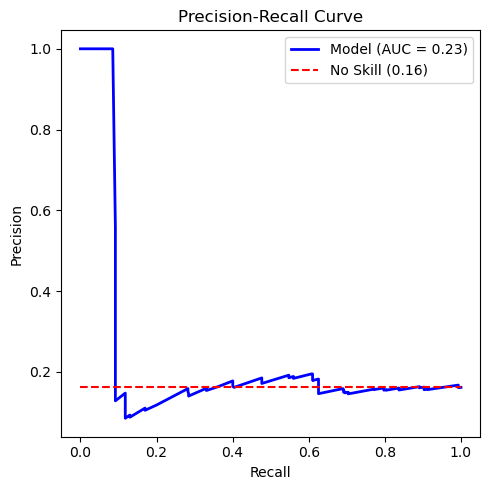

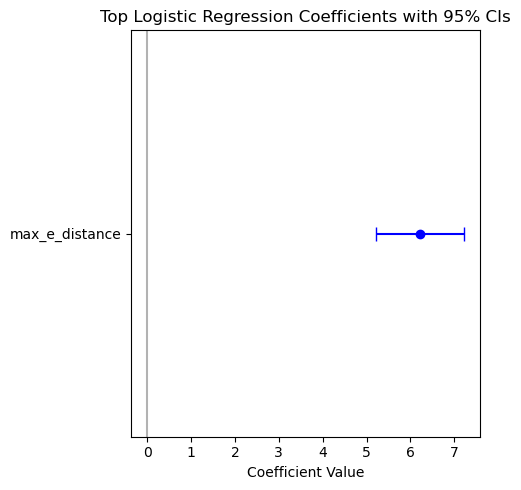

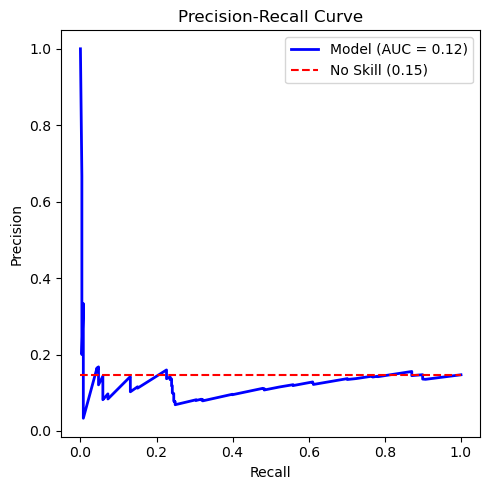

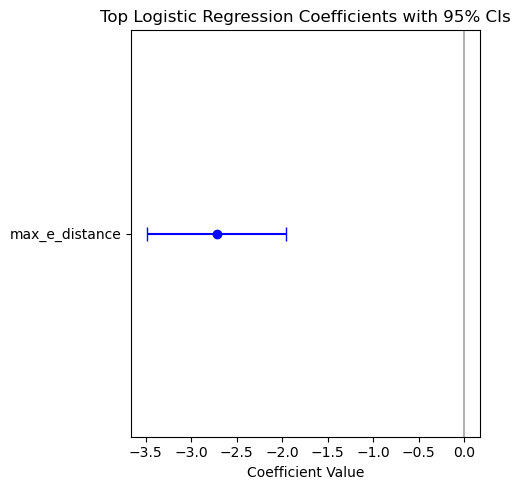

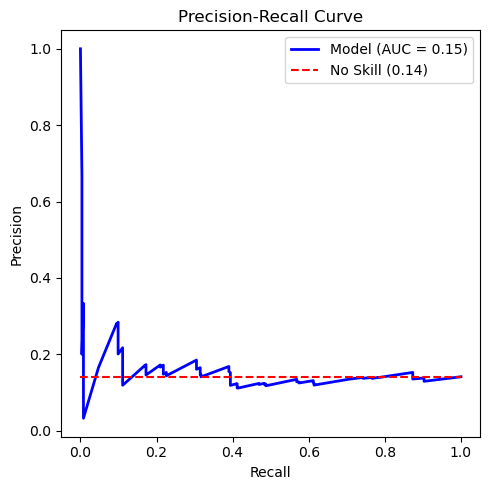

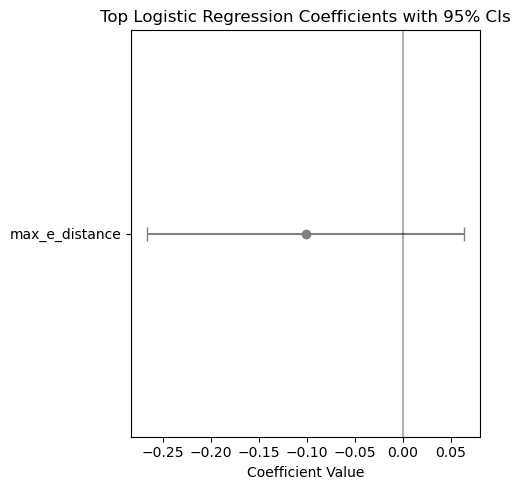

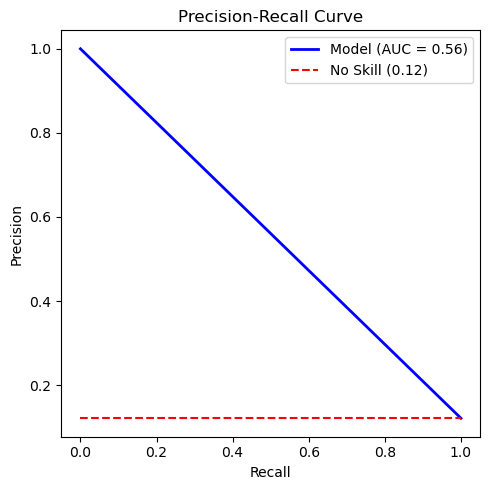

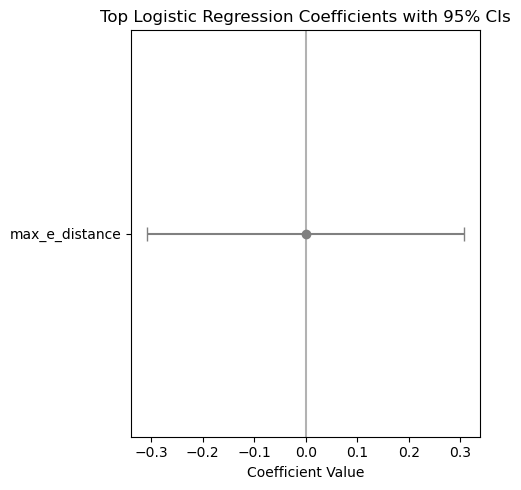

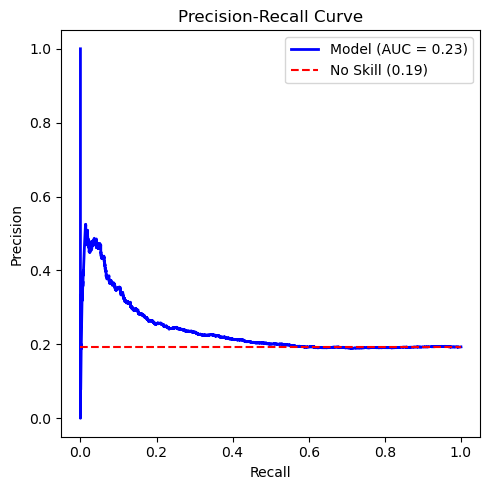

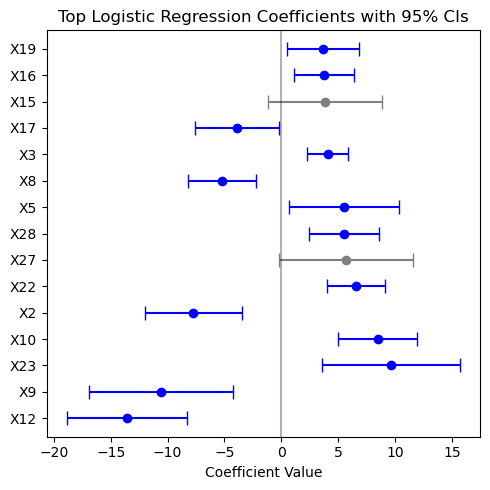

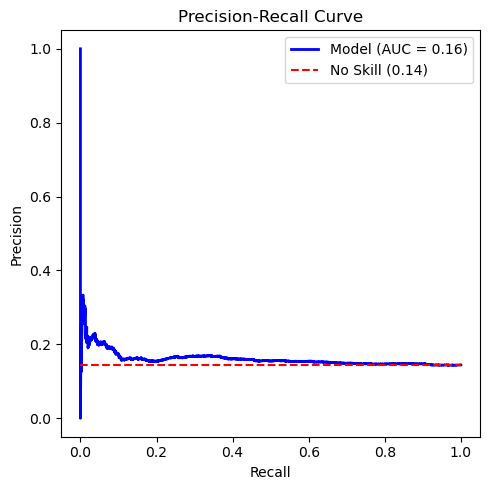

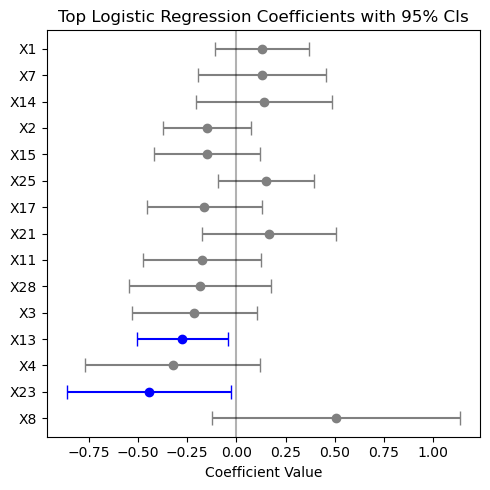

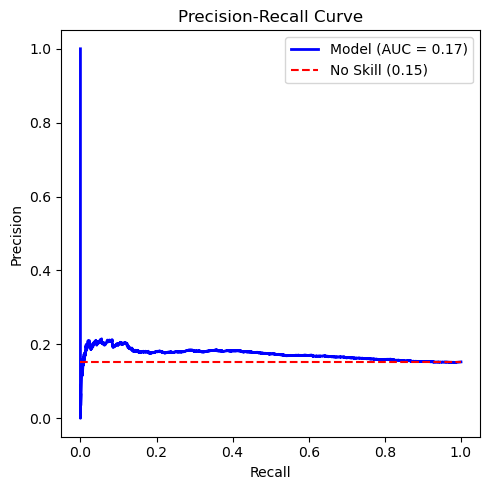

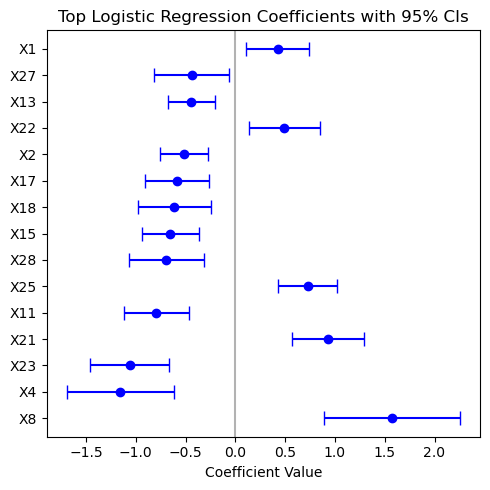

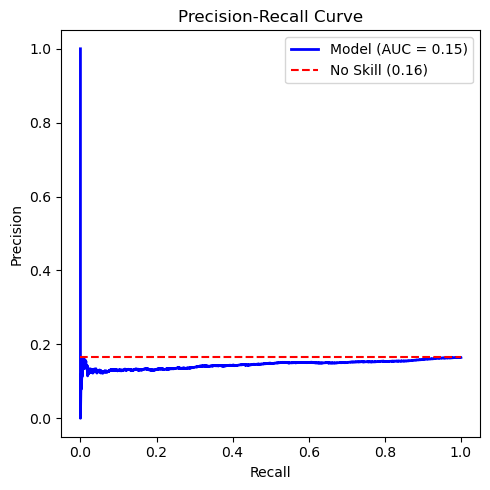

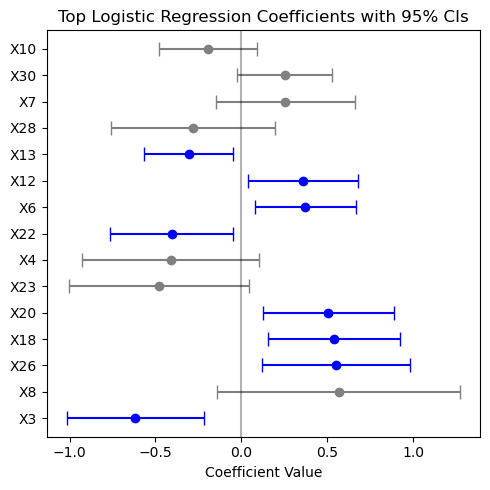

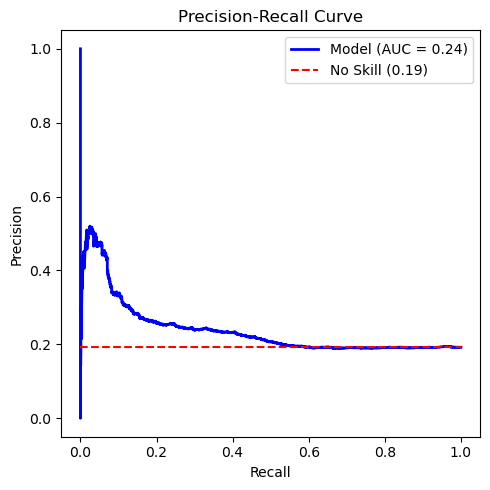

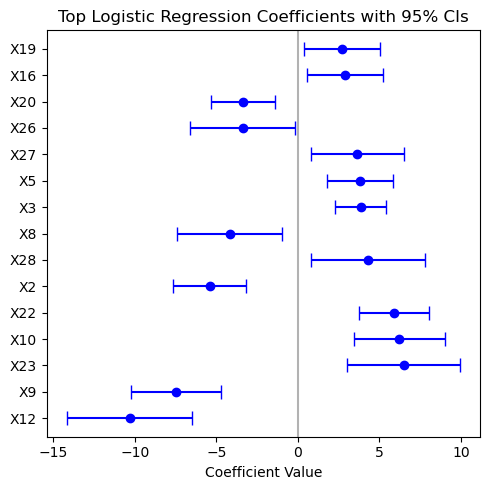

In [21]:
all_results_df = pd.DataFrame()
for k,input_features in test_features.items():
    outcomes = depmap_dependency

    common_drug_organ = np.intersect1d(input_features['drug_organ'].unique(), outcomes['drug_organ'].unique())

    input_features = input_features[input_features['drug_organ'].isin(common_drug_organ)]

    drug_organ_vec = input_features['drug_organ']
    outcomes = outcomes.set_index('drug_organ').loc[drug_organ_vec]
    outcomes.index = input_features.index

    # Convert indices to drug-cell_line
    assert outcomes.shape[0] == input_features.shape[0]
    X = input_features.drop('drug_organ', axis=1)
    y = outcomes.copy()

    # Initialize a results dataframe to store metrics for each split
    results_df = pd.DataFrame(columns=['split_seed', 'pr_auc', 'accuracy', 'pr_auc_baseline', 'n_samples'])

    for s in [432, 43, 5235, 332,2132]:
        X_train, X_test, y_train, y_test = prepare_data(X, y, split_seed=s)    
        lr_model = train_linear_model(X_train, y_train, alpha=0.001)    

        lr_pred, lr_prob, pr_auc, pr_auc_baseline = evaluate_model(lr_model, X_test, y_test)    
        coef_df = analyze_coefficients(lr_model, X_train.columns)
        
        # Calculate accuracy for this split
        accuracy = sum(lr_pred == y_test['depmap_dependency_score']) / len(y_test)
        
        # Store results in the dataframe
        new_row = pd.DataFrame({
            'split_seed': [s],
            'pr_auc': [pr_auc],
            'accuracy': [accuracy],
            'pr_auc_baseline':[pr_auc_baseline],
            'n_samples': [len(y_test)]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Display the results
    print("Results across different splits:")
    print(results_df)

    results_df['X_features'] = k
    all_results_df = pd.concat([all_results_df, results_df])

Text(0, 0.5, 'AUPRC - approval prediction')

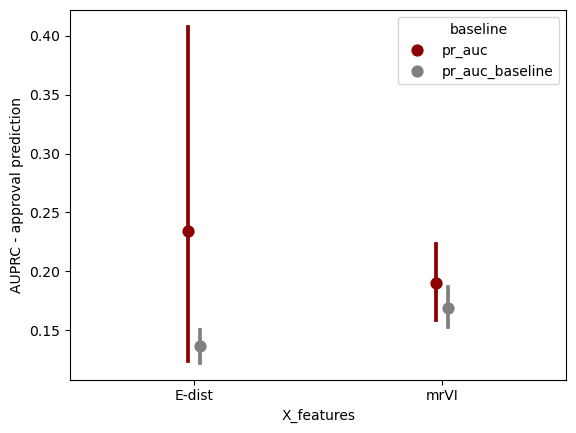

In [23]:
pl_df = all_results_df.drop('accuracy', axis=1).melt(id_vars=['split_seed', 'n_samples', 'X_features'], var_name='baseline', value_name='AUPRC')
sns.pointplot(
    data=pl_df,
    x='X_features', y='AUPRC',
    hue='baseline',
    linestyles='none',
    dodge=True,
    errorbar=('ci', 95),
    palette={'pr_auc_baseline': 'grey', 'pr_auc': 'darkred'}
    );
plt.ylabel('AUPRC - approval prediction')

In [27]:
common_drug_organ = np.intersect1d(edist_df['drug_organ'].unique(), depmap_dependency['drug_organ'].unique())

In [30]:
common_drug_organ

array(['(R)-Verapamil (hydrochloride)_Bladder/Urinary Tract',
       '(R)-Verapamil (hydrochloride)_Bowel',
       '(R)-Verapamil (hydrochloride)_Breast', ...,
       'venetoclax_Peripheral Nervous System', 'venetoclax_Skin',
       'venetoclax_Uterus'], dtype=object)